Training Logistic Regression...

Logistic Regression Report:
Accuracy: 0.730
Training Time: 0.029 seconds
Model Size: 24 bytes
Classification Report:
              precision    recall  f1-score   support

     Class 0      0.741     0.765     0.753       862
     Class 1      0.715     0.689     0.702       740

    accuracy                          0.730      1602
   macro avg      0.728     0.727     0.727      1602
weighted avg      0.729     0.730     0.729      1602

AUC: 0.805

Logistic Regression Parameters:
C: 1.0
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 100
multi_class: auto
n_jobs: None
penalty: l2
random_state: 42
solver: lbfgs
tol: 0.0001
verbose: 0
warm_start: False


Training SVM...

SVM Report:
Accuracy: 0.757
Training Time: 11.012 seconds
Model Size: 24 bytes
Classification Report:
              precision    recall  f1-score   support

     Class 0      0.796     0.737     0.765       862
     Class 1      0.718   

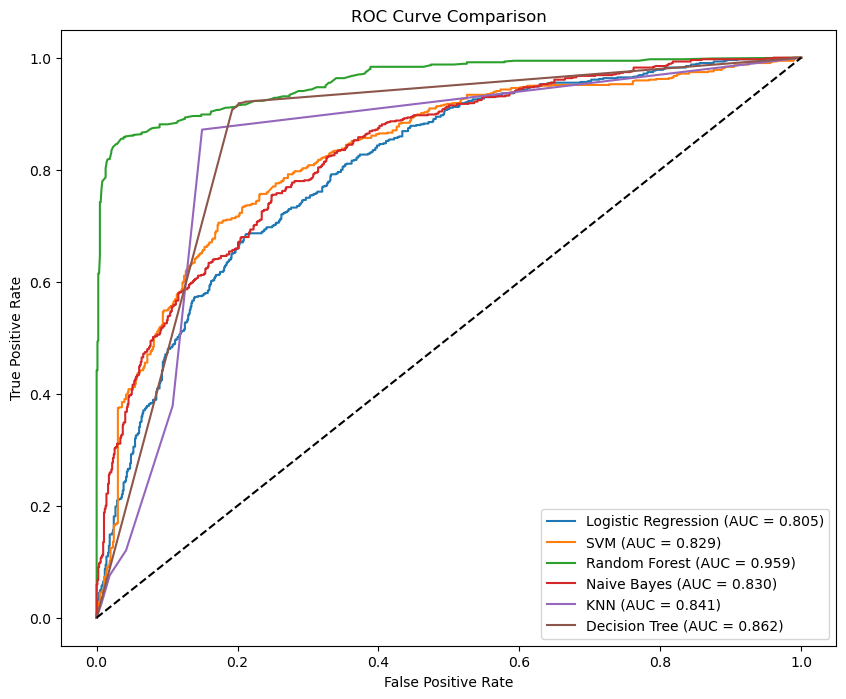

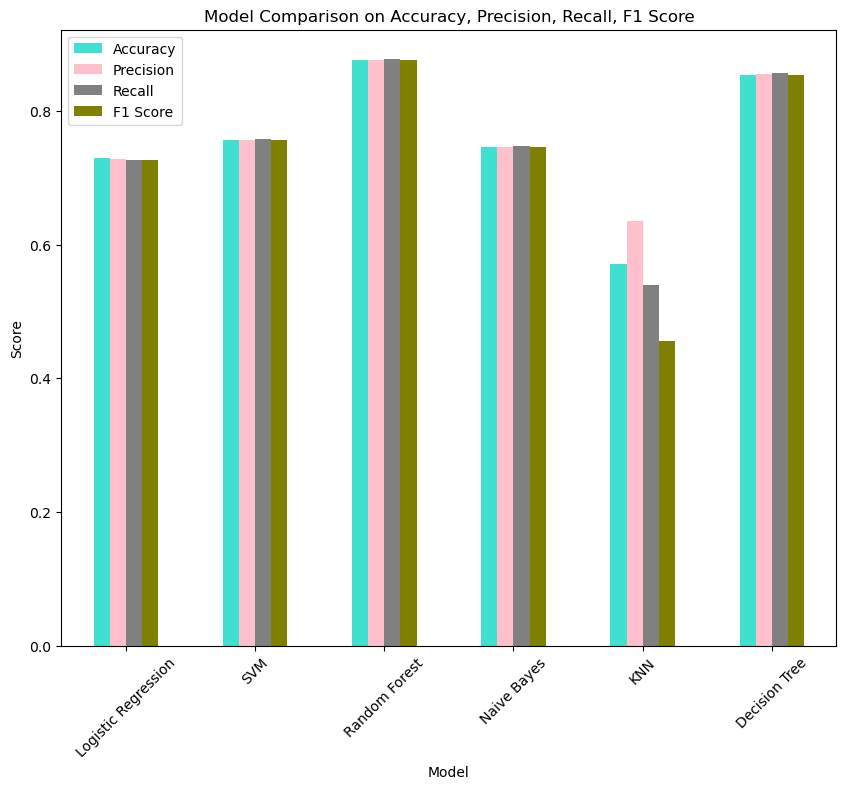

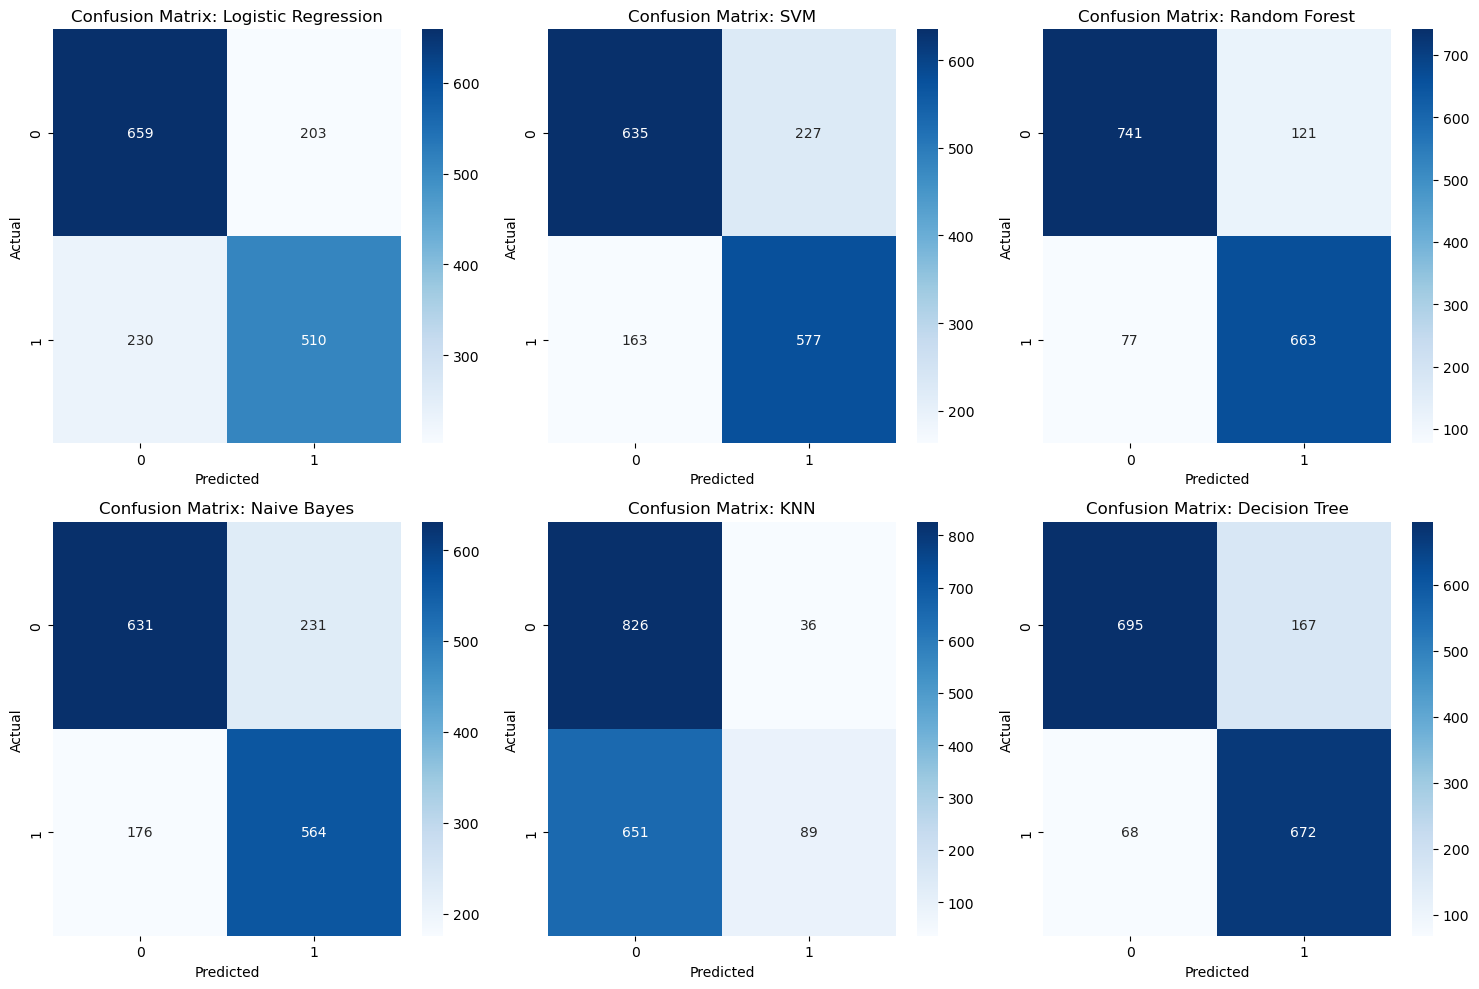

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Conv1D, LSTM, Bidirectional, GRU, SimpleRNN
import time
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import os

# Create directory to save figures if it doesn't exist
output_dir = "TFIDF_Tokenizer_ML"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Load dataset
data = pd.read_csv('001_2802_merged_12000.csv')

# Data preprocessing
X = data['text']
y = data['label']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Define conventional ML models with parameters
ml_models = {
    'Logistic Regression': LogisticRegression(
        penalty='l2',  # Regularization term
        C=1.0,  # Inverse of regularization strength
        solver='lbfgs',  # Optimization algorithm
        max_iter=100,  # Maximum number of iterations
        random_state=42  # Seed for random number generator
    ),
    'SVM': SVC(
        kernel='linear',  # Kernel type to be used in the algorithm
        C=1.0,  # Regularization parameter
        probability=True,  # Whether to enable probability estimates
        random_state=42  # Seed for random number generator
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,  # Number of trees in the forest
        max_depth=None,  # Maximum depth of the tree
        random_state=42  # Seed for random number generator
    ),
    'Naive Bayes': MultinomialNB(
        alpha=1.0,  # Additive (Laplace/Lidstone) smoothing parameter
        fit_prior=True  # Whether to learn class prior probabilities
    ),
    'KNN': KNeighborsClassifier(
        n_neighbors=5,  # Number of neighbors to use
        weights='uniform',  # Weight function used in prediction
        algorithm='auto'  # Algorithm used to compute the nearest neighbors
    ),
    'Decision Tree': DecisionTreeClassifier(
        criterion='gini',  # Function to measure the quality of a split
        max_depth=None,  # Maximum depth of the tree
        random_state=42  # Seed for random number generator
    )
}

# Train and evaluate conventional ML models
ml_results = {}
plt.figure(figsize=(10, 8))  # For ROC curve plotting

for name, model in ml_models.items():
    print(f"Training {name}...")
    start_time = time.time()
    model.fit(X_train_tfidf, y_train)
    training_time = time.time() - start_time
    
    y_pred = model.predict(X_test_tfidf)
    y_proba = model.predict_proba(X_test_tfidf)[:, 1] if hasattr(model, 'predict_proba') else None
    
    fpr, tpr, _ = roc_curve(y_test, y_proba) if y_proba is not None else (None, None, None)
    
    ml_results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average=None),  # Per-class precision
        'recall': recall_score(y_test, y_pred, average=None),  # Per-class recall
        'f1': f1_score(y_test, y_pred, average=None),  # Per-class F1 score
        'auc': roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        'training_time': training_time,
        'model_size': model.__sizeof__(),
        'classification_report': classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], digits=3),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'parameters': model.get_params(),  # Get model parameters
        'roc_curve': (fpr, tpr)
    }
    
    # Plot ROC curve
    if y_proba is not None:
        plt.plot(fpr, tpr, label=f'{name} (AUC = {ml_results[name]["auc"]:.3f})')
    
    # Print report
    print(f"\n{name} Report:")
    print(f"Accuracy: {ml_results[name]['accuracy']:.3f}")
    print(f"Training Time: {ml_results[name]['training_time']:.3f} seconds")
    print(f"Model Size: {ml_results[name]['model_size']} bytes")
    print(f"Classification Report:\n{ml_results[name]['classification_report']}")
    if ml_results[name]['auc'] is not None:
        print(f"AUC: {ml_results[name]['auc']:.3f}")
    
    # Print model parameters
    print(f"\n{name} Parameters:")
    for param, value in ml_results[name]['parameters'].items():
        print(f"{param}: {value}")
    print("\n" + "="*60 + "\n")

# Finalize and show the ROC plot
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='best')
roc_fig_path = os.path.join(output_dir, 'Model_Comparison_ROC.png')
plt.savefig(roc_fig_path)
plt.show()

# Plot Accuracy, Precision, Recall, F1 scores
metrics_df = pd.DataFrame({
    'Model': list(ml_results.keys()),
    'Accuracy': [ml_results[name]['accuracy'] for name in ml_results],
    'Precision': [ml_results[name]['precision'].mean() for name in ml_results],
    'Recall': [ml_results[name]['recall'].mean() for name in ml_results],
    'F1 Score': [ml_results[name]['f1'].mean() for name in ml_results]
})

metrics_df.set_index('Model').plot(kind='bar', figsize=(10, 8), color=['turquoise', 'pink', 'gray', 'olive'])
plt.title('Model Comparison on Accuracy, Precision, Recall, F1 Score')
plt.ylabel('Score')
plt.xticks(rotation=45)
metrics_fig_path = os.path.join(output_dir, 'Model_Comparison_Metrics.png')
plt.savefig(metrics_fig_path)
plt.show()

# Plot confusion matrices
plt.figure(figsize=(15, 10))
for i, (name, result) in enumerate(ml_results.items()):
    plt.subplot(2, 3, i + 1)
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

plt.tight_layout()
confusion_fig_path = os.path.join(output_dir, 'Model_Comparison_confusion.png')
plt.savefig(confusion_fig_path)
plt.show()


Training Logistic Regression...

Logistic Regression Report:
Accuracy: 0.730
Training Time: 0.031 seconds
Model Size: 0.037 MB
Classification Report:
              precision    recall  f1-score   support

     Class 0      0.741     0.765     0.753       862
     Class 1      0.715     0.689     0.702       740

    accuracy                          0.730      1602
   macro avg      0.728     0.727     0.727      1602
weighted avg      0.729     0.730     0.729      1602

AUC: 0.805


Training SVM...

SVM Report:
Accuracy: 0.757
Training Time: 11.190 seconds
Model Size: 0.902 MB
Classification Report:
              precision    recall  f1-score   support

     Class 0      0.796     0.737     0.765       862
     Class 1      0.718     0.780     0.747       740

    accuracy                          0.757      1602
   macro avg      0.757     0.758     0.756      1602
weighted avg      0.760     0.757     0.757      1602

AUC: 0.829


Training Random Forest...

Random Forest Report:
Ac

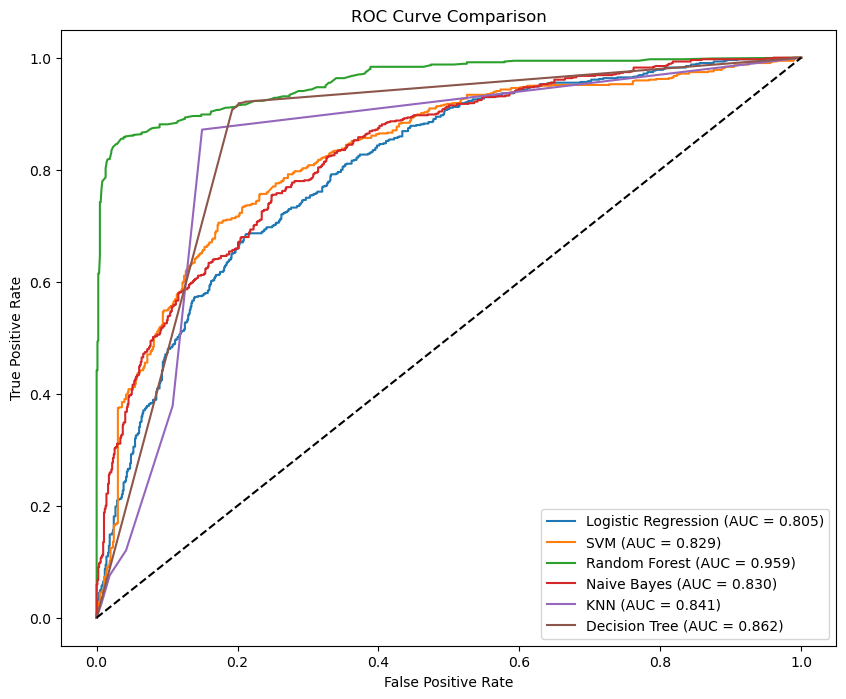

                 Model  Training Time (s)  F1 Score  Model Size (MB)
0  Logistic Regression           0.031260  0.729285         0.037124
1                  SVM          11.190139  0.756907         0.902263
2        Random Forest           7.164522  0.876570        26.923318
3          Naive Bayes           0.000998  0.746308         0.145926
4                  KNN           0.001148  0.475090         1.050213
5        Decision Tree           0.649204  0.853439         0.133569


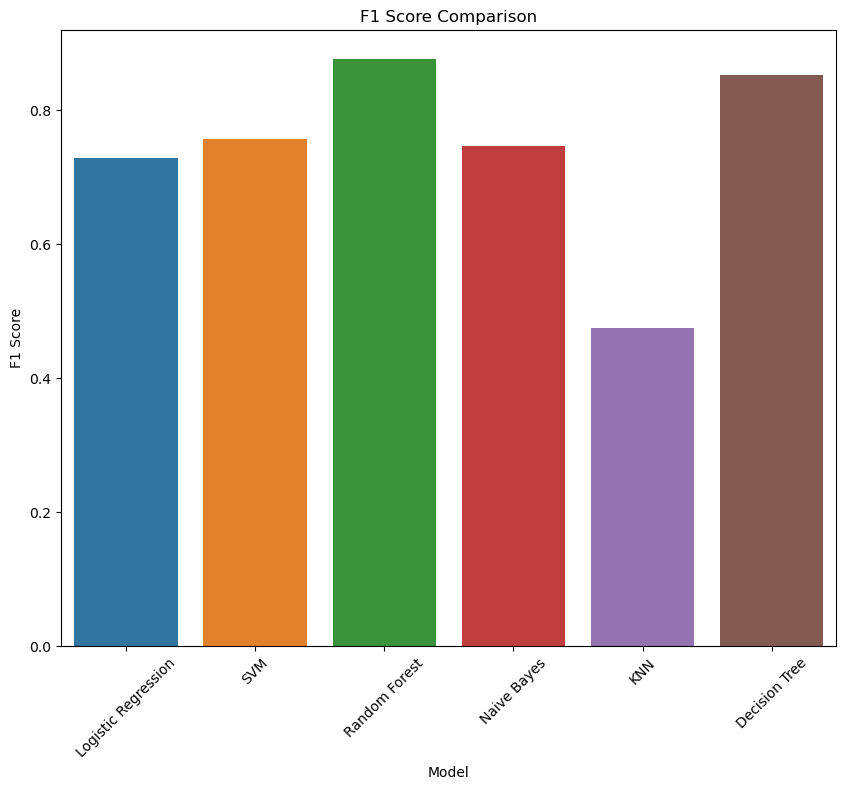

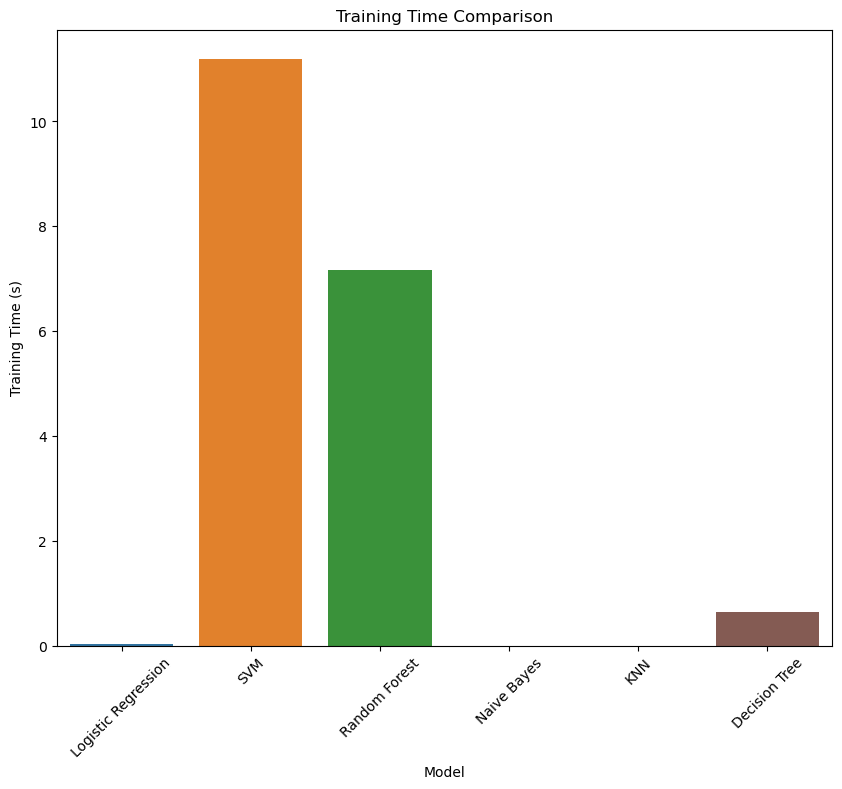

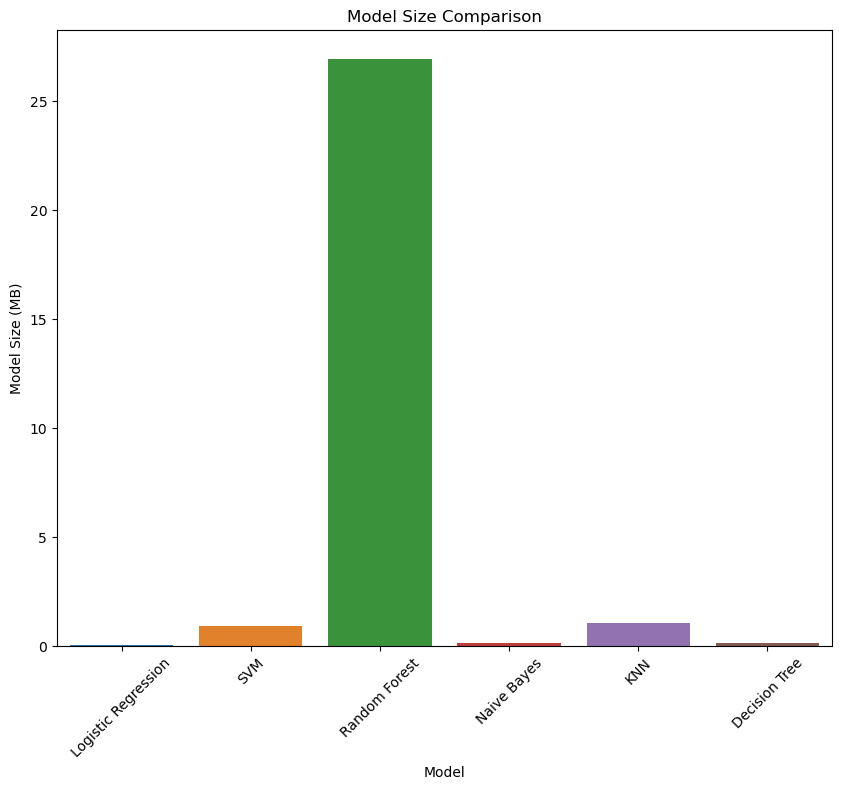

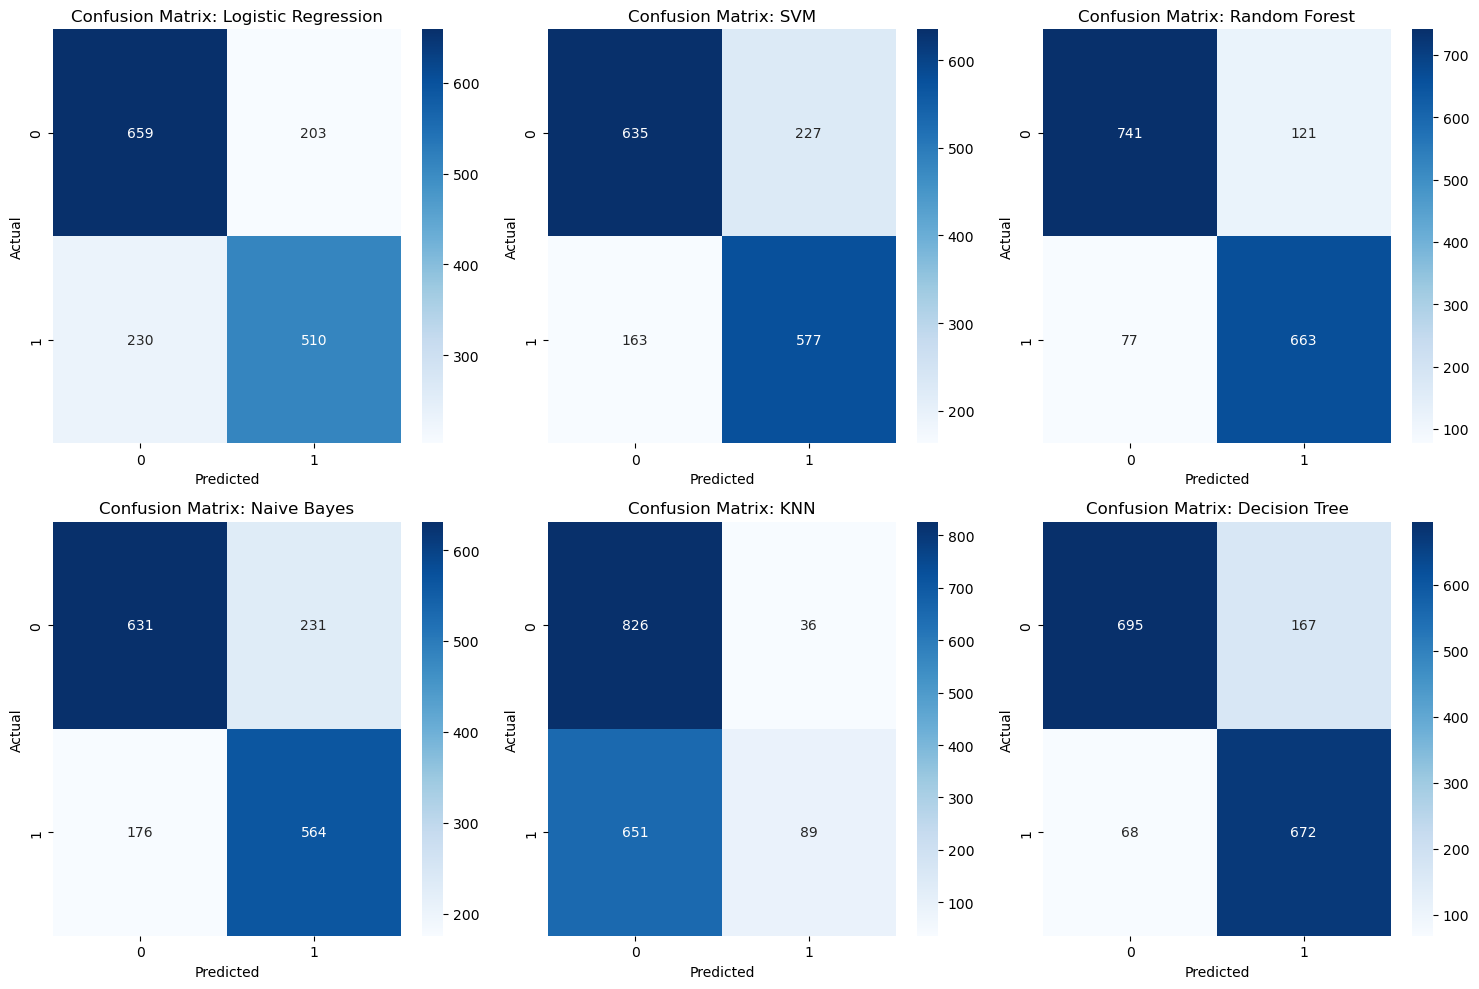

In [49]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Conv1D, LSTM, Bidirectional, GRU, SimpleRNN
import time
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import joblib

# Create directory to save figures if it doesn't exist
output_dir = "TFIDF_Tokenizer_ML"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Load dataset
data = pd.read_csv('001_2802_merged_12000.csv')

# Data preprocessing
X = data['text']
y = data['label']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Define conventional ML models
ml_models = {
    'Logistic Regression': LogisticRegression(
        penalty='l2', solver='lbfgs', max_iter=100, random_state=42
    ),
    'SVM': SVC(
        kernel='linear', C=1.0, probability=True, random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, random_state=42
    ),
    'Naive Bayes': MultinomialNB(),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(
        random_state=42
    )
}

# Train and evaluate conventional ML models
ml_results = []
plt.figure(figsize=(10, 8))  # For ROC curve plotting

for name, model in ml_models.items():
    print(f"Training {name}...")
    start_time = time.time()
    model.fit(X_train_tfidf, y_train)
    training_time = time.time() - start_time
    
    y_pred = model.predict(X_test_tfidf)
    y_proba = model.predict_proba(X_test_tfidf)[:, 1] if hasattr(model, 'predict_proba') else None
    
    fpr, tpr, _ = roc_curve(y_test, y_proba) if y_proba is not None else (None, None, None)
    
    # Save the model to a temporary file to measure its size
    temp_model_file = f"{name}_model.joblib"
    joblib.dump(model, temp_model_file)
    model_size = os.path.getsize(temp_model_file) / (1024 ** 2)  # Convert size to megabytes
    os.remove(temp_model_file)
    
    ml_results.append({
        'Model': name,
        'Training Time (s)': training_time,
        'F1 Score': f1_score(y_test, y_pred, average='weighted'),
        'Model Size (MB)': model_size
    })
    
    # Plot ROC curve
    if y_proba is not None:
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_proba):.3f})')
    
    # Print report
    print(f"\n{name} Report:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(f"Training Time: {training_time:.3f} seconds")
    print(f"Model Size: {model_size:.3f} MB")
    print(f"Classification Report:\n{classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], digits=3)}")
    if y_proba is not None:
        print(f"AUC: {roc_auc_score(y_test, y_proba):.3f}")
    print("\n" + "="*60 + "\n")

# Finalize and show the ROC plot
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='best')
roc_fig_path = os.path.join(output_dir, 'Model_Comparison_ROC.png')
plt.savefig(roc_fig_path)
plt.show()

# Create a DataFrame to display the results
results_df = pd.DataFrame(ml_results)
print(results_df)

# Plotting metrics
plt.figure(figsize=(10, 8))
sns.barplot(x='Model', y='F1 Score', data=results_df)
plt.xticks(rotation=45)
plt.title('F1 Score Comparison')
plt.savefig(os.path.join(output_dir, 'Model_Comparison_F1_Score.png'))
plt.show()

plt.figure(figsize=(10, 8))
sns.barplot(x='Model', y='Training Time (s)', data=results_df)
plt.xticks(rotation=45)
plt.title('Training Time Comparison')
plt.savefig(os.path.join(output_dir, 'Model_Comparison_Training_Time.png'))
plt.show()

plt.figure(figsize=(10, 8))
sns.barplot(x='Model', y='Model Size (MB)', data=results_df)
plt.xticks(rotation=45)
plt.title('Model Size Comparison')
plt.savefig(os.path.join(output_dir, 'Model_Comparison_Model_Size.png'))
plt.show()

# Plot confusion matrices
plt.figure(figsize=(15, 10))
for i, (name, model) in enumerate(ml_models.items()):
    plt.subplot(2, 3, i + 1)
    y_pred = model.predict(X_test_tfidf)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

plt.tight_layout()
confusion_fig_path = os.path.join(output_dir, 'Model_Comparison_confusion.png')
plt.savefig(confusion_fig_path)
plt.show()


NaN values in X_train: 0, Inf values in X_train: 0
NaN values in X_test: 0, Inf values in X_test: 0


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training SimpleRNN...
Epoch 1/10
201/201 - 47s - 235ms/step - accuracy: 0.5411 - loss: 0.7051 - val_accuracy: 0.5381 - val_loss: 0.7009
Epoch 2/10
201/201 - 45s - 224ms/step - accuracy: 0.5418 - loss: 0.6963 - val_accuracy: 0.5381 - val_loss: 0.6923
Epoch 3/10
201/201 - 47s - 233ms/step - accuracy: 0.5418 - loss: 0.6893 - val_accuracy: 0.5381 - val_loss: 0.6918
Epoch 4/10
201/201 - 47s - 232ms/step - accuracy: 0.5418 - loss: 0.6878 - val_accuracy: 0.5381 - val_loss: 0.6881
Epoch 5/10
201/201 - 47s - 231ms/step - accuracy: 0.5418 - loss: 0.6847 - val_accuracy: 0.5381 - val_loss: 0.6862
Epoch 6/10
201/201 - 48s - 237ms/step - accuracy: 0.5418 - loss: 0.6834 - val_accuracy: 0.5381 - val_loss: 0.6847
Epoch 7/10
201/201 - 47s - 236ms/step - accuracy: 0.5418 - loss: 0.6824 - val_accuracy: 0.5381 - val_loss: 0.6853
Epoch 8/10
201/201 - 46s - 227ms/step - accuracy: 0.5418 - loss: 0.6820 - val_accuracy: 0.5381 - val_loss: 0.6830
Epoch 9/10
201/201 - 47s - 232ms/step - accuracy: 0.5418 - loss: 0

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classifi

201/201 - 6s - 30ms/step - accuracy: 0.5377 - loss: 0.6930 - val_accuracy: 0.5381 - val_loss: 0.6928
Epoch 2/10
201/201 - 5s - 27ms/step - accuracy: 0.5418 - loss: 0.6927 - val_accuracy: 0.5381 - val_loss: 0.6926
Epoch 3/10
201/201 - 5s - 26ms/step - accuracy: 0.5418 - loss: 0.6923 - val_accuracy: 0.5381 - val_loss: 0.6923
Epoch 4/10
201/201 - 5s - 26ms/step - accuracy: 0.5418 - loss: 0.6921 - val_accuracy: 0.5381 - val_loss: 0.6921
Epoch 5/10
201/201 - 5s - 26ms/step - accuracy: 0.5418 - loss: 0.6918 - val_accuracy: 0.5381 - val_loss: 0.6919
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

1D CNN Report:
Accuracy: 0.538
Training Time: 27.248 seconds
Model Size: 897 parameters
Classification Report:
              precision    recall  f1-score   support

     Class 0      0.538     1.000     0.700       862
     Class 1      0.000     0.000     0.000       740

    accuracy                          0.538      1602
   macro avg      0.269     0.500     0.350      1602
weighted avg      0.290     

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classifi

201/201 - 261s - 1s/step - accuracy: 0.5415 - loss: 0.7075 - val_accuracy: 0.5381 - val_loss: 0.7020
Epoch 2/10
201/201 - 227s - 1s/step - accuracy: 0.5418 - loss: 0.6986 - val_accuracy: 0.5381 - val_loss: 0.6967
Epoch 3/10
201/201 - 225s - 1s/step - accuracy: 0.5418 - loss: 0.6947 - val_accuracy: 0.5381 - val_loss: 0.6936
Epoch 4/10
201/201 - 226s - 1s/step - accuracy: 0.5418 - loss: 0.6923 - val_accuracy: 0.5381 - val_loss: 0.6919
Epoch 5/10
201/201 - 225s - 1s/step - accuracy: 0.5418 - loss: 0.6910 - val_accuracy: 0.5381 - val_loss: 0.6910
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 338ms/step

LSTM Report:
Accuracy: 0.538
Training Time: 1163.618 seconds
Model Size: 66689 parameters
Classification Report:
              precision    recall  f1-score   support

     Class 0      0.538     1.000     0.700       862
     Class 1      0.000     0.000     0.000       740

    accuracy                          0.538      1602
   macro avg      0.269     0.500     0.350      1602
weighted avg      0.290

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classifi

201/201 - 231s - 1s/step - accuracy: 0.5400 - loss: 0.7077 - val_accuracy: 0.5381 - val_loss: 0.7030
Epoch 2/10
201/201 - 228s - 1s/step - accuracy: 0.5418 - loss: 0.6995 - val_accuracy: 0.5381 - val_loss: 0.6974
Epoch 3/10
201/201 - 228s - 1s/step - accuracy: 0.5418 - loss: 0.6952 - val_accuracy: 0.5381 - val_loss: 0.6943
Epoch 4/10
201/201 - 227s - 1s/step - accuracy: 0.5418 - loss: 0.6929 - val_accuracy: 0.5381 - val_loss: 0.6925
Epoch 5/10
201/201 - 222s - 1s/step - accuracy: 0.5418 - loss: 0.6914 - val_accuracy: 0.5381 - val_loss: 0.6914
51/51 ━━━━━━━━━━━━━━━━━━━━ 12s 242ms/step

GRU Report:
Accuracy: 0.538
Training Time: 1135.768 seconds
Model Size: 50433 parameters
Classification Report:
              precision    recall  f1-score   support

     Class 0      0.538     1.000     0.700       862
     Class 1      0.000     0.000     0.000       740

    accuracy                          0.538      1602
   macro avg      0.269     0.500     0.350      1602
weighted avg      0.290 

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classifi

201/201 - 440s - 2s/step - accuracy: 0.5410 - loss: 0.7223 - val_accuracy: 0.5381 - val_loss: 0.7129
Epoch 2/10
201/201 - 377s - 2s/step - accuracy: 0.5418 - loss: 0.7070 - val_accuracy: 0.5381 - val_loss: 0.7026
Epoch 3/10
201/201 - 299s - 1s/step - accuracy: 0.5418 - loss: 0.6989 - val_accuracy: 0.5381 - val_loss: 0.6967
Epoch 4/10
201/201 - 318s - 2s/step - accuracy: 0.5418 - loss: 0.6944 - val_accuracy: 0.5381 - val_loss: 0.6934
Epoch 5/10
201/201 - 308s - 2s/step - accuracy: 0.5418 - loss: 0.6920 - val_accuracy: 0.5381 - val_loss: 0.6918
51/51 ━━━━━━━━━━━━━━━━━━━━ 23s 457ms/step

Bidirectional LSTM Report:
Accuracy: 0.538
Training Time: 1741.622 seconds
Model Size: 133377 parameters
Classification Report:
              precision    recall  f1-score   support

     Class 0      0.538     1.000     0.700       862
     Class 1      0.000     0.000     0.000       740

    accuracy                          0.538      1602
   macro avg      0.269     0.500     0.350      1602
weighted

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classifi

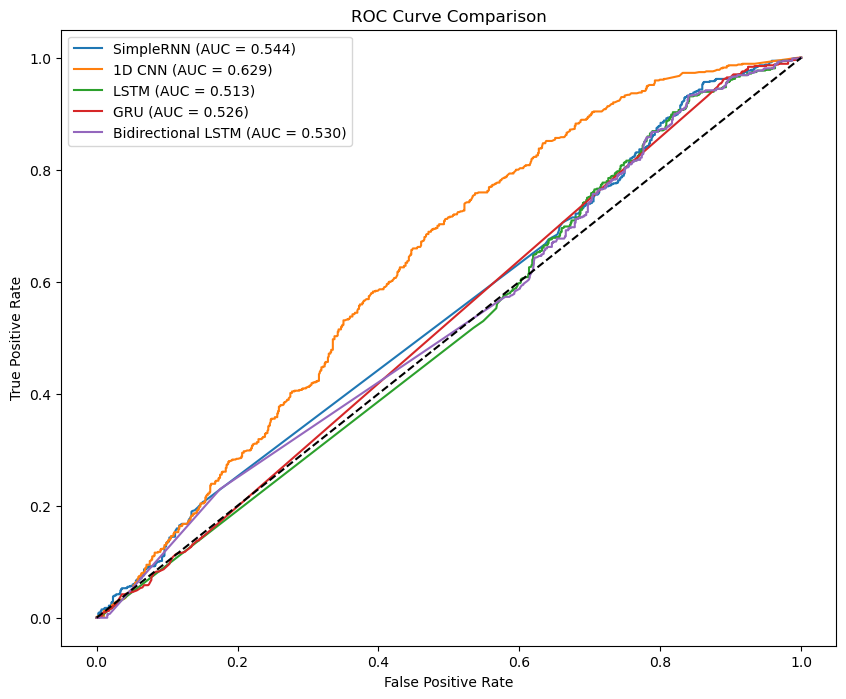

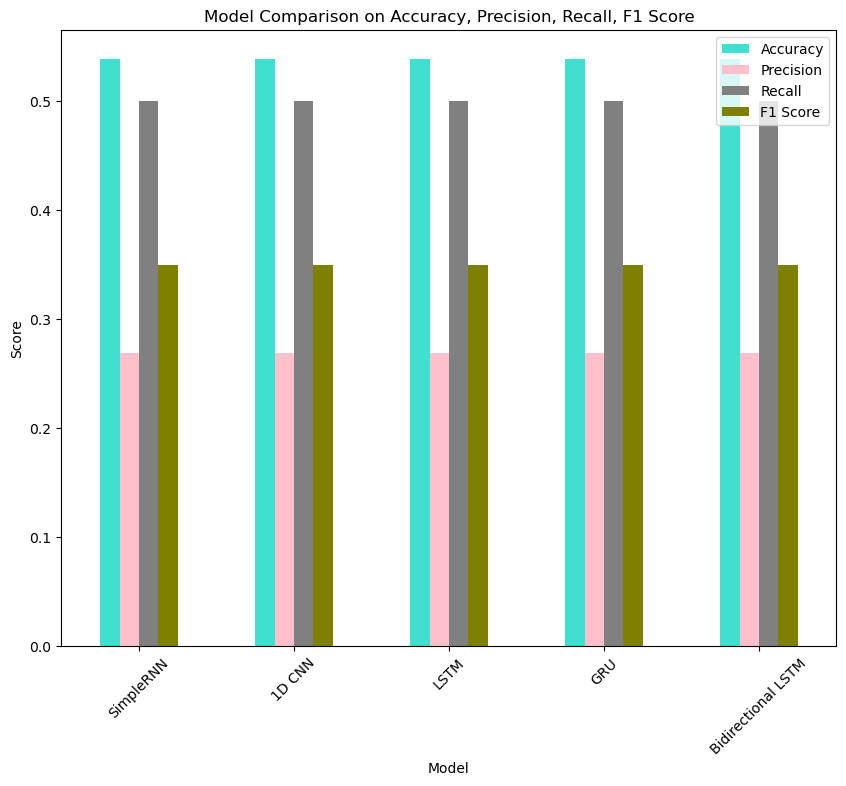

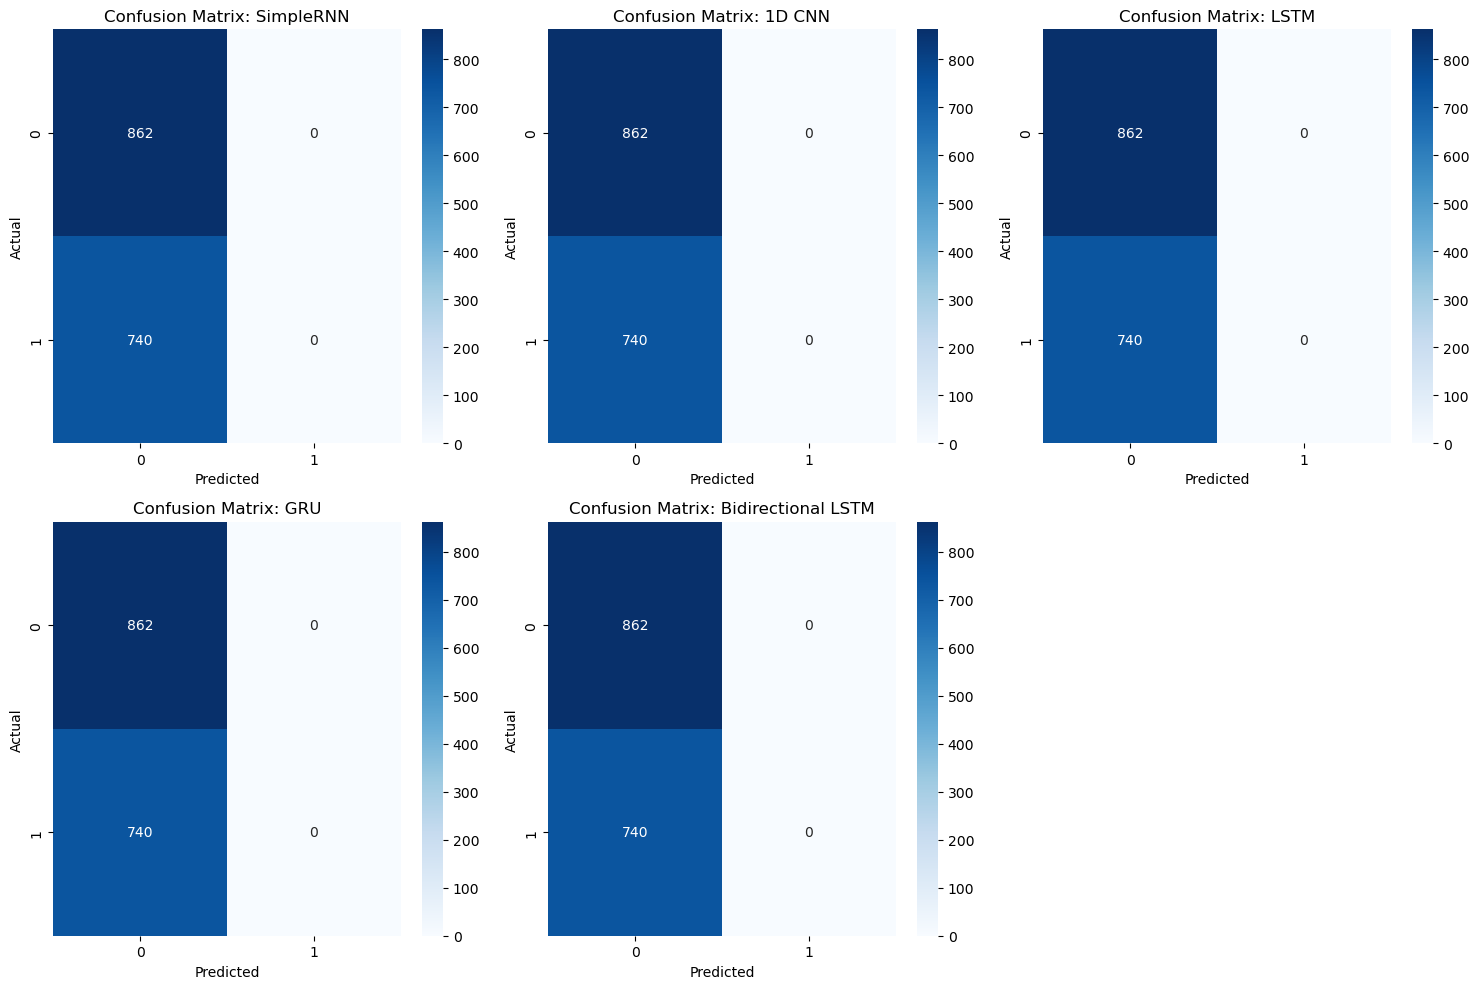

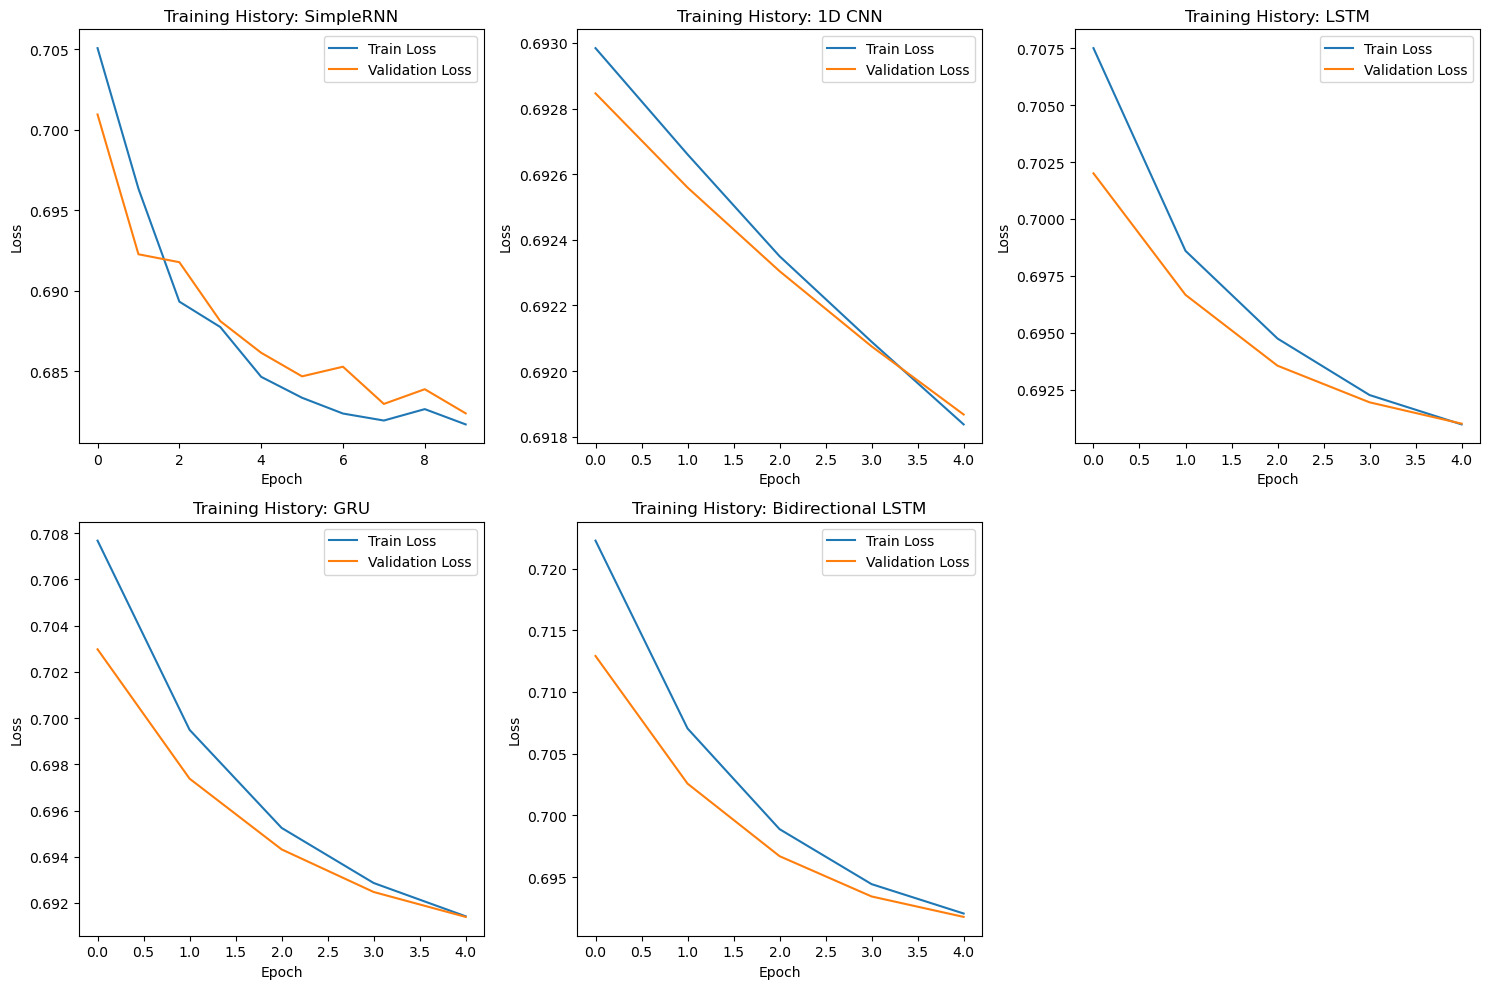

In [2]:
#002  TfidfVectorizer  NN
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, GRU, Bidirectional, GlobalAveragePooling1D, SimpleRNN
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import time
import numpy as np
import os
# Create directory to save figures if it doesn't exist
output_dir = "TFIDF_Tokenizer_NN"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# Load dataset
data = pd.read_csv('001_2802_merged_12000.csv')

# Data preprocessing
X = data['text']
y = data['label']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

# Reshape data for neural networks
X_train_nn = X_train_tfidf.reshape(X_train_tfidf.shape[0], X_train_tfidf.shape[1], 1)
X_test_nn = X_test_tfidf.reshape(X_test_tfidf.shape[0], X_test_tfidf.shape[1], 1)

# Check for NaN or Inf values in the data
print(f"NaN values in X_train: {np.isnan(X_train_nn).sum()}, Inf values in X_train: {np.isinf(X_train_nn).sum()}")
print(f"NaN values in X_test: {np.isnan(X_test_nn).sum()}, Inf values in X_test: {np.isinf(X_test_nn).sum()}")

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define the neural networks
def create_simplernn_model(input_shape):
    model = Sequential([
        SimpleRNN(128, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_cnn_model(input_shape):
    model = Sequential([
        Conv1D(128, 5, activation='relu', input_shape=input_shape),
        GlobalAveragePooling1D(),
        Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_gru_model(input_shape):
    model = Sequential([
        GRU(128, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_bilstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(128, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01))),
        Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Dictionary of neural network models
nn_models = {
    'SimpleRNN': create_simplernn_model(X_train_nn.shape[1:]),
    '1D CNN': create_cnn_model(X_train_nn.shape[1:]),
    'LSTM': create_lstm_model(X_train_nn.shape[1:]),
    'GRU': create_gru_model(X_train_nn.shape[1:]),
    'Bidirectional LSTM': create_bilstm_model(X_train_nn.shape[1:])
}

# Train and evaluate the neural networks
nn_results = {}
plt.figure(figsize=(10, 8))  # For ROC curve plotting

for name, model in nn_models.items():
    print(f"Training {name}...")
    start_time = time.time()
    history = model.fit(X_train_nn, y_train, epochs=10, validation_data=(X_test_nn, y_test), verbose=2, callbacks=[early_stopping])
    training_time = time.time() - start_time
    
    y_pred_proba = model.predict(X_test_nn).ravel()
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    nn_results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average=None),  # Per-class precision
        'recall': recall_score(y_test, y_pred, average=None),  # Per-class recall
        'f1': f1_score(y_test, y_pred, average=None),  # Per-class F1 score
        'auc': roc_auc_score(y_test, y_pred_proba),
        'training_time': training_time,
        'model_size': model.count_params(),
        'classification_report': classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], digits=3),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'roc_curve': (fpr, tpr),
        'history': history.history
    }
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {nn_results[name]["auc"]:.3f})')
    
    # Print report
    print(f"\n{name} Report:")
    print(f"Accuracy: {nn_results[name]['accuracy']:.3f}")
    print(f"Training Time: {nn_results[name]['training_time']:.3f} seconds")
    print(f"Model Size: {nn_results[name]['model_size']} parameters")
    print(f"Classification Report:\n{nn_results[name]['classification_report']}")
    print(f"AUC: {nn_results[name]['auc']:.3f}")
    print("\n" + "="*60 + "\n")

# Finalize and show the ROC plot
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='best')
roc_fig_path = os.path.join(output_dir, 'Model_Comparison_ROC.png')
plt.savefig(roc_fig_path)
plt.show()

# Plot Accuracy, Precision, Recall, F1 scores
metrics_df = pd.DataFrame({
    'Model': list(nn_results.keys()),
    'Accuracy': [nn_results[name]['accuracy'] for name in nn_results],
    'Precision': [nn_results[name]['precision'].mean() for name in nn_results],
    'Recall': [nn_results[name]['recall'].mean() for name in nn_results],
    'F1 Score': [nn_results[name]['f1'].mean() for name in nn_results]
})

metrics_df.set_index('Model').plot(kind='bar', figsize=(10, 8), color=['turquoise', 'pink', 'gray', 'olive'])
plt.title('Model Comparison on Accuracy, Precision, Recall, F1 Score')
plt.ylabel('Score')
plt.xticks(rotation=45)
metrics_fig_path = os.path.join(output_dir, 'Model_Comparison_Metrics.png')
plt.savefig(metrics_fig_path)
plt.show()

# Plot confusion matrices
plt.figure(figsize=(15, 10))
for i, (name, result) in enumerate(nn_results.items()):
    plt.subplot(2, 3, i + 1)
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
confusion_fig_path = os.path.join(output_dir, 'Model_Comparison_confusion.png')
plt.savefig(confusion_fig_path)
plt.tight_layout()
plt.show()

# Plot training history for each model
plt.figure(figsize=(15, 10))
for i, (name, result) in enumerate(nn_results.items()):
    plt.subplot(2, 3, i + 1)
    plt.plot(result['history']['loss'], label='Train Loss')
    plt.plot(result['history']['val_loss'], label='Validation Loss')
    plt.title(f'Training History: {name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

history_fig_path = os.path.join(output_dir, 'Model_Comparison_Training_history.png')
plt.savefig(history_fig_path)
plt.tight_layout()
plt.show()


NaN values in X_train: 0, Inf values in X_train: 0
NaN values in X_test: 0, Inf values in X_test: 0
Training Logistic Regression...

Logistic Regression Report:
Accuracy: 0.554
Training Time: 0.020 seconds
Model Size: 15 parameters (approx.)
Classification Report:
              precision    recall  f1-score   support

     Class 0      0.558     0.821     0.665       862
     Class 1      0.539     0.243     0.335       740

    accuracy                          0.554      1602
   macro avg      0.549     0.532     0.500      1602
weighted avg      0.549     0.554     0.513      1602

AUC: 0.571


Training SVM...

SVM Report:
Accuracy: 0.556
Training Time: 77.913 seconds
Model Size: 15 parameters (approx.)
Classification Report:
              precision    recall  f1-score   support

     Class 0      0.556     0.870     0.678       862
     Class 1      0.557     0.191     0.284       740

    accuracy                          0.556      1602
   macro avg      0.557     0.530     0.481

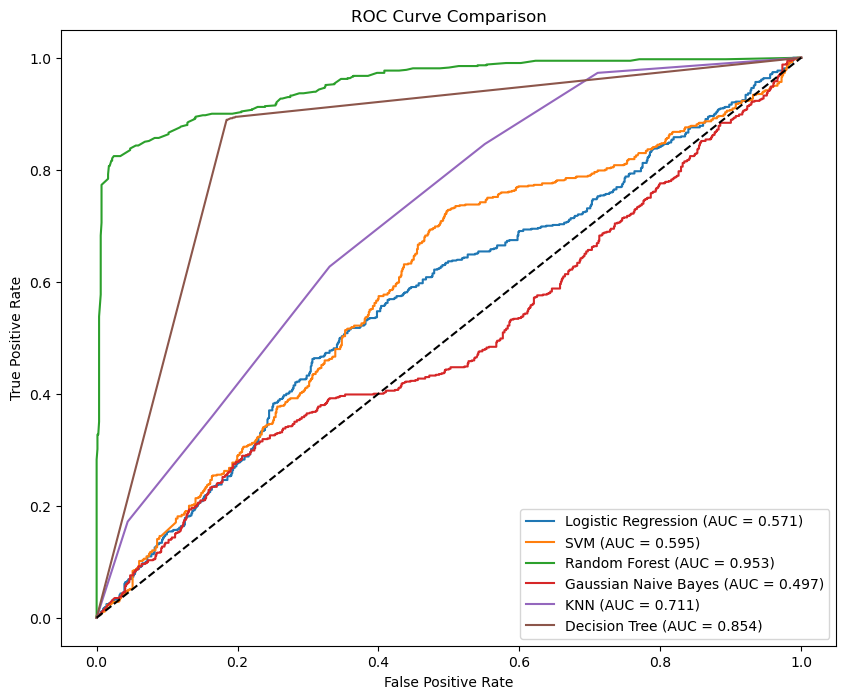

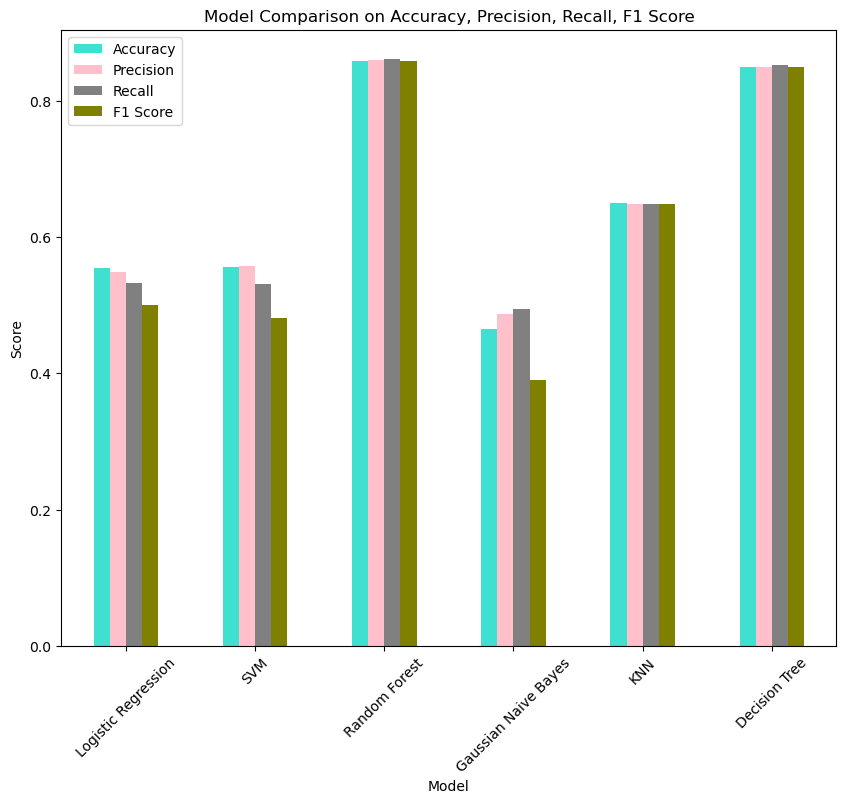

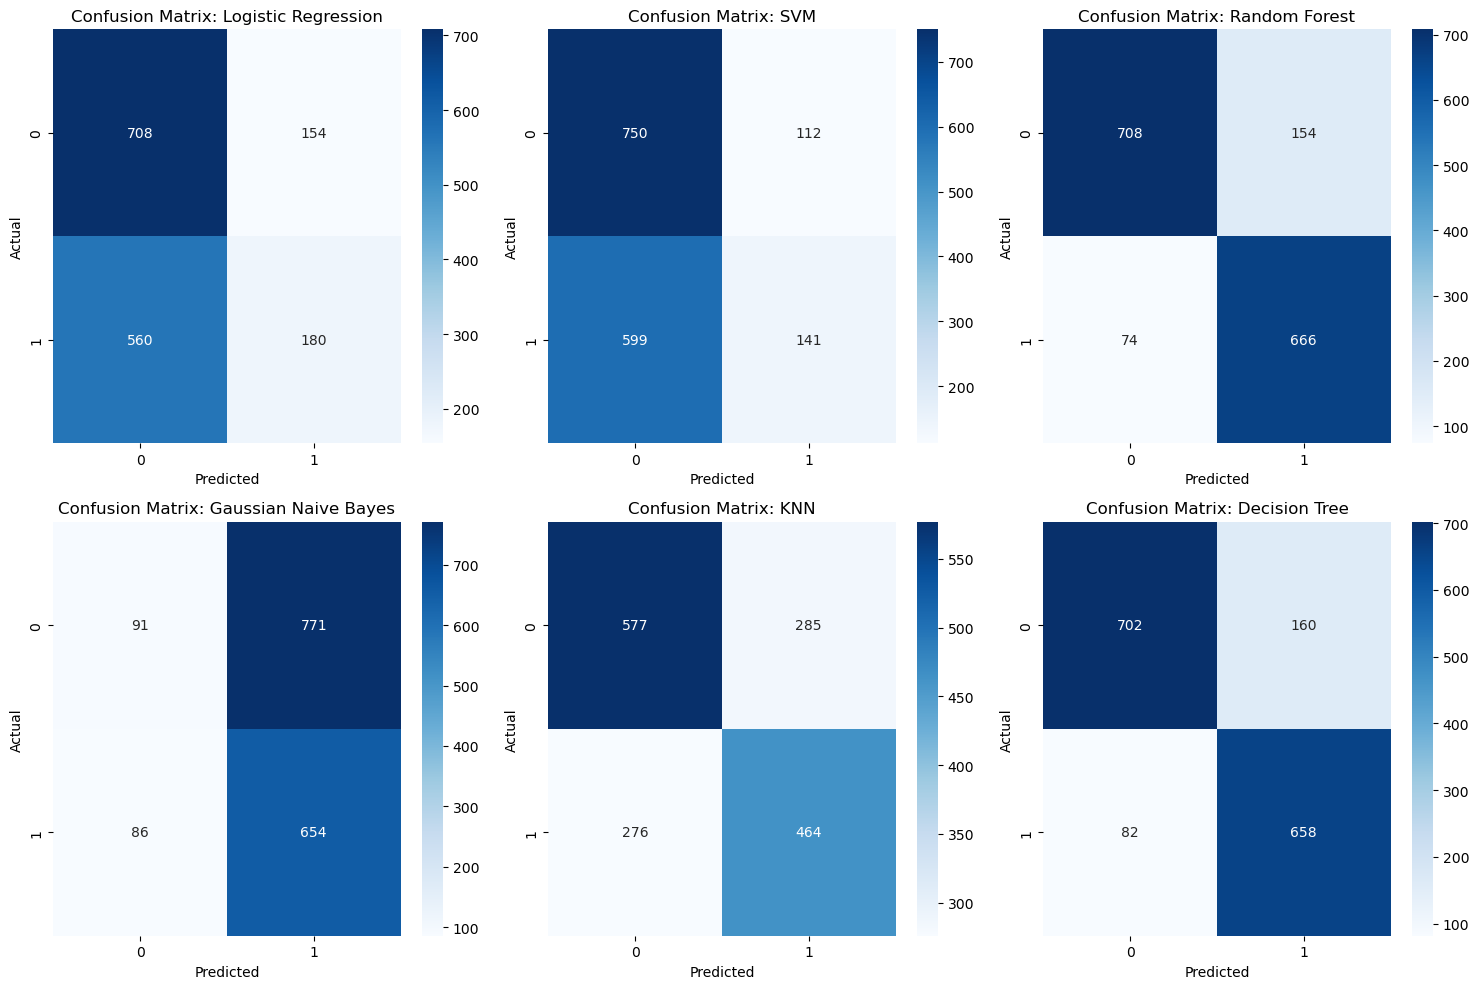

In [14]:
#003 keras_tonkenizer_ML

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
import time

# Create directory to save figures if it doesn't exist
output_dir = "keras.preprocessing_text_Tokenizer_ML"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Load dataset
data = pd.read_csv('001_2802_merged_12000.csv')

# Data preprocessing
X = data['text']
y = data['label']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use Tokenizer for text preprocessing
max_words = 5000  # Maximum number of words to keep, based on word frequency
max_len = 100  # Maximum length of the sequences (after padding)

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Check for NaN or Inf values in the data (optional)
print(f"NaN values in X_train: {np.isnan(X_train_pad).sum()}, Inf values in X_train: {np.isinf(X_train_pad).sum()}")
print(f"NaN values in X_test: {np.isnan(X_test_pad).sum()}, Inf values in X_test: {np.isinf(X_test_pad).sum()}")

# Scale the padded sequences
scaler = StandardScaler()
X_train_pad_scaled = scaler.fit_transform(X_train_pad)
X_test_pad_scaled = scaler.transform(X_test_pad)

# Define machine learning models with updated Logistic Regression
ml_models = {
    'Logistic Regression': LogisticRegression(
        penalty='l2', 
        C=1.0, 
        solver='lbfgs', 
        max_iter=1000,  # Increased number of iterations
        random_state=42
    ),
    'SVM': SVC(
        kernel='linear', 
        C=1.0, 
        probability=True, 
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, 
        max_depth=None, 
        random_state=42
    ),
    'Gaussian Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(
        n_neighbors=5, 
        weights='uniform', 
        algorithm='auto'
    ),
    'Decision Tree': DecisionTreeClassifier(
        criterion='gini',  # Function to measure the quality of a split
        max_depth=None,  # Maximum depth of the tree
        random_state=42  # Seed for random number generator
    )
}

# Train and evaluate the machine learning models
ml_results = {}
plt.figure(figsize=(10, 8))  # For ROC curve plotting

for name, model in ml_models.items():
    print(f"Training {name}...")
    start_time = time.time()
    model.fit(X_train_pad_scaled, y_train)
    training_time = time.time() - start_time
    
    y_pred_proba = model.predict_proba(X_test_pad_scaled)[:, 1]
    y_pred = model.predict(X_test_pad_scaled)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    ml_results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average=None),  # Per-class precision
        'recall': recall_score(y_test, y_pred, average=None),  # Per-class recall
        'f1': f1_score(y_test, y_pred, average=None),  # Per-class F1 score
        'auc': roc_auc_score(y_test, y_pred_proba),
        'training_time': training_time,
        'model_size': len(model.get_params()),  # Approximate, for comparison
        'classification_report': classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], digits=3),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'roc_curve': (fpr, tpr)
    }
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {ml_results[name]["auc"]:.3f})')
    
    # Print report
    print(f"\n{name} Report:")
    print(f"Accuracy: {ml_results[name]['accuracy']:.3f}")
    print(f"Training Time: {ml_results[name]['training_time']:.3f} seconds")
    print(f"Model Size: {ml_results[name]['model_size']} parameters (approx.)")
    print(f"Classification Report:\n{ml_results[name]['classification_report']}")
    print(f"AUC: {ml_results[name]['auc']:.3f}")
    print("\n" + "="*60 + "\n")

# Finalize and save the ROC plot
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='best')
roc_fig_path = os.path.join(output_dir, 'ROC_Curve_Comparison.png')
plt.savefig(roc_fig_path)
plt.show()

# Plot and save Accuracy, Precision, Recall, F1 scores
metrics_df = pd.DataFrame({
    'Model': list(ml_results.keys()),
    'Accuracy': [ml_results[name]['accuracy'] for name in ml_results],
    'Precision': [ml_results[name]['precision'].mean() for name in ml_results],
    'Recall': [ml_results[name]['recall'].mean() for name in ml_results],
    'F1 Score': [ml_results[name]['f1'].mean() for name in ml_results]
})

metrics_df.set_index('Model').plot(kind='bar', figsize=(10, 8), color=['turquoise', 'pink', 'gray', 'olive'])
plt.title('Model Comparison on Accuracy, Precision, Recall, F1 Score')
plt.ylabel('Score')
plt.xticks(rotation=45)
metrics_fig_path = os.path.join(output_dir, 'Model_Comparison_Metrics.png')
plt.savefig(metrics_fig_path)
plt.show()

# Plot and save confusion matrices
plt.figure(figsize=(15, 10))
for i, (name, result) in enumerate(ml_results.items()):
    plt.subplot(2, 3, i + 1)
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

plt.tight_layout()
confusion_matrices_fig_path = os.path.join(output_dir, 'Confusion_Matrices.png')
plt.savefig(confusion_matrices_fig_path)
plt.show()



NaN values in X_train: 0, Inf values in X_train: 0
NaN values in X_test: 0, Inf values in X_test: 0
Training SimpleRNN...
Epoch 1/10


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


201/201 - 3s - 13ms/step - accuracy: 0.5418 - loss: 0.9828 - val_accuracy: 0.5381 - val_loss: 0.6978
Epoch 2/10
201/201 - 2s - 8ms/step - accuracy: 0.5418 - loss: 0.6911 - val_accuracy: 0.5381 - val_loss: 0.6918
Epoch 3/10
201/201 - 2s - 8ms/step - accuracy: 0.5418 - loss: 0.6901 - val_accuracy: 0.5381 - val_loss: 0.6904
Epoch 4/10
201/201 - 2s - 8ms/step - accuracy: 0.5418 - loss: 0.6899 - val_accuracy: 0.5381 - val_loss: 0.6917
Epoch 5/10
201/201 - 2s - 10ms/step - accuracy: 0.5418 - loss: 0.6899 - val_accuracy: 0.5381 - val_loss: 0.6903
Epoch 6/10
201/201 - 2s - 8ms/step - accuracy: 0.5440 - loss: 0.6896 - val_accuracy: 0.5406 - val_loss: 0.6903
Epoch 7/10
201/201 - 2s - 8ms/step - accuracy: 0.5472 - loss: 0.6933 - val_accuracy: 0.5387 - val_loss: 0.7001
Epoch 8/10
201/201 - 2s - 8ms/step - accuracy: 0.5491 - loss: 0.6892 - val_accuracy: 0.5412 - val_loss: 0.6904
Epoch 9/10
201/201 - 2s - 8ms/step - accuracy: 0.5358 - loss: 0.7116 - val_accuracy: 0.5350 - val_loss: 0.6975
Epoch 10/1

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classifi

201/201 - 6s - 32ms/step - accuracy: 0.5407 - loss: 0.9881 - val_accuracy: 0.5381 - val_loss: 0.6919
Epoch 2/10
201/201 - 5s - 26ms/step - accuracy: 0.5418 - loss: 0.6902 - val_accuracy: 0.5381 - val_loss: 0.6905
Epoch 3/10
201/201 - 5s - 26ms/step - accuracy: 0.5418 - loss: 0.6899 - val_accuracy: 0.5381 - val_loss: 0.6903
Epoch 4/10
201/201 - 5s - 25ms/step - accuracy: 0.5418 - loss: 0.6898 - val_accuracy: 0.5381 - val_loss: 0.6904
Epoch 5/10
201/201 - 5s - 26ms/step - accuracy: 0.5418 - loss: 0.6899 - val_accuracy: 0.5381 - val_loss: 0.6904
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

GRU Report:
Accuracy: 0.538
Training Time: 27.432 seconds
Model Size: 739201 parameters
Classification Report:
              precision    recall  f1-score   support

     Class 0      0.538     1.000     0.700       862
     Class 1      0.000     0.000     0.000       740

    accuracy                          0.538      1602
   macro avg      0.269     0.500     0.350      1602
weighted avg      0.290     

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classifi

201/201 - 8s - 41ms/step - accuracy: 0.5669 - loss: 108285739008.0000 - val_accuracy: 0.5674 - val_loss: 0.9410
Epoch 2/10
201/201 - 7s - 32ms/step - accuracy: 0.6387 - loss: 0.9048 - val_accuracy: 0.6199 - val_loss: 0.8778
Epoch 3/10
201/201 - 6s - 32ms/step - accuracy: 0.7005 - loss: 0.8120 - val_accuracy: 0.6723 - val_loss: 0.7950
Epoch 4/10
201/201 - 6s - 32ms/step - accuracy: 0.7635 - loss: 2262769152.0000 - val_accuracy: 0.5262 - val_loss: 1.0468
Epoch 5/10
201/201 - 7s - 33ms/step - accuracy: 0.7371 - loss: 492217.0000 - val_accuracy: 0.6948 - val_loss: 1.0167
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

Bidirectional LSTM Report:
Accuracy: 0.567
Training Time: 34.378 seconds
Model Size: 903425 parameters
Classification Report:
              precision    recall  f1-score   support

     Class 0      0.556     0.971     0.707       862
     Class 1      0.742     0.097     0.172       740

    accuracy                          0.567      1602
   macro avg      0.649     0.534     0.4

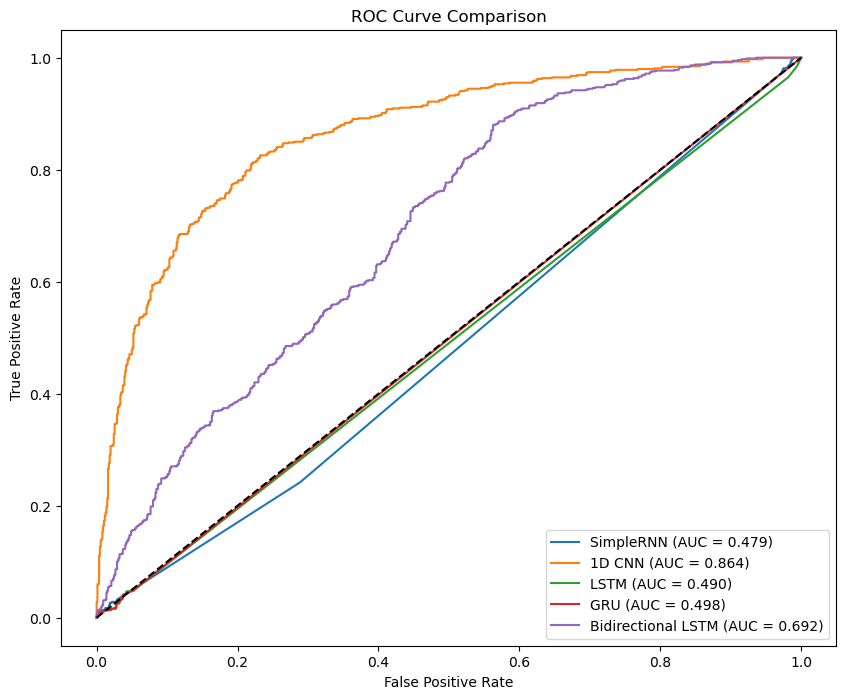

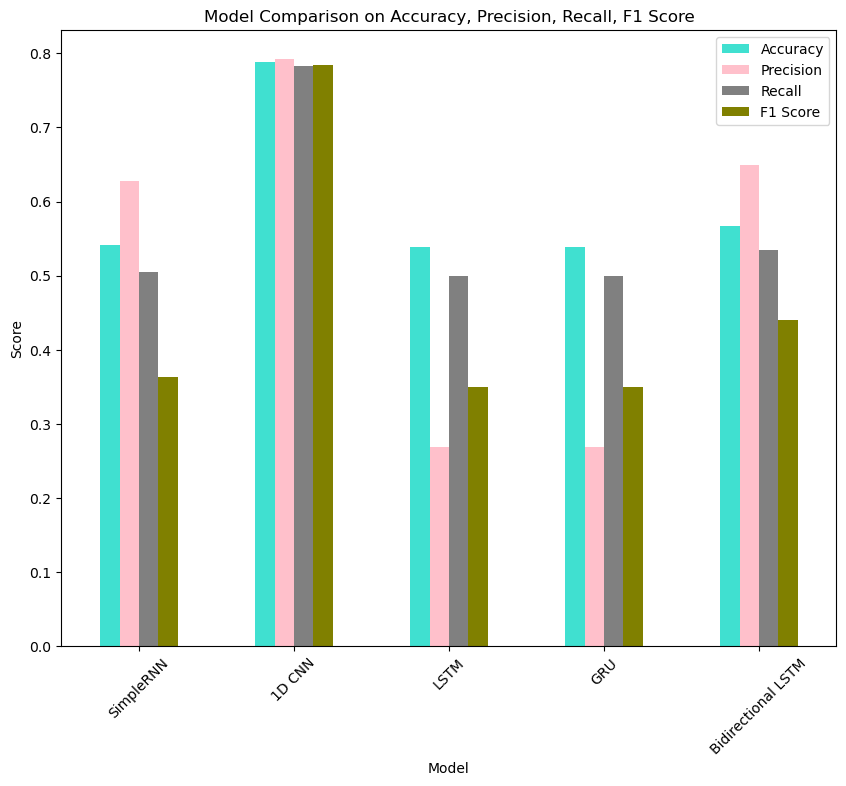

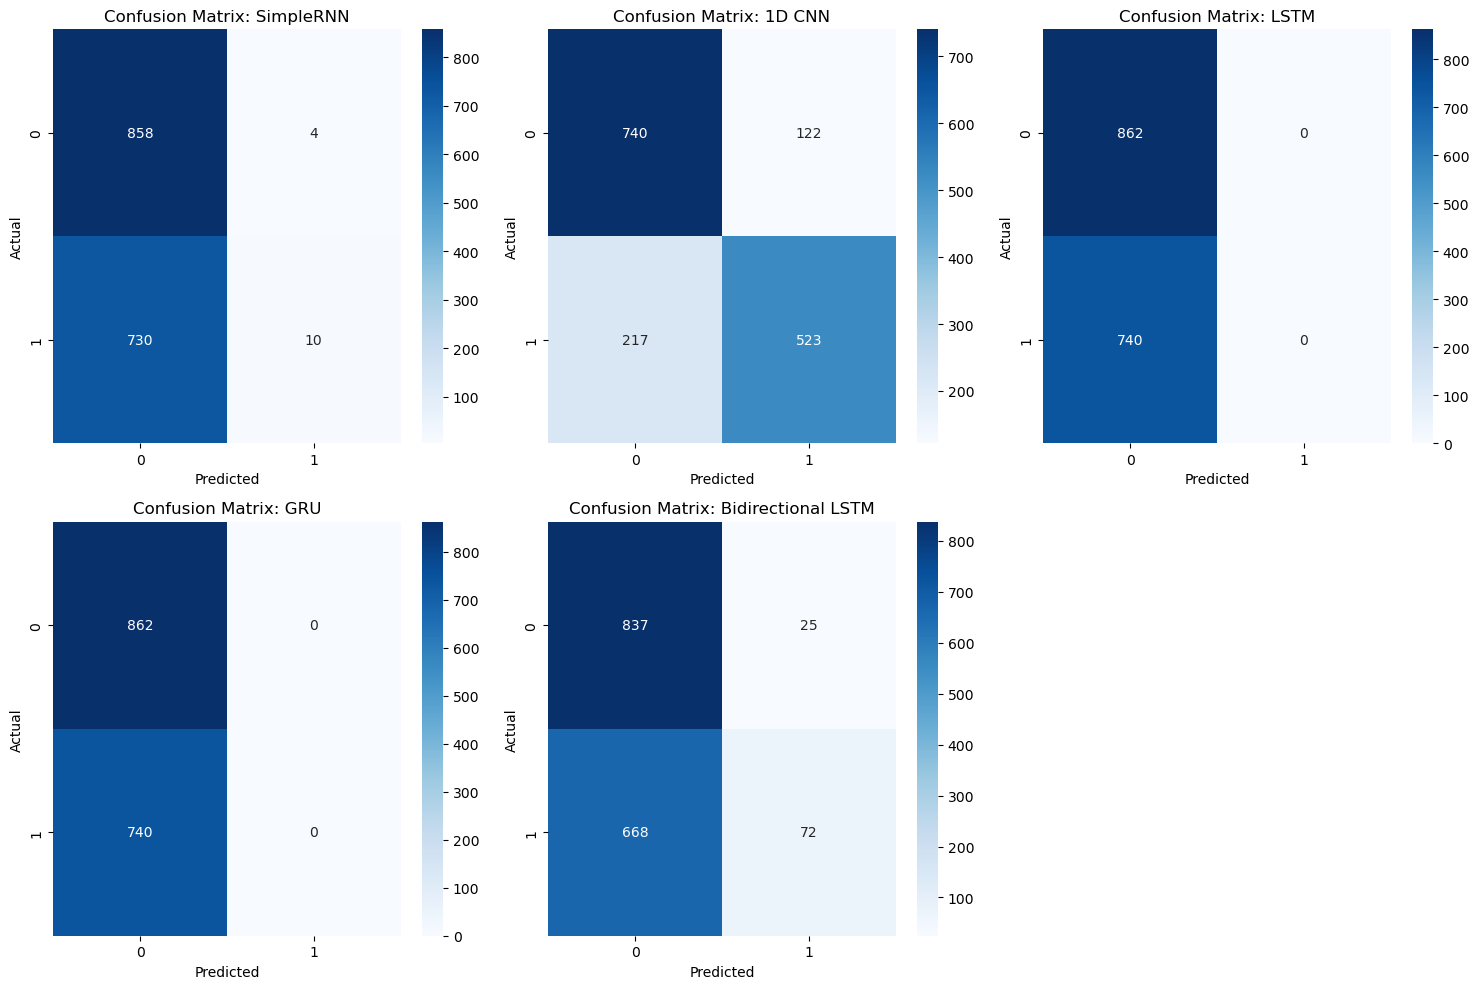

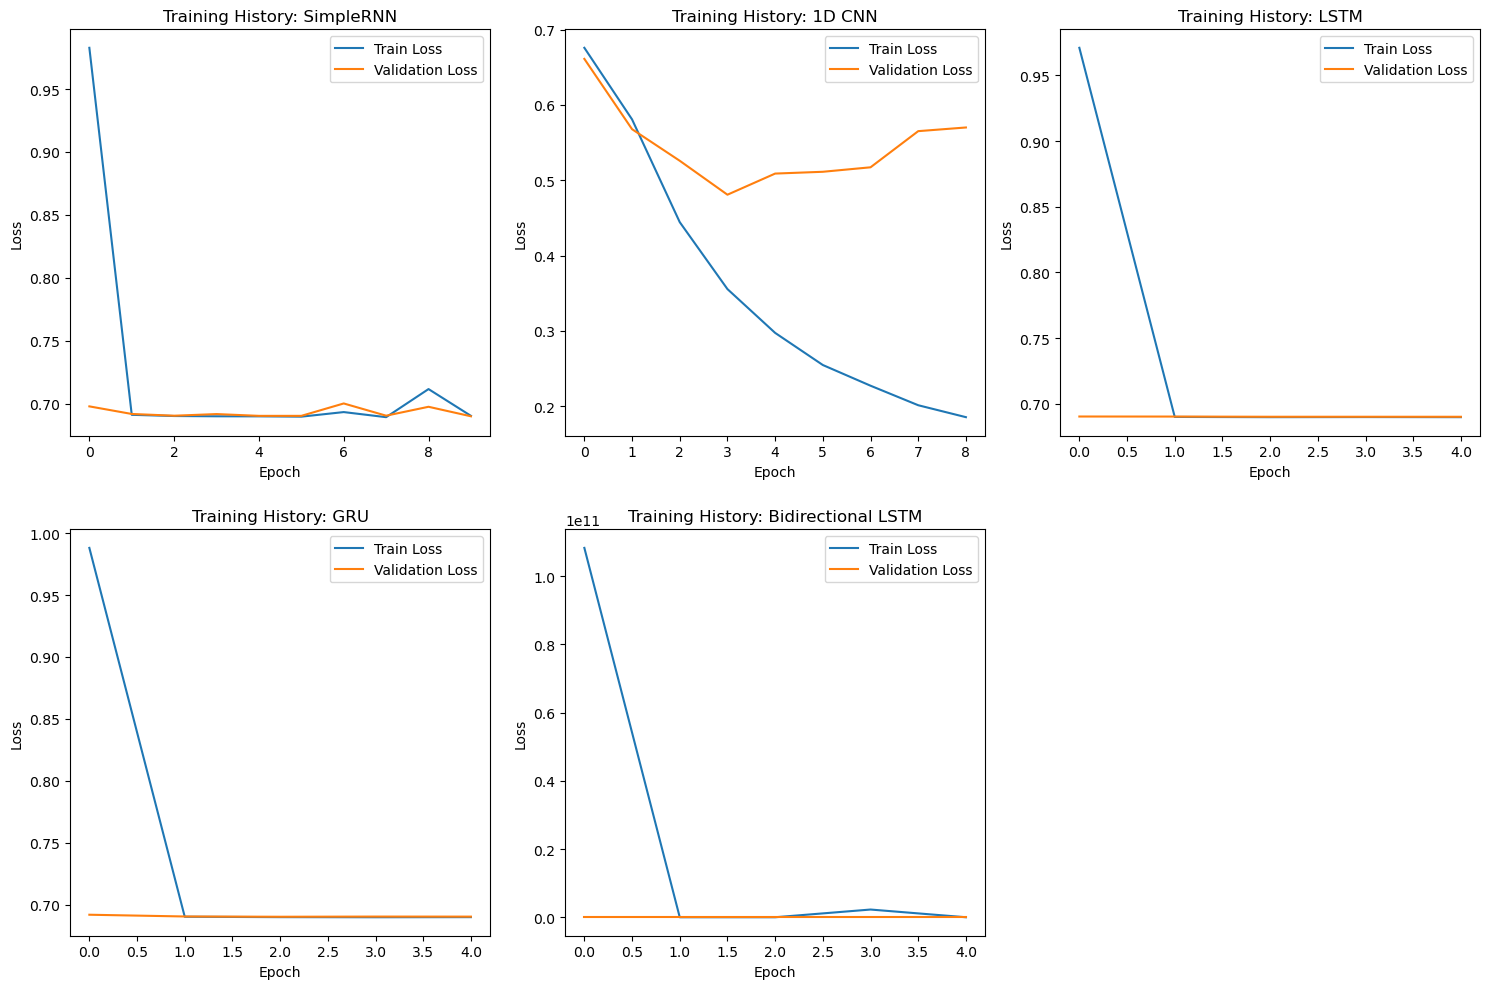

In [5]:
#004 keras tonkenizer  NN
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, GRU, Bidirectional, GlobalAveragePooling1D, SimpleRNN, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import time

# Create directory for saving plots
output_dir = 'Keras_tokenize_NN'
os.makedirs(output_dir, exist_ok=True)

# Load dataset
data = pd.read_csv('001_2802_merged_12000.csv')

# Data preprocessing
X = data['text']
y = data['label']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use Tokenizer for text preprocessing
max_words = 5000  # Maximum number of words to keep, based on word frequency
max_len = 100  # Maximum length of the sequences (after padding)

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Check for NaN or Inf values in the data (optional)
print(f"NaN values in X_train: {np.isnan(X_train_pad).sum()}, Inf values in X_train: {np.isinf(X_train_pad).sum()}")
print(f"NaN values in X_test: {np.isnan(X_test_pad).sum()}, Inf values in X_test: {np.isinf(X_test_pad).sum()}")

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define the neural networks
def create_simplernn_model(input_shape):
    model = Sequential([
        Embedding(max_words, 128, input_length=input_shape[0]),
        SimpleRNN(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_cnn_model(input_shape):
    model = Sequential([
        Embedding(max_words, 128, input_length=input_shape[0]),
        Conv1D(128, 5, activation='relu'),
        GlobalAveragePooling1D(),
        Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_lstm_model(input_shape):
    model = Sequential([
        Embedding(max_words, 128, input_length=input_shape[0]),
        LSTM(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_gru_model(input_shape):
    model = Sequential([
        Embedding(max_words, 128, input_length=input_shape[0]),
        GRU(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_bilstm_model(input_shape):
    model = Sequential([
        Embedding(max_words, 128, input_length=input_shape[0]),
        Bidirectional(LSTM(128, activation='relu', kernel_regularizer=l2(0.01))),
        Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Dictionary of neural network models
nn_models = {
    'SimpleRNN': create_simplernn_model(X_train_pad.shape[1:]),
    '1D CNN': create_cnn_model(X_train_pad.shape[1:]),
    'LSTM': create_lstm_model(X_train_pad.shape[1:]),
    'GRU': create_gru_model(X_train_pad.shape[1:]),
    'Bidirectional LSTM': create_bilstm_model(X_train_pad.shape[1:])
}

# Train and evaluate the neural networks
nn_results = {}
plt.figure(figsize=(10, 8))  # For ROC curve plotting

for name, model in nn_models.items():
    print(f"Training {name}...")
    start_time = time.time()
    history = model.fit(X_train_pad, y_train, epochs=10, validation_data=(X_test_pad, y_test), verbose=2, callbacks=[early_stopping])
    training_time = time.time() - start_time
    
    y_pred_proba = model.predict(X_test_pad).ravel()
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    nn_results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average=None),  # Per-class precision
        'recall': recall_score(y_test, y_pred, average=None),  # Per-class recall
        'f1': f1_score(y_test, y_pred, average=None),  # Per-class F1 score
        'auc': roc_auc_score(y_test, y_pred_proba),
        'training_time': training_time,
        'model_size': model.count_params(),
        'classification_report': classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], digits=3),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'roc_curve': (fpr, tpr),
        'history': history.history
    }
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {nn_results[name]["auc"]:.3f})')
    
    # Print report
    print(f"\n{name} Report:")
    print(f"Accuracy: {nn_results[name]['accuracy']:.3f}")
    print(f"Training Time: {nn_results[name]['training_time']:.3f} seconds")
    print(f"Model Size: {nn_results[name]['model_size']} parameters")
    print(f"Classification Report:\n{nn_results[name]['classification_report']}")
    print(f"AUC: {nn_results[name]['auc']:.3f}")
    print("\n" + "="*60 + "\n")

# Finalize and save the ROC plot
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='best')
roc_fig_path = os.path.join(output_dir, 'ROC_Curve_Comparison.png')
plt.savefig(roc_fig_path)
plt.show()

# Plot and save Accuracy, Precision, Recall, F1 scores
metrics_df = pd.DataFrame({
    'Model': list(nn_results.keys()),
    'Accuracy': [nn_results[name]['accuracy'] for name in nn_results],
    'Precision': [nn_results[name]['precision'].mean() for name in nn_results],
    'Recall': [nn_results[name]['recall'].mean() for name in nn_results],
    'F1 Score': [nn_results[name]['f1'].mean() for name in nn_results]
})

metrics_df.set_index('Model').plot(kind='bar', figsize=(10, 8), color=['turquoise', 'pink', 'gray', 'olive'])
plt.title('Model Comparison on Accuracy, Precision, Recall, F1 Score')
plt.ylabel('Score')
plt.xticks(rotation=45)
metrics_fig_path = os.path.join(output_dir, 'Model_Comparison_Metrics.png')
plt.savefig(metrics_fig_path)
plt.show()

# Plot and save confusion matrices
plt.figure(figsize=(15, 10))
for i, (name, result) in enumerate(nn_results.items()):
    plt.subplot(2, 3, i + 1)
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

plt.tight_layout()
confusion_matrices_fig_path = os.path.join(output_dir, 'Confusion_Matrices.png')
plt.savefig(confusion_matrices_fig_path)
plt.show()

# Plot and save training history for each model
plt.figure(figsize=(15, 10))
for i, (name, result) in enumerate(nn_results.items()):
    plt.subplot(2, 3, i + 1)
    plt.plot(result['history']['loss'], label='Train Loss')
    plt.plot(result['history']['val_loss'], label='Validation Loss')
    plt.title(f'Training History: {name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

plt.tight_layout()
training_history_fig_path = os.path.join(output_dir, 'Training_History.png')
plt.savefig(training_history_fig_path)
plt.show()

Training Keras Tokenizer + 1DCNN...
Epoch 1/30


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

201/201 ━━━━━━━━━━━━━━━━━━━━ 50s 244ms/step - accuracy: 0.5406 - loss: 0.6890 - val_accuracy: 0.5905 - val_loss: 0.6861
Epoch 2/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 48s 241ms/step - accuracy: 0.5800 - loss: 0.6716 - val_accuracy: 0.6217 - val_loss: 0.6605
Epoch 3/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 51s 254ms/step - accuracy: 0.6532 - loss: 0.6326 - val_accuracy: 0.6467 - val_loss: 0.6372
Epoch 4/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 50s 251ms/step - accuracy: 0.6934 - loss: 0.5943 - val_accuracy: 0.6604 - val_loss: 0.6178
Epoch 5/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 51s 254ms/step - accuracy: 0.7346 - loss: 0.5455 - val_accuracy: 0.6873 - val_loss: 0.5938
Epoch 6/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 46s 227ms/step - accuracy: 0.7822 - loss: 0.4813 - val_accuracy: 0.6879 - val_loss: 0.5892
Epoch 7/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 51s 255ms/step - accuracy: 0.8159 - loss: 0.4238 - val_accuracy: 0.6979 - val_loss: 0.5742
Epoch 8/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 52s 260ms/step - accuracy: 0.8469 - loss: 0.3792 - val

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classifi

201/201 ━━━━━━━━━━━━━━━━━━━━ 33s 152ms/step - accuracy: 0.5391 - loss: 0.6910 - val_accuracy: 0.5381 - val_loss: 0.6906
Epoch 2/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 26s 129ms/step - accuracy: 0.5352 - loss: 0.6912 - val_accuracy: 0.5381 - val_loss: 0.6905
Epoch 3/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 28s 141ms/step - accuracy: 0.5397 - loss: 0.6898 - val_accuracy: 0.5381 - val_loss: 0.6906
Epoch 4/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 28s 138ms/step - accuracy: 0.5431 - loss: 0.6897 - val_accuracy: 0.5381 - val_loss: 0.6905
Epoch 5/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 29s 146ms/step - accuracy: 0.5427 - loss: 0.6901 - val_accuracy: 0.5381 - val_loss: 0.6905
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
Training Keras Tokenizer + BiLSTM...
Epoch 1/30


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classifi

201/201 ━━━━━━━━━━━━━━━━━━━━ 85s 404ms/step - accuracy: 0.5672 - loss: 0.6775 - val_accuracy: 0.6124 - val_loss: 0.6492
Epoch 2/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 89s 443ms/step - accuracy: 0.6308 - loss: 0.6376 - val_accuracy: 0.6629 - val_loss: 0.6155
Epoch 3/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 89s 443ms/step - accuracy: 0.6929 - loss: 0.5812 - val_accuracy: 0.7091 - val_loss: 0.5679
Epoch 4/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 103s 513ms/step - accuracy: 0.7686 - loss: 0.4977 - val_accuracy: 0.7372 - val_loss: 0.5307
Epoch 5/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 106s 526ms/step - accuracy: 0.8213 - loss: 0.4028 - val_accuracy: 0.7628 - val_loss: 0.5026
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step


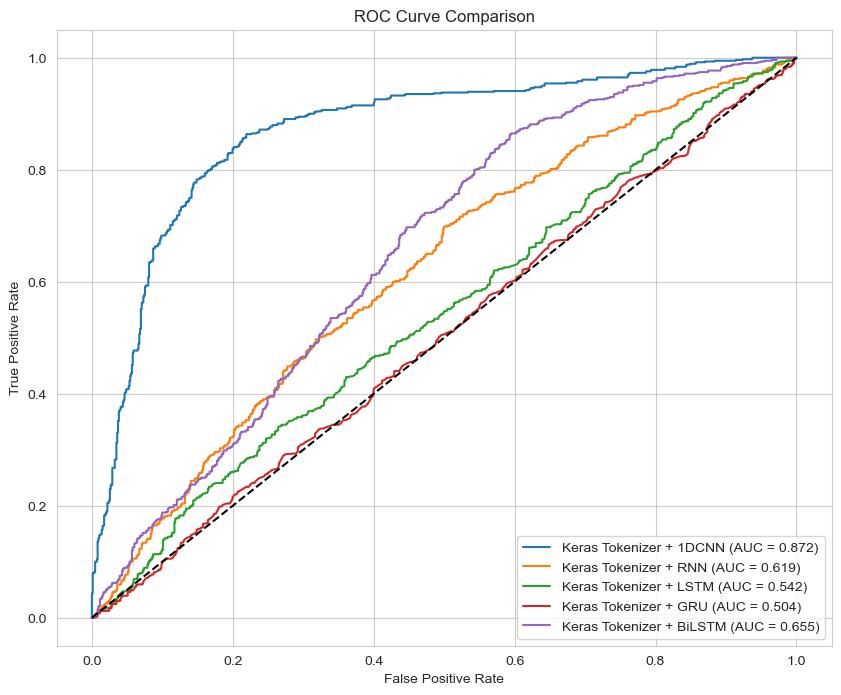


Keras Tokenizer + 1DCNN Report:
Accuracy: 0.816
Training Time: 869.277 seconds
Model Size: 828929 parameters
Classification Report:
              precision    recall  f1-score   support

     Class 0      0.853     0.796     0.824       862
     Class 1      0.779     0.841     0.809       740

    accuracy                          0.816      1602
   macro avg      0.816     0.818     0.816      1602
weighted avg      0.819     0.816     0.817      1602

AUC: 0.872



Keras Tokenizer + RNN Report:
Accuracy: 0.587
Training Time: 43.534 seconds
Model Size: 730625 parameters
Classification Report:
              precision    recall  f1-score   support

     Class 0      0.589     0.769     0.667       862
     Class 1      0.582     0.374     0.456       740

    accuracy                          0.587      1602
   macro avg      0.585     0.572     0.561      1602
weighted avg      0.586     0.587     0.569      1602

AUC: 0.619



Keras Tokenizer + LSTM Report:
Accuracy: 0.538
Training 

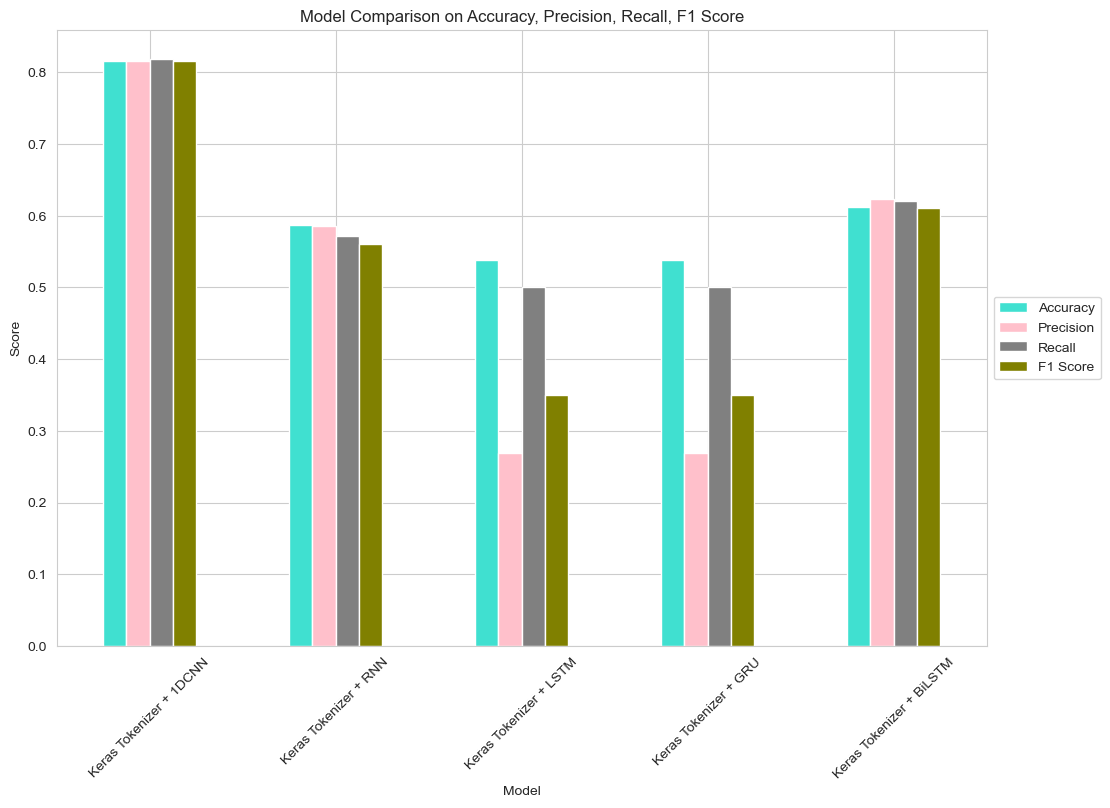

In [29]:
#004 keras tonkenizer  NN_improved
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout, SimpleRNN, LSTM, GRU, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Create directory for saving plots
output_dir = 'Keras_tokenize_NN_better'
os.makedirs(output_dir, exist_ok=True)

# Load dataset
data = pd.read_csv('001_2802_merged_12000.csv')

# Data preprocessing
X = data['text']
y = data['label']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 1. Keras Tokenizer
max_words = 5000  # Maximum number of words to keep, based on word frequency
max_len = 100  # Maximum length of the sequences (after padding)

keras_tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
keras_tokenizer.fit_on_texts(X_train)

X_train_keras = keras_tokenizer.texts_to_sequences(X_train)
X_test_keras = keras_tokenizer.texts_to_sequences(X_test)

X_train_keras_pad = pad_sequences(X_train_keras, maxlen=max_len, padding='post', truncating='post')
X_test_keras_pad = pad_sequences(X_test_keras, maxlen=max_len, padding='post', truncating='post')

# Define the model architecture
def create_model(model_type, input_shape, use_embedding=False, vocab_size=None):
    model = Sequential()
    
    if use_embedding:  # For Keras Tokenizer with integer sequences
        model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=input_shape[0]))
    
    if model_type == '1DCNN':
        model.add(Conv1D(128, 5, activation='relu', input_shape=input_shape))
        model.add(Dropout(0.5))
        model.add(Conv1D(128, 5, activation='relu'))
        model.add(GlobalMaxPooling1D())
    elif model_type == 'RNN':
        model.add(SimpleRNN(128, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.5))
        model.add(SimpleRNN(128))
    elif model_type == 'LSTM':
        model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.5))
        model.add(LSTM(128))
    elif model_type == 'GRU':
        model.add(GRU(128, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.5))
        model.add(GRU(128))
    elif model_type == 'BiLSTM':
        model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
        model.add(Dropout(0.5))
        model.add(Bidirectional(LSTM(128)))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid', dtype='float32'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Models dictionary
models = ['1DCNN', 'RNN', 'LSTM', 'GRU', 'BiLSTM']

model_variants = {
    'Keras Tokenizer + 1DCNN': create_model('1DCNN', X_train_keras_pad.shape[1:], use_embedding=True, vocab_size=max_words),
    'Keras Tokenizer + RNN': create_model('RNN', X_train_keras_pad.shape[1:], use_embedding=True, vocab_size=max_words),
    'Keras Tokenizer + LSTM': create_model('LSTM', X_train_keras_pad.shape[1:], use_embedding=True, vocab_size=max_words),
    'Keras Tokenizer + GRU': create_model('GRU', X_train_keras_pad.shape[1:], use_embedding=True, vocab_size=max_words),
    'Keras Tokenizer + BiLSTM': create_model('BiLSTM', X_train_keras_pad.shape[1:], use_embedding=True, vocab_size=max_words)
}

# Train and evaluate models
def train_and_evaluate_models(models, X_train_dict, y_train, X_test_dict, y_test):
    results = {}
    plt.figure(figsize=(10, 8))  # For ROC curve plotting

    for name, model in models.items():
        print(f"Training {name}...")

        # Get the corresponding training and test data
        X_train = X_train_dict[name]
        X_test = X_test_dict[name]

        start_time = time.time()
        
        # Train the model
        history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_stopping])
        training_time = time.time() - start_time
        
        # Make predictions
        y_pred_proba = model.predict(X_test).ravel()
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        # Calculate metrics
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average=None)
        recall = recall_score(y_test, y_pred, average=None)
        f1 = f1_score(y_test, y_pred, average=None)
        auc = roc_auc_score(y_test, y_pred_proba)
        model_size = model.count_params()

        # Store results
        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc,
            'training_time': training_time,
            'model_size': model_size,
            'classification_report': classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], digits=3),
            'roc_curve': (fpr, tpr),
            'history': history.history
        }

        # Plot ROC curve for each model
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

    # Finalize and save the combined ROC plot
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc='best')
    plt.savefig(os.path.join(output_dir, 'Combined_ROC_Curve.png'))
    plt.show()

    # Print report for each model
    for name, result in results.items():
        print(f"\n{name} Report:")
        print(f"Accuracy: {result['accuracy']:.3f}")
        print(f"Training Time: {result['training_time']:.3f} seconds")
        print(f"Model Size: {result['model_size']} parameters")
        print(f"Classification Report:\n{result['classification_report']}")
        print(f"AUC: {result['auc']:.3f}")
        print("\n" + "="*60 + "\n")

    # Plot Accuracy, Precision, Recall, F1 scores and save the plot
    metrics_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Accuracy': [results[name]['accuracy'] for name in results],
        'Precision': [results[name]['precision'].mean() for name in results],
        'Recall': [results[name]['recall'].mean() for name in results],
        'F1 Score': [results[name]['f1'].mean() for name in results]
    })

    metrics_df.set_index('Model').plot(kind='bar', figsize=(12, 8), color=['turquoise', 'pink', 'gray', 'olive'])
    plt.title('Model Comparison on Accuracy, Precision, Recall, F1 Score')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(os.path.join(output_dir, 'Model_Comparison_Accuracy_Precision_Recall_F1.png'))
    plt.show()

# Run the training and evaluation for all models
train_and_evaluate_models(
    model_variants, 
    {
        'Keras Tokenizer + 1DCNN': X_train_keras_pad, 
        'Keras Tokenizer + RNN': X_train_keras_pad, 
        'Keras Tokenizer + LSTM': X_train_keras_pad, 
        'Keras Tokenizer + GRU': X_train_keras_pad, 
        'Keras Tokenizer + BiLSTM': X_train_keras_pad
    }, 
    y_train, 
    {
        'Keras Tokenizer + 1DCNN': X_test_keras_pad, 
        'Keras Tokenizer + RNN': X_test_keras_pad, 
        'Keras Tokenizer + LSTM': X_test_keras_pad, 
        'Keras Tokenizer + GRU': X_test_keras_pad, 
        'Keras Tokenizer + BiLSTM': X_test_keras_pad
    }, 
    y_test
)


C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- Thi

Training Logistic Regression...


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Report:
Accuracy: 0.698
Training Time: 0.405 seconds
Classification Report:
              precision    recall  f1-score   support

     Class 0      0.717     0.724     0.721       862
     Class 1      0.675     0.668     0.671       740

    accuracy                          0.698      1602
   macro avg      0.696     0.696     0.696      1602
weighted avg      0.698     0.698     0.698      1602

AUC: 0.768


Training SVM...

SVM Report:
Accuracy: 0.728
Training Time: 61.942 seconds
Classification Report:
              precision    recall  f1-score   support

     Class 0      0.753     0.735     0.744       862
     Class 1      0.700     0.719     0.709       740

    accuracy                          0.728      1602
   macro avg      0.726     0.727     0.727      1602
weighted avg      0.729     0.728     0.728      1602

AUC: 0.773


Training Random Forest...

Random Forest Report:
Accuracy: 0.871
Training Time: 1.931 seconds
Classification Report:
        

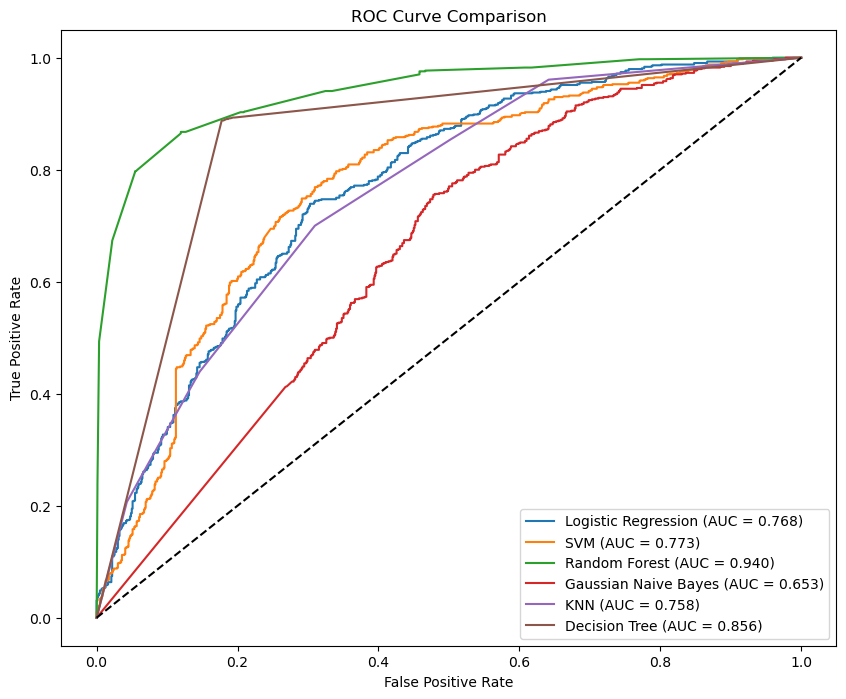

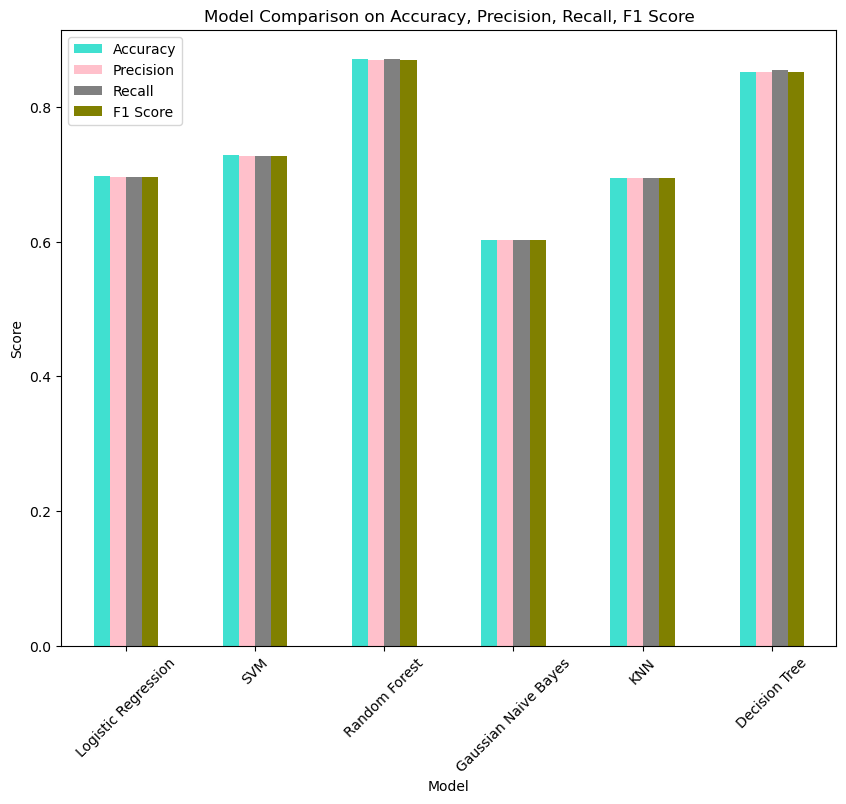

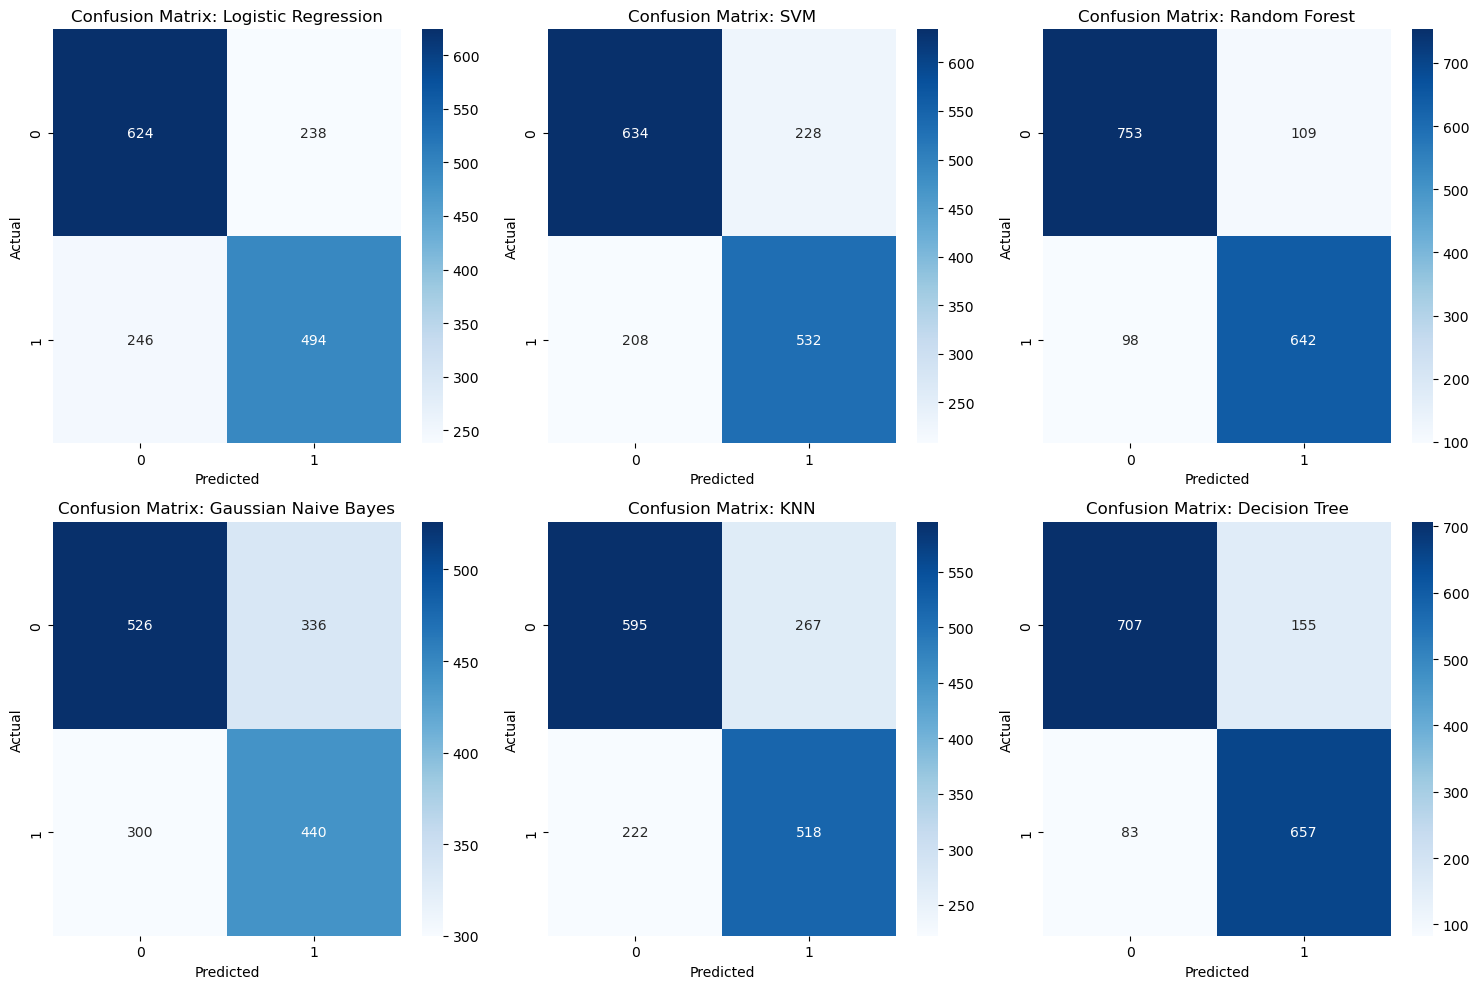

In [11]:
#005 BERT embeddings with ML
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from transformers import BertTokenizer, TFBertModel
import time
from sklearn.tree import DecisionTreeClassifier
# Create directory for saving plots
output_dir = 'BERT_embeddings_ML'
os.makedirs(output_dir, exist_ok=True)

# Load dataset
data = pd.read_csv('001_2802_merged_12000.csv')

# Data preprocessing
X = data['text']
y = data['label']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Tokenize and encode sequences using BERT tokenizer
def tokenize_and_encode(texts, max_len=64):
    inputs = tokenizer(
        texts.tolist(),
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    return inputs

X_train_encoded = tokenize_and_encode(X_train)
X_test_encoded = tokenize_and_encode(X_test)

# Generate embeddings using BERT
def generate_embeddings(bert_model, encoded_inputs):
    outputs = bert_model(encoded_inputs['input_ids'], attention_mask=encoded_inputs['attention_mask'])
    return outputs.last_hidden_state[:, 0, :]  # Use [CLS] token embeddings

X_train_emb = generate_embeddings(bert_model, X_train_encoded).numpy()
X_test_emb = generate_embeddings(bert_model, X_test_encoded).numpy()

# Define machine learning models
ml_models = {
    'Logistic Regression': LogisticRegression(
        penalty='l2', 
        C=1.0, 
        solver='lbfgs', 
        max_iter=100, 
        random_state=42
    ),
    'SVM': SVC(
        kernel='linear', 
        C=1.0, 
        probability=True, 
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=10, 
        max_depth=None, 
        random_state=42
    ),
    'Gaussian Naive Bayes': GaussianNB(
        priors=None, 
        var_smoothing=1e-9
    ),
    'KNN': KNeighborsClassifier(
        n_neighbors=5, 
        weights='uniform', 
        algorithm='auto'
    ),
    'Decision Tree': DecisionTreeClassifier(
        criterion='gini',  # Function to measure the quality of a split
        max_depth=None,  # Maximum depth of the tree
        random_state=42  # Seed for random number generator
    )
}

# Train and evaluate the machine learning models
ml_results = {}
plt.figure(figsize=(10, 8))  # For ROC curve plotting

for name, model in ml_models.items():
    print(f"Training {name}...")
    start_time = time.time()
    model.fit(X_train_emb, y_train)
    training_time = time.time() - start_time
    
    y_pred_proba = model.predict_proba(X_test_emb)[:, 1]  # Probability estimates
    y_pred = model.predict(X_test_emb)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    ml_results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average=None),  # Per-class precision
        'recall': recall_score(y_test, y_pred, average=None),  # Per-class recall
        'f1': f1_score(y_test, y_pred, average=None),  # Per-class F1 score
        'auc': roc_auc_score(y_test, y_pred_proba),
        'training_time': training_time,
        'classification_report': classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], digits=3),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'roc_curve': (fpr, tpr)
    }
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {ml_results[name]["auc"]:.3f})')
    
    # Print report
    print(f"\n{name} Report:")
    print(f"Accuracy: {ml_results[name]['accuracy']:.3f}")
    print(f"Training Time: {ml_results[name]['training_time']:.3f} seconds")
    print(f"Classification Report:\n{ml_results[name]['classification_report']}")
    print(f"AUC: {ml_results[name]['auc']:.3f}")
    print("\n" + "="*60 + "\n")

# Finalize and save the ROC plot
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='best')
plt.savefig(os.path.join(output_dir, 'ROC_Curve_Comparison.png'))
plt.show()

# Plot Accuracy, Precision, Recall, F1 scores
metrics_df = pd.DataFrame({
    'Model': list(ml_results.keys()),
    'Accuracy': [ml_results[name]['accuracy'] for name in ml_results],
    'Precision': [ml_results[name]['precision'].mean() for name in ml_results],
    'Recall': [ml_results[name]['recall'].mean() for name in ml_results],
    'F1 Score': [ml_results[name]['f1'].mean() for name in ml_results]
})

metrics_df.set_index('Model').plot(kind='bar', figsize=(10, 8), color= ['turquoise', 'pink', 'gray', 'olive'])
plt.title('Model Comparison on Accuracy, Precision, Recall, F1 Score')
plt.ylabel('Score')
plt.xticks(rotation=45)

# Save the model comparison plot
plt.savefig(os.path.join(output_dir, 'Model_Comparison_Scores.png'))
plt.show()

# Plot confusion matrices
plt.figure(figsize=(15, 10))
for i, (name, result) in enumerate(ml_results.items()):
    plt.subplot(2, 3, i + 1)
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

plt.tight_layout()

# Save the confusion matrices plot
plt.savefig(os.path.join(output_dir, 'Confusion_Matrices.png'))
plt.show()


C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Training 1D CNN...
Epoch 1/30


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


401/401 - 43s - 108ms/step - accuracy: 0.6790 - loss: 0.5920 - val_accuracy: 0.7222 - val_loss: 0.5510
Epoch 2/30
401/401 - 42s - 106ms/step - accuracy: 0.7980 - loss: 0.4503 - val_accuracy: 0.7790 - val_loss: 0.4826
Epoch 3/30
401/401 - 42s - 105ms/step - accuracy: 0.8974 - loss: 0.3086 - val_accuracy: 0.8352 - val_loss: 0.3976
Epoch 4/30
401/401 - 42s - 104ms/step - accuracy: 0.9508 - loss: 0.1869 - val_accuracy: 0.8783 - val_loss: 0.3480
Epoch 5/30
401/401 - 40s - 101ms/step - accuracy: 0.9744 - loss: 0.1135 - val_accuracy: 0.8914 - val_loss: 0.3206
Epoch 6/30
401/401 - 40s - 100ms/step - accuracy: 0.9850 - loss: 0.0780 - val_accuracy: 0.8851 - val_loss: 0.3056
Epoch 7/30
401/401 - 40s - 100ms/step - accuracy: 0.9866 - loss: 0.0632 - val_accuracy: 0.8976 - val_loss: 0.3151
Epoch 8/30
401/401 - 40s - 101ms/step - accuracy: 0.9891 - loss: 0.0581 - val_accuracy: 0.8627 - val_loss: 0.3870
Epoch 9/30
401/401 - 41s - 102ms/step - accuracy: 0.9897 - loss: 0.0554 - val_accuracy: 0.8670 - va

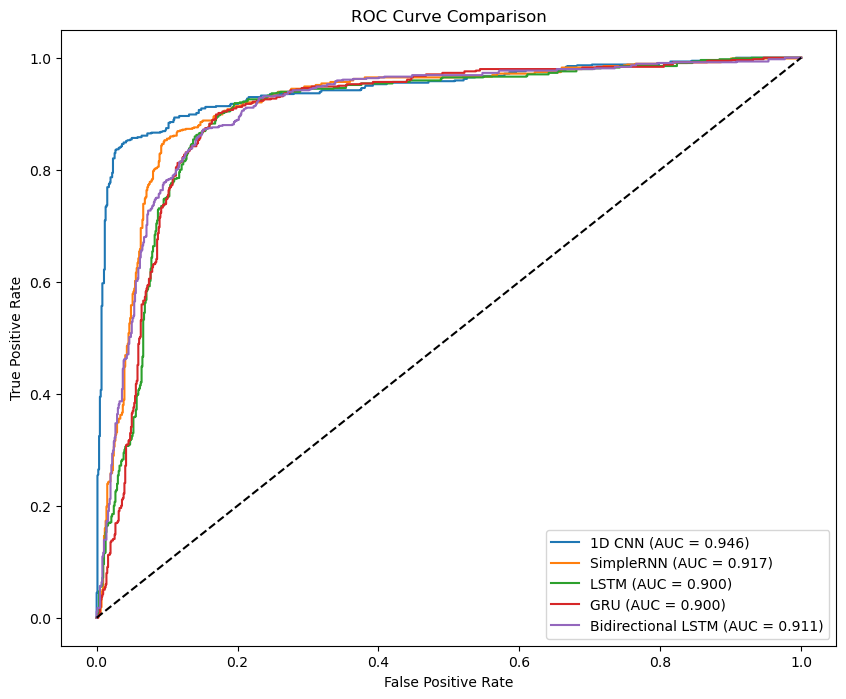


1D CNN Report:
Accuracy: 0.896
Training Time: 1274.329 seconds
Model Size: 508289 parameters
Classification Report:
              precision    recall  f1-score   support

     Class 0      0.888     0.923     0.906       862
     Class 1      0.907     0.865     0.885       740

    accuracy                          0.896      1602
   macro avg      0.897     0.894     0.895      1602
weighted avg      0.897     0.896     0.896      1602

AUC: 0.946



SimpleRNN Report:
Accuracy: 0.865
Training Time: 213.803 seconds
Model Size: 114945 parameters
Classification Report:
              precision    recall  f1-score   support

     Class 0      0.898     0.846     0.871       862
     Class 1      0.832     0.888     0.859       740

    accuracy                          0.865      1602
   macro avg      0.865     0.867     0.865      1602
weighted avg      0.867     0.865     0.865      1602

AUC: 0.917



LSTM Report:
Accuracy: 0.855
Training Time: 730.680 seconds
Model Size: 459393 para

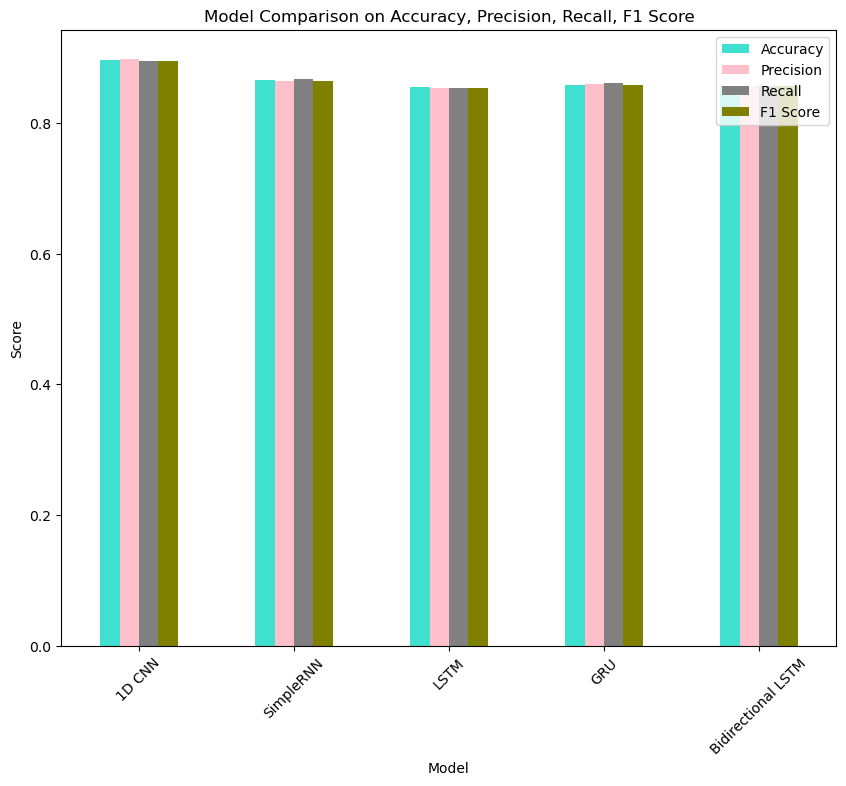

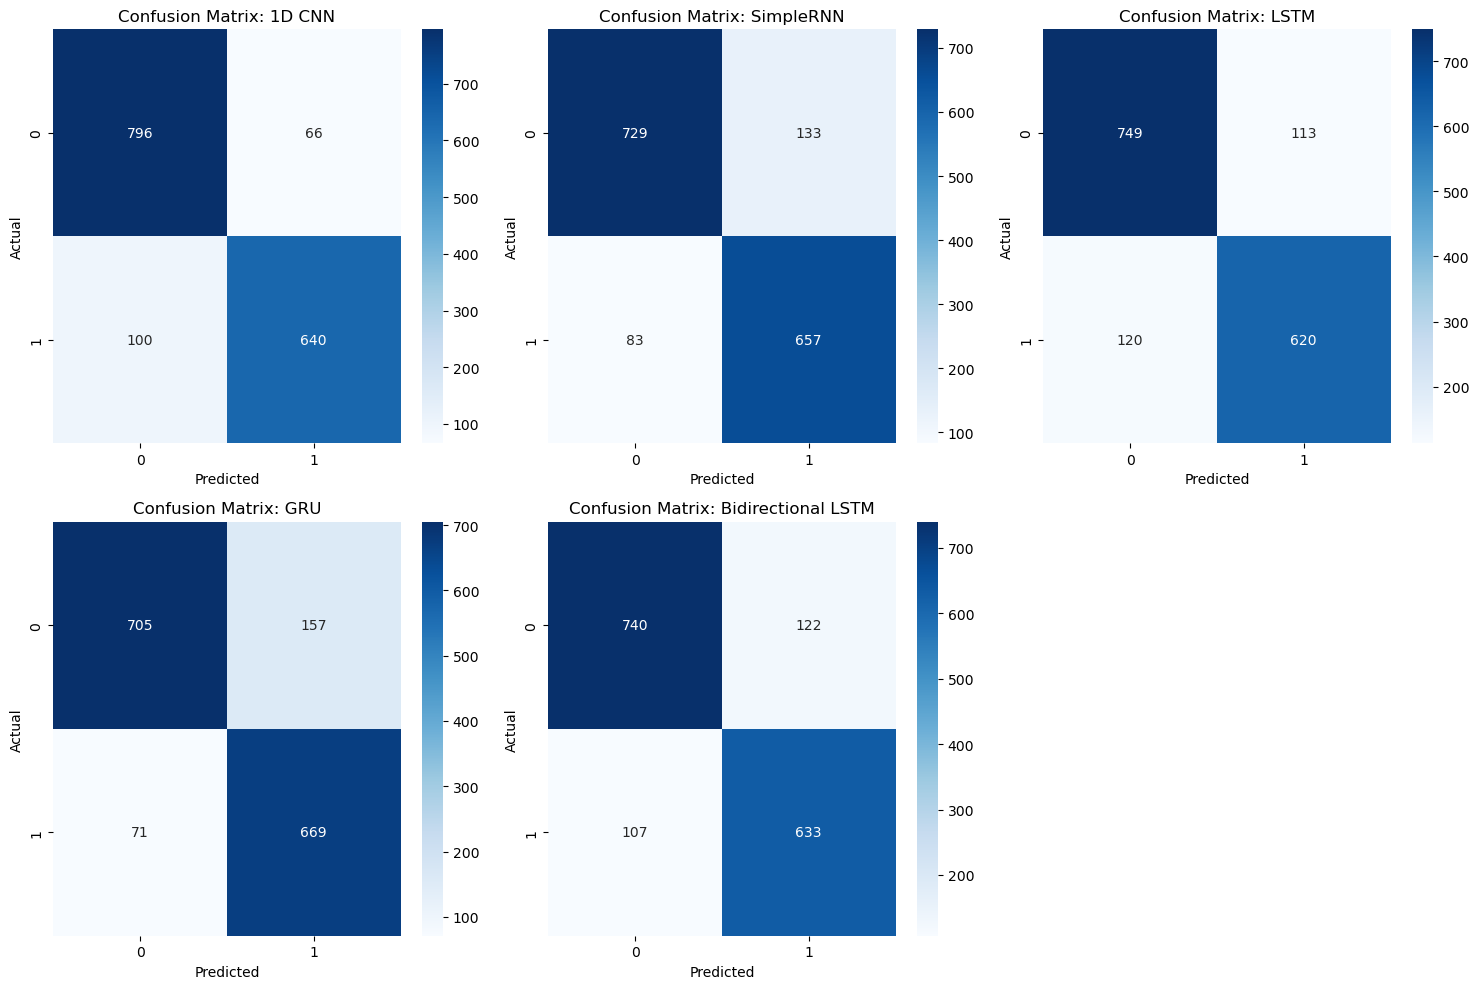

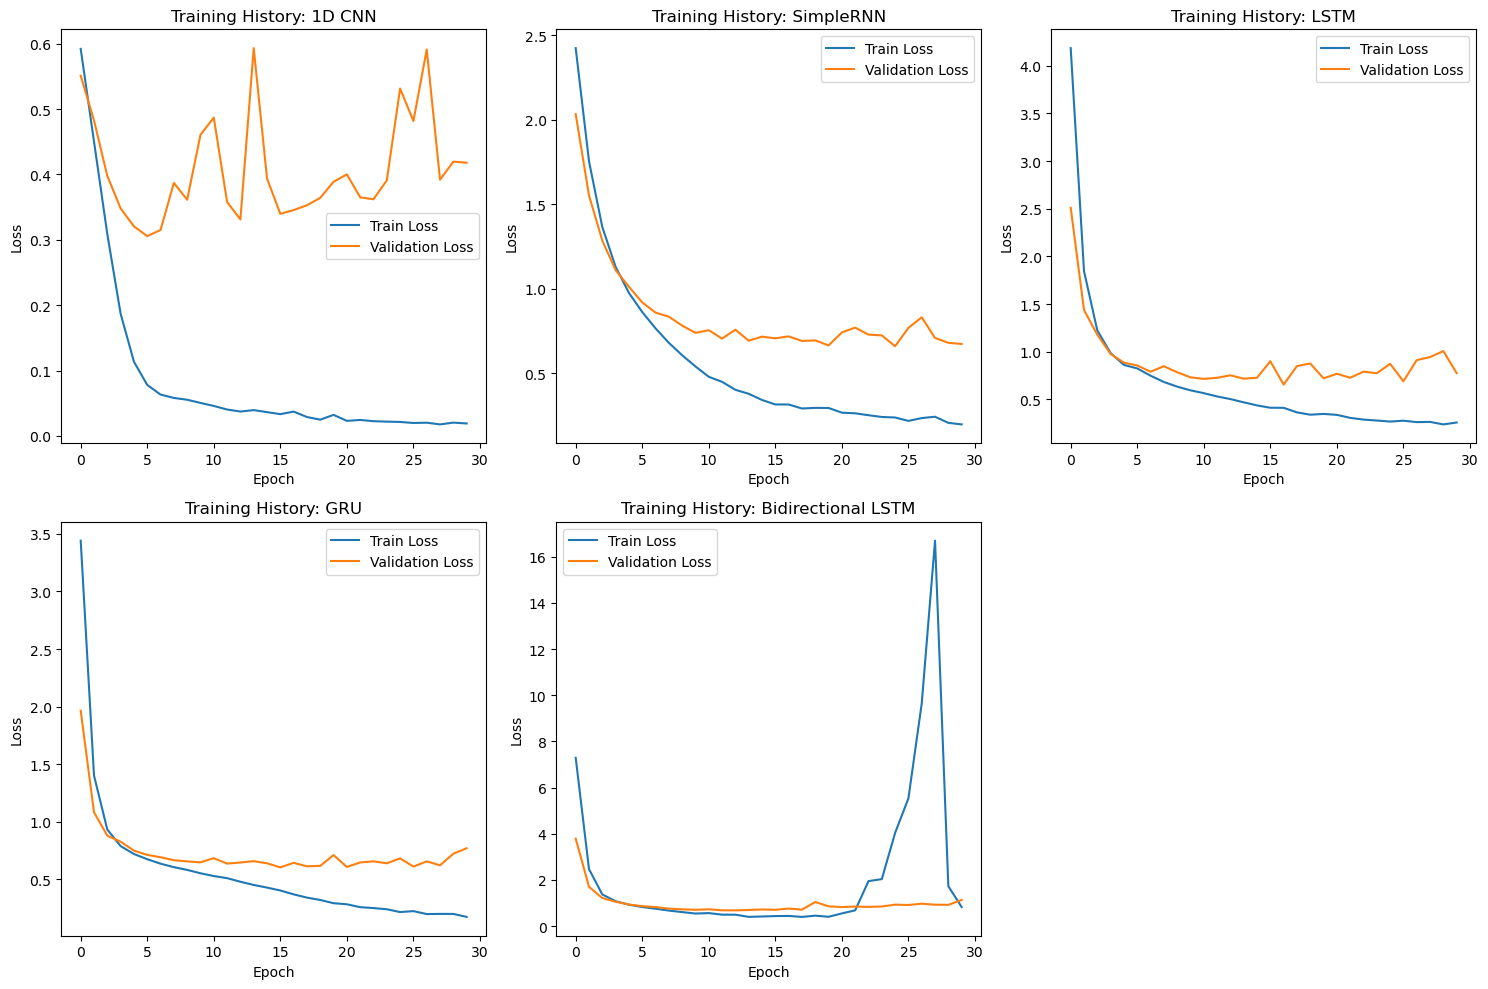

In [8]:
###006 BERT embeddings_NN
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, SimpleRNN
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from transformers import BertTokenizer, TFBertModel
import time

# Enable mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Create output directory for plots
output_dir = '004_BERT_tokenizer_NN'
os.makedirs(output_dir, exist_ok=True)

# Load dataset
data = pd.read_csv('001_2802_merged_12000.csv')

# Data preprocessing
X = data['text']
y = data['label']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Tokenize and encode sequences using BERT tokenizer with adjusted max_length
def tokenize_and_encode(texts, max_len=64):  # Set max_length to 64
    inputs = tokenizer(
        texts.tolist(),
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    return inputs

# Re-encode with the new max_length
X_train_encoded = tokenize_and_encode(X_train, max_len=64)
X_test_encoded = tokenize_and_encode(X_test, max_len=64)

# Generate embeddings using BERT
def generate_embeddings(bert_model, encoded_inputs):
    outputs = bert_model(encoded_inputs['input_ids'], attention_mask=encoded_inputs['attention_mask'])
    return outputs.last_hidden_state

X_train_emb = generate_embeddings(bert_model, X_train_encoded)
X_test_emb = generate_embeddings(bert_model, X_test_encoded)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Define the neural networks with adjusted input shape
def create_simplernn_model(input_shape):
    model = Sequential([
        SimpleRNN(128, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Dense(1, activation='sigmoid', dtype='float32')  # Ensure output is float32
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_cnn_model(input_shape):
    model = Sequential([
        Conv1D(128, 5, activation='relu', input_shape=input_shape),
        GlobalMaxPooling1D(),  # Apply global max pooling after Conv1D layers
        Dense(128, activation='relu'),  # Additional dense layer with 128 neurons
        Dense(1, activation='sigmoid', dtype='float32')  # Ensure output is float32
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Dense(1, activation='sigmoid', dtype='float32')  # Ensure output is float32
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_gru_model(input_shape):
    model = Sequential([
        GRU(128, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Dense(1, activation='sigmoid', dtype='float32')  # Ensure output is float32
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_bilstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(128, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01))),
        Dense(1, activation='sigmoid', dtype='float32')  # Ensure output is float32
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Dictionary of neural network models
nn_models = {
    '1D CNN': create_cnn_model(X_train_emb.shape[1:]),
    'SimpleRNN': create_simplernn_model(X_train_emb.shape[1:]),
    'LSTM': create_lstm_model(X_train_emb.shape[1:]),
    'GRU': create_gru_model(X_train_emb.shape[1:]),
    'Bidirectional LSTM': create_bilstm_model(X_train_emb.shape[1:])
}

# Train and evaluate the neural networks
nn_results = {}
plt.figure(figsize=(10, 8))  # For ROC curve plotting

for name, model in nn_models.items():
    print(f"Training {name}...")
    start_time = time.time()
    history = model.fit(X_train_emb, y_train, batch_size=16, epochs=30, validation_data=(X_test_emb, y_test), verbose=2)
    training_time = time.time() - start_time
    
    y_pred_proba = model.predict(X_test_emb).ravel()
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    nn_results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average=None),  # Per-class precision
        'recall': recall_score(y_test, y_pred, average=None),  # Per-class recall
        'f1': f1_score(y_test, y_pred, average=None),  # Per-class F1 score
        'auc': roc_auc_score(y_test, y_pred_proba),
        'training_time': training_time,
        'model_size': model.count_params(),
        'classification_report': classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], digits=3),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'roc_curve': (fpr, tpr),
        'history': history.history
    }
    
    # Plot ROC curve for each model
    plt.plot(fpr, tpr, label=f'{name} (AUC = {nn_results[name]["auc"]:.3f})')

# Finalize and save the combined ROC plot
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='best')
plt.savefig(os.path.join(output_dir, 'Combined_ROC_Curve.png'))
plt.show()

# Print report for each model
for name, result in nn_results.items():
    print(f"\n{name} Report:")
    print(f"Accuracy: {result['accuracy']:.3f}")
    print(f"Training Time: {result['training_time']:.3f} seconds")
    print(f"Model Size: {result['model_size']} parameters")
    print(f"Classification Report:\n{result['classification_report']}")
    print(f"AUC: {result['auc']:.3f}")
    print("\n" + "="*60 + "\n")

# Plot Accuracy, Precision, Recall, F1 scores and save the plot
metrics_df = pd.DataFrame({
    'Model': list(nn_results.keys()),
    'Accuracy': [nn_results[name]['accuracy'] for name in nn_results],
    'Precision': [nn_results[name]['precision'].mean() for name in nn_results],
    'Recall': [nn_results[name]['recall'].mean() for name in nn_results],
    'F1 Score': [nn_results[name]['f1'].mean() for name in nn_results]
})

metrics_df.set_index('Model').plot(kind='bar', figsize=(12, 8), color= ['turquoise', 'pink', 'gray', 'olive'])
plt.title('Model Comparison on Accuracy, Precision, Recall, F1 Score')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(os.path.join(output_dir, 'Model_Comparison.png'))
plt.show()

# Plot confusion matrices and save the plot
plt.figure(figsize=(15, 10))
for i, (name, result) in enumerate(nn_results.items()):
    plt.subplot(2, 3, i + 1)
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'Confusion_Matrices.png'))
plt.show()

# Plot training history for each model and save the plot
plt.figure(figsize=(15, 10))
for i, (name, result) in enumerate(nn_results.items()):
    plt.subplot(2, 3, i + 1)
    plt.plot(result['history']['loss'], label='Train Loss')
    plt.plot(result['history']['val_loss'], label='Validation Loss')
    plt.title(f'Training History: {name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'Training_History.png'))
plt.show()


C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- Thi

Training 1D CNN...
Epoch 1/40


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


401/401 - 47s - 118ms/step - accuracy: 0.6798 - loss: 0.5926 - val_accuracy: 0.6910 - val_loss: 0.5747
Epoch 2/40
401/401 - 45s - 112ms/step - accuracy: 0.8159 - loss: 0.4385 - val_accuracy: 0.7653 - val_loss: 0.4886
Epoch 3/40
401/401 - 45s - 113ms/step - accuracy: 0.8995 - loss: 0.3045 - val_accuracy: 0.8315 - val_loss: 0.3954
Epoch 4/40
401/401 - 45s - 113ms/step - accuracy: 0.9530 - loss: 0.1897 - val_accuracy: 0.8645 - val_loss: 0.3405
Epoch 5/40
401/401 - 45s - 113ms/step - accuracy: 0.9792 - loss: 0.1153 - val_accuracy: 0.8552 - val_loss: 0.3569
Epoch 6/40
401/401 - 45s - 112ms/step - accuracy: 0.9833 - loss: 0.0803 - val_accuracy: 0.8777 - val_loss: 0.3062
Epoch 7/40
401/401 - 45s - 112ms/step - accuracy: 0.9858 - loss: 0.0638 - val_accuracy: 0.8508 - val_loss: 0.3657
Epoch 8/40
401/401 - 45s - 112ms/step - accuracy: 0.9880 - loss: 0.0582 - val_accuracy: 0.8839 - val_loss: 0.3178
Epoch 9/40
401/401 - 45s - 113ms/step - accuracy: 0.9905 - loss: 0.0506 - val_accuracy: 0.8795 - va

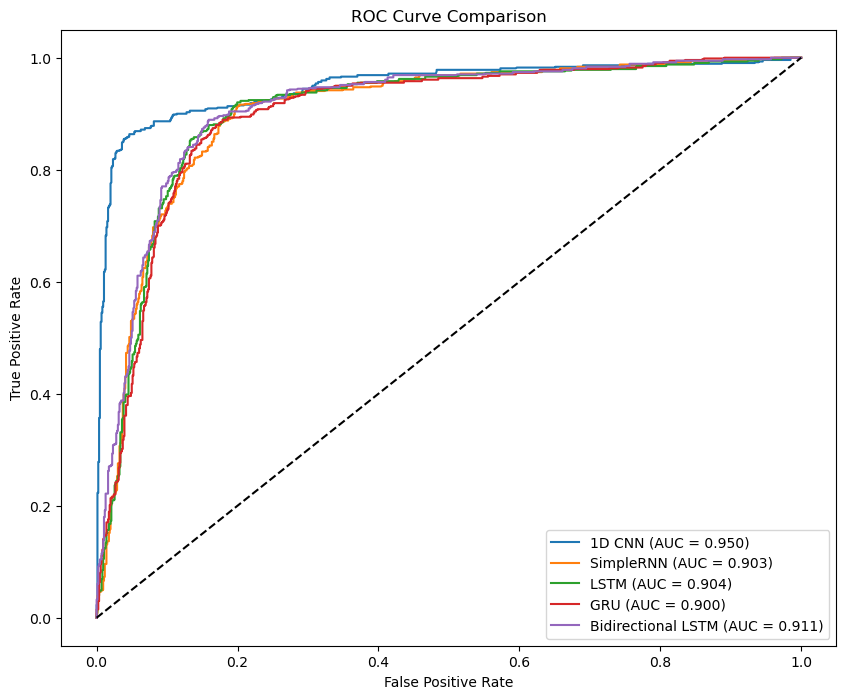


1D CNN Report:
Accuracy: 0.890
Training Time: 1808.703 seconds
Model Size: 508289 parameters
Classification Report:
              precision    recall  f1-score   support

     Class 0      0.911     0.882     0.896       862
     Class 1      0.867     0.900     0.883       740

    accuracy                          0.890      1602
   macro avg      0.889     0.891     0.890      1602
weighted avg      0.891     0.890     0.890      1602

AUC: 0.950



SimpleRNN Report:
Accuracy: 0.851
Training Time: 404.593 seconds
Model Size: 114945 parameters
Classification Report:
              precision    recall  f1-score   support

     Class 0      0.915     0.798     0.853       862
     Class 1      0.795     0.914     0.850       740

    accuracy                          0.851      1602
   macro avg      0.855     0.856     0.851      1602
weighted avg      0.860     0.851     0.852      1602

AUC: 0.903



LSTM Report:
Accuracy: 0.851
Training Time: 1608.469 seconds
Model Size: 459393 par

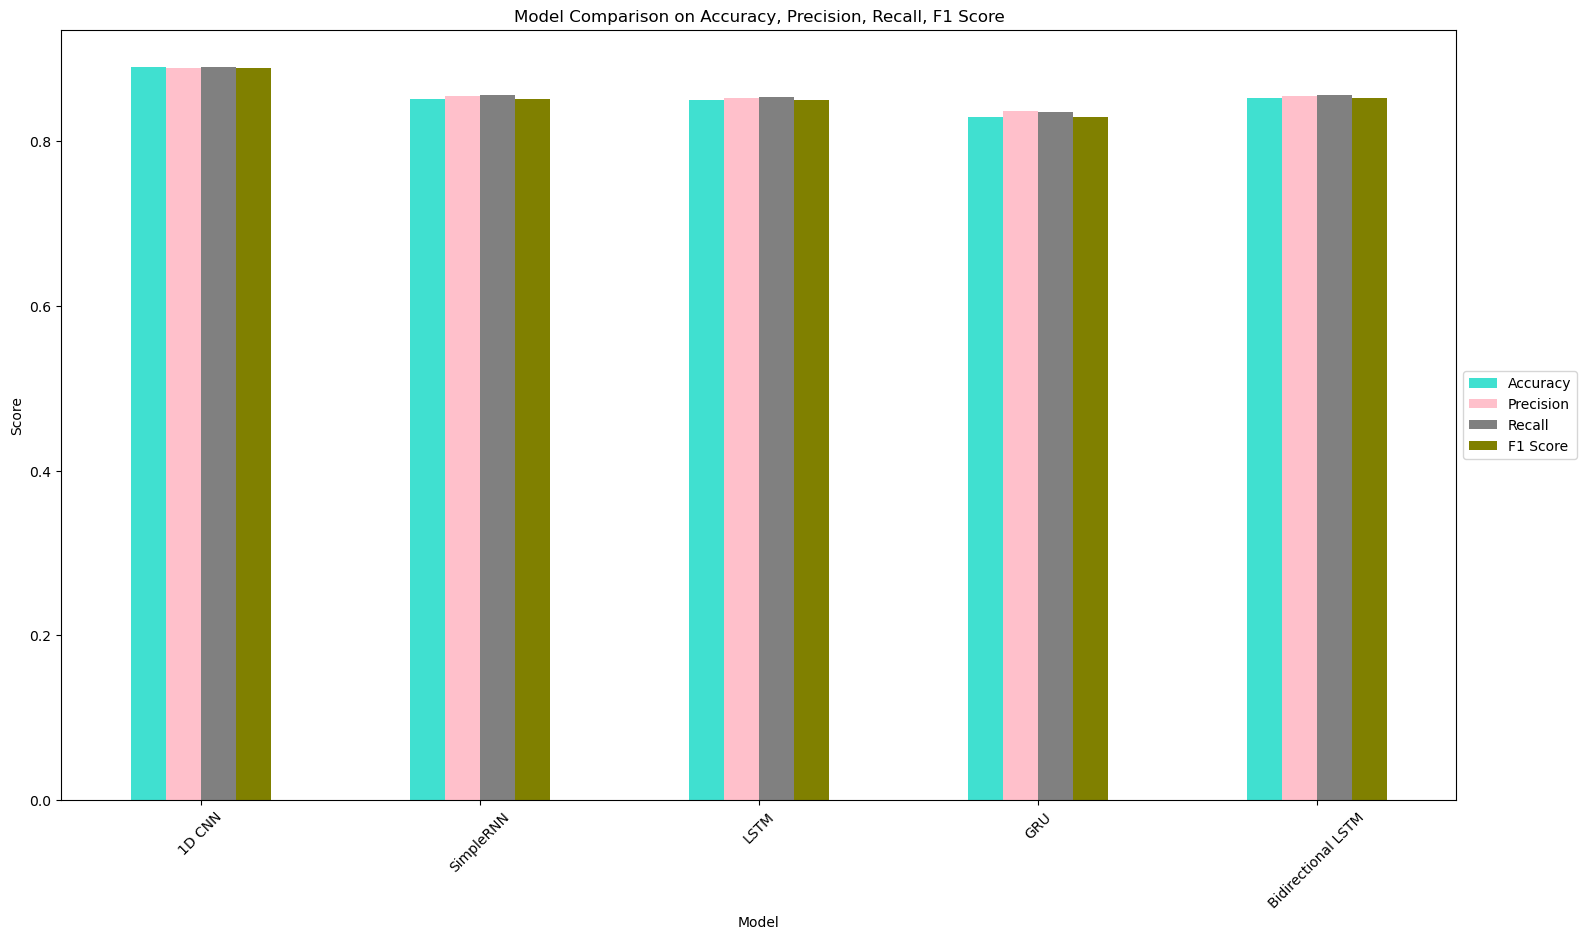

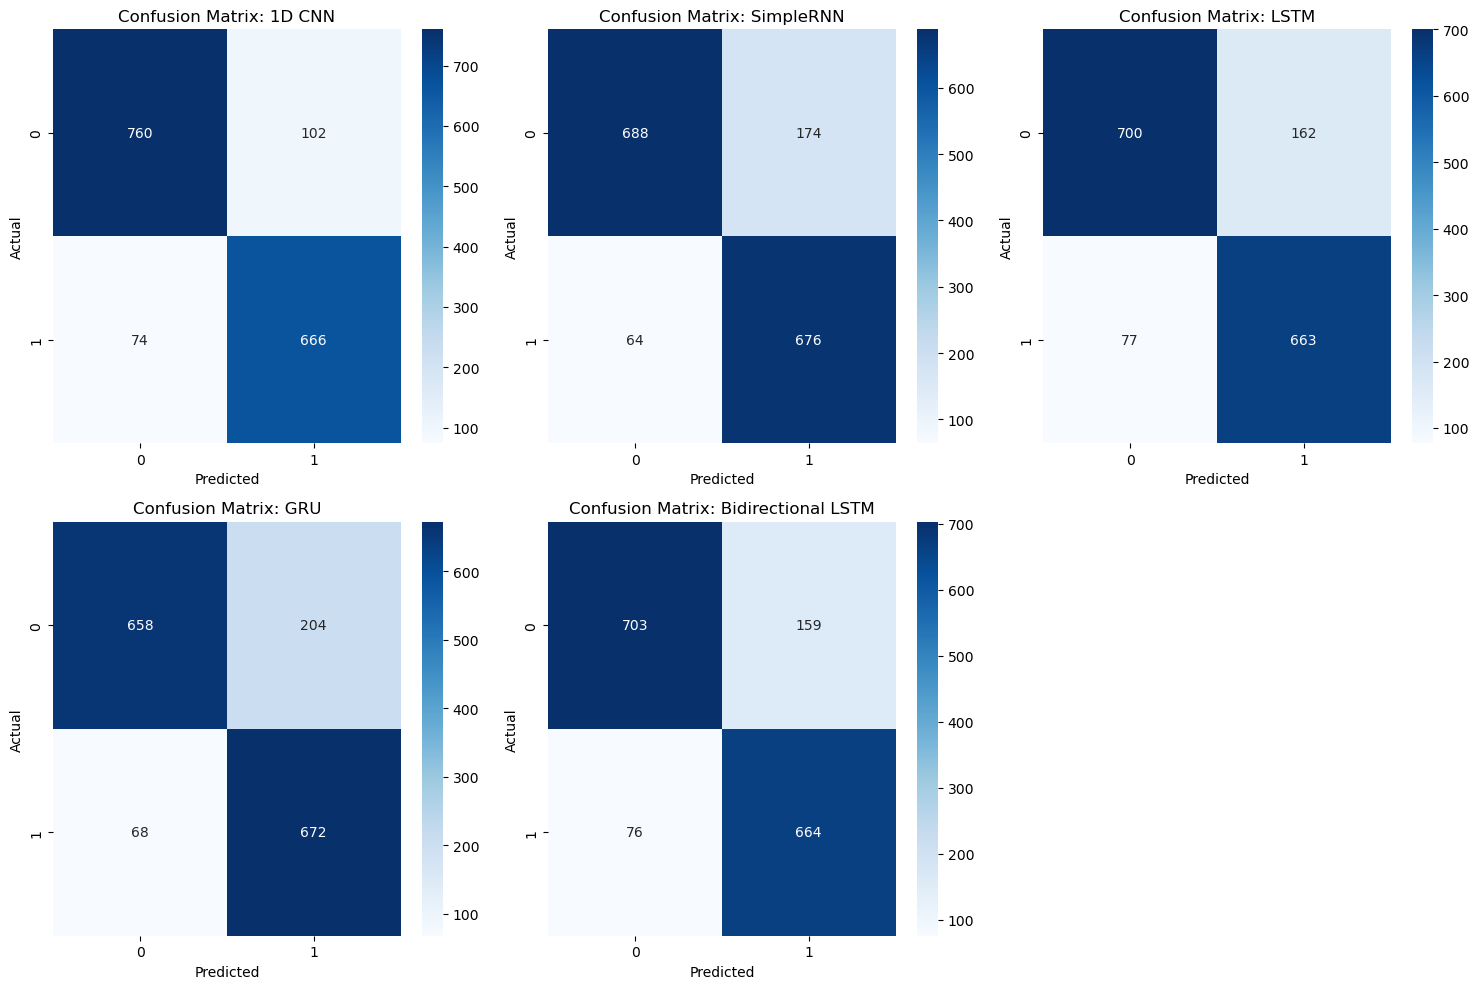

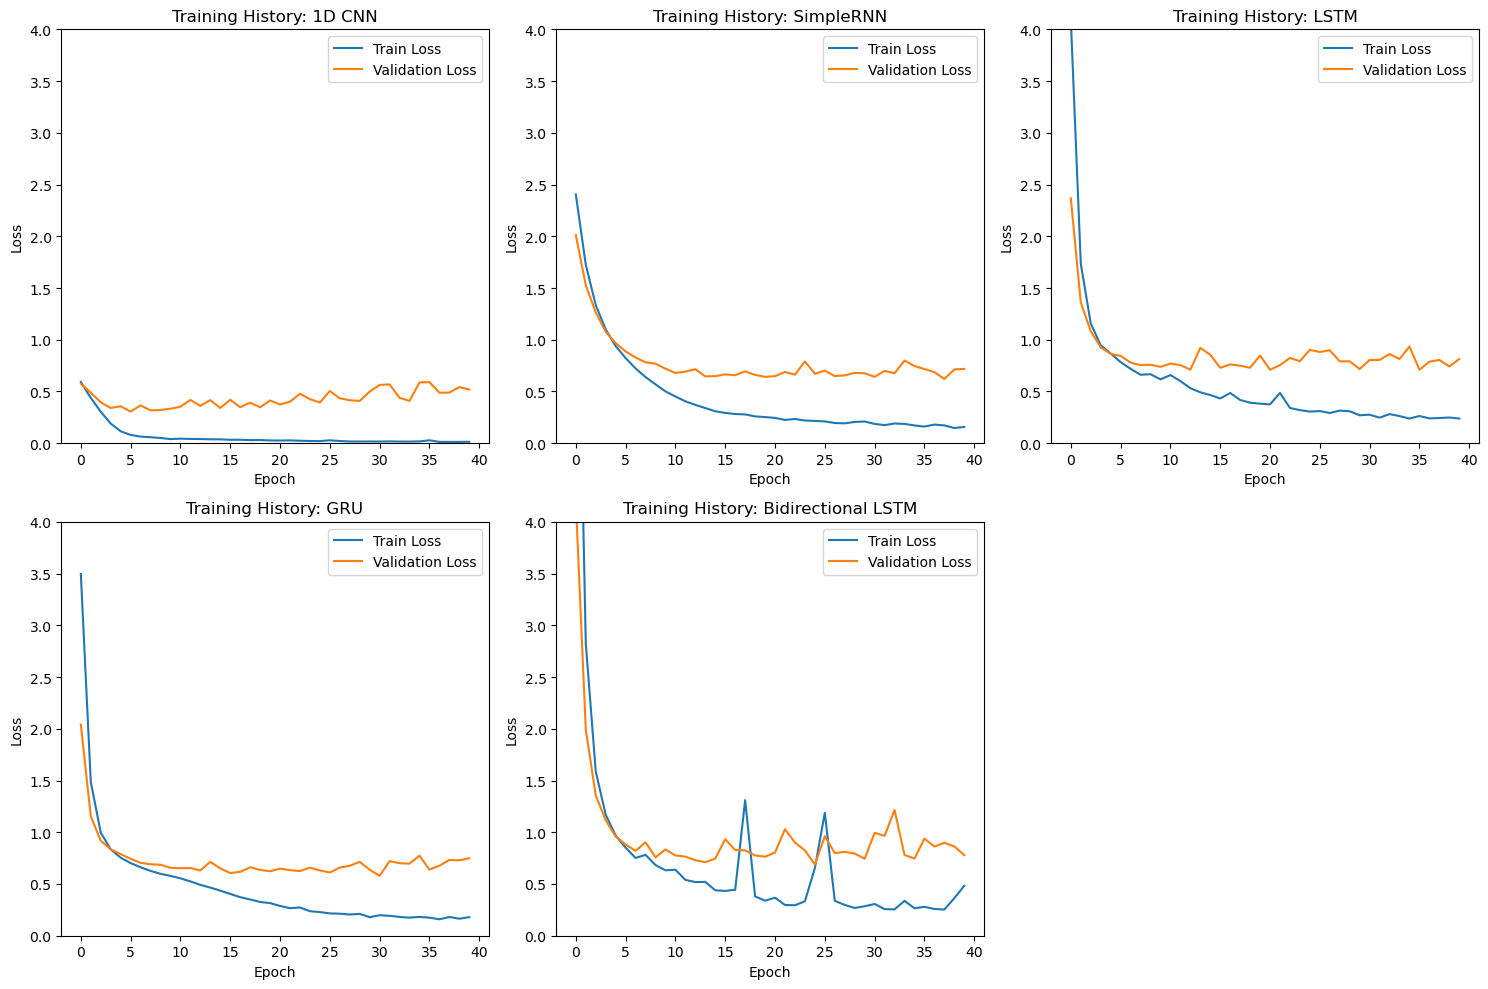

In [4]:
###006 BERT embeddings_NN
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, SimpleRNN
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from transformers import BertTokenizer, TFBertModel
import time

# Enable mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Create output directory for plots
output_dir = 'BERT_NN2'
os.makedirs(output_dir, exist_ok=True)

# Load dataset
data = pd.read_csv('001_2802_merged_12000.csv')

# Data preprocessing
X = data['text']
y = data['label']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Tokenize and encode sequences using BERT tokenizer with adjusted max_length
def tokenize_and_encode(texts, max_len=64):  # Set max_length to 64
    inputs = tokenizer(
        texts.tolist(),
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    return inputs

# Re-encode with the new max_length
X_train_encoded = tokenize_and_encode(X_train, max_len=64)
X_test_encoded = tokenize_and_encode(X_test, max_len=64)

# Generate embeddings using BERT
def generate_embeddings(bert_model, encoded_inputs):
    outputs = bert_model(encoded_inputs['input_ids'], attention_mask=encoded_inputs['attention_mask'])
    return outputs.last_hidden_state

X_train_emb = generate_embeddings(bert_model, X_train_encoded)
X_test_emb = generate_embeddings(bert_model, X_test_encoded)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Define the neural networks with adjusted input shape
def create_simplernn_model(input_shape):
    model = Sequential([
        SimpleRNN(128, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Dense(1, activation='sigmoid', dtype='float32')  # Ensure output is float32
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_cnn_model(input_shape):
    model = Sequential([
        Conv1D(128, 5, activation='relu', input_shape=input_shape),
        GlobalMaxPooling1D(),  # Apply global max pooling after Conv1D layers
        Dense(128, activation='relu'),  # Additional dense layer with 128 neurons
        Dense(1, activation='sigmoid', dtype='float32')  # Ensure output is float32
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Dense(1, activation='sigmoid', dtype='float32')  # Ensure output is float32
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_gru_model(input_shape):
    model = Sequential([
        GRU(128, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        Dense(1, activation='sigmoid', dtype='float32')  # Ensure output is float32
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_bilstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(128, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01))),
        Dense(1, activation='sigmoid', dtype='float32')  # Ensure output is float32
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Dictionary of neural network models
nn_models = {
    '1D CNN': create_cnn_model(X_train_emb.shape[1:]),
    'SimpleRNN': create_simplernn_model(X_train_emb.shape[1:]),
    'LSTM': create_lstm_model(X_train_emb.shape[1:]),
    'GRU': create_gru_model(X_train_emb.shape[1:]),
    'Bidirectional LSTM': create_bilstm_model(X_train_emb.shape[1:])
}

# Train and evaluate the neural networks
nn_results = {}
plt.figure(figsize=(10, 8))  # For ROC curve plotting

for name, model in nn_models.items():
    print(f"Training {name}...")
    start_time = time.time()
    history = model.fit(X_train_emb, y_train, batch_size=16, epochs=30, validation_data=(X_test_emb, y_test), verbose=2)
    training_time = time.time() - start_time
    
    y_pred_proba = model.predict(X_test_emb).ravel()
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    nn_results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average=None),  # Per-class precision
        'recall': recall_score(y_test, y_pred, average=None),  # Per-class recall
        'f1': f1_score(y_test, y_pred, average=None),  # Per-class F1 score
        'auc': roc_auc_score(y_test, y_pred_proba),
        'training_time': training_time,
        'model_size': model.count_params(),
        'classification_report': classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], digits=3),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'roc_curve': (fpr, tpr),
        'history': history.history
    }
    
    # Plot ROC curve for each model
    plt.plot(fpr, tpr, label=f'{name} (AUC = {nn_results[name]["auc"]:.3f})')

# Finalize and save the combined ROC plot
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='best')
plt.savefig(os.path.join(output_dir, 'Combined_ROC_Curve.png'))
plt.show()

# Print report for each model
for name, result in nn_results.items():
    print(f"\n{name} Report:")
    print(f"Accuracy: {result['accuracy']:.3f}")
    print(f"Training Time: {result['training_time']:.3f} seconds")
    print(f"Model Size: {result['model_size']} parameters")
    print(f"Classification Report:\n{result['classification_report']}")
    print(f"AUC: {result['auc']:.3f}")
    print("\n" + "="*60 + "\n")

# Plot Accuracy, Precision, Recall, F1 scores and save the plot
metrics_df = pd.DataFrame({
    'Model': list(nn_results.keys()),
    'Accuracy': [nn_results[name]['accuracy'] for name in nn_results],
    'Precision': [nn_results[name]['precision'].mean() for name in nn_results],
    'Recall': [nn_results[name]['recall'].mean() for name in nn_results],
    'F1 Score': [nn_results[name]['f1'].mean() for name in nn_results]
})

metrics_df.set_index('Model').plot(kind='bar', figsize=(18, 10), color= ['turquoise', 'pink', 'gray', 'olive'])
plt.title('Model Comparison on Accuracy, Precision, Recall, F1 Score')
plt.ylabel('Score')
plt.xticks(rotation=20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(os.path.join(output_dir, 'Model_Comparison.png'))
plt.show()

# Plot confusion matrices and save the plot
plt.figure(figsize=(15, 10))
for i, (name, result) in enumerate(nn_results.items()):
    plt.subplot(2, 3, i + 1)
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'Confusion_Matrices.png'))
plt.show()

# Plot training history for each model and save the plot
plt.figure(figsize=(15, 10))
for i, (name, result) in enumerate(nn_results.items()):
    plt.subplot(2, 3, i + 1)
    plt.plot(result['history']['loss'], label='Train Loss')
    plt.plot(result['history']['val_loss'], label='Validation Loss')
    plt.title(f'Training History: {name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim(0, 4)     
    plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'Training_History.png'))
plt.show()


# Plot accuracy history (training and validation) for each model and save the plot
plt.figure(figsize=(15, 10))
for i, (name, result) in enumerate(nn_results.items()):
    plt.subplot(2, 3, i + 1)
    plt.plot(result['history']['accuracy'], label='Train Accuracy')
    plt.plot(result['history']['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy History: {name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.ylim(0, 1)  # Accuracy ranges between 0 and 1
    plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'Accuracy_History_acc.png'))
plt.show()

In [ ]:
##### some other experiments with Tweeter posts

C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Training 1D CNN...
Epoch 1/20


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


140/140 - 16s - 114ms/step - accuracy: 0.8244 - loss: 0.4026 - val_accuracy: 0.9107 - val_loss: 0.2706
Epoch 2/20
140/140 - 14s - 102ms/step - accuracy: 0.9249 - loss: 0.2100 - val_accuracy: 0.9143 - val_loss: 0.2440
Epoch 3/20
140/140 - 15s - 109ms/step - accuracy: 0.9620 - loss: 0.1370 - val_accuracy: 0.9125 - val_loss: 0.2125
Epoch 4/20
140/140 - 16s - 117ms/step - accuracy: 0.9844 - loss: 0.0829 - val_accuracy: 0.9214 - val_loss: 0.1962
Epoch 5/20
140/140 - 15s - 104ms/step - accuracy: 0.9960 - loss: 0.0497 - val_accuracy: 0.9214 - val_loss: 0.1918
Epoch 6/20
140/140 - 15s - 106ms/step - accuracy: 0.9987 - loss: 0.0297 - val_accuracy: 0.9214 - val_loss: 0.1918
Epoch 7/20
140/140 - 16s - 114ms/step - accuracy: 0.9991 - loss: 0.0194 - val_accuracy: 0.9250 - val_loss: 0.1827
Epoch 8/20
140/140 - 15s - 104ms/step - accuracy: 1.0000 - loss: 0.0129 - val_accuracy: 0.9196 - val_loss: 0.1887
Epoch 9/20
140/140 - 14s - 102ms/step - accuracy: 1.0000 - loss: 0.0091 - val_accuracy: 0.9250 - va

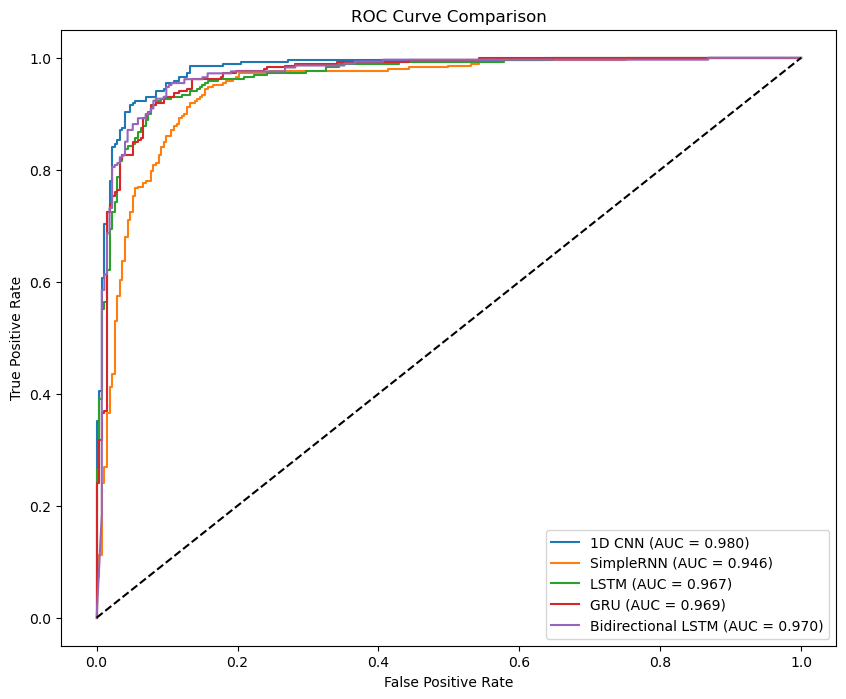


1D CNN Report:
Accuracy: 0.925
Training Time: 329.654 seconds
Model Size: 508289 parameters
Classification Report:
              precision    recall  f1-score   support

     Class 0      0.929     0.916     0.923       273
     Class 1      0.921     0.934     0.927       287

    accuracy                          0.925       560
   macro avg      0.925     0.925     0.925       560
weighted avg      0.925     0.925     0.925       560

AUC: 0.980



SimpleRNN Report:
Accuracy: 0.893
Training Time: 49.418 seconds
Model Size: 114945 parameters
Classification Report:
              precision    recall  f1-score   support

     Class 0      0.908     0.868     0.888       273
     Class 1      0.880     0.916     0.898       287

    accuracy                          0.893       560
   macro avg      0.894     0.892     0.893       560
weighted avg      0.893     0.893     0.893       560

AUC: 0.946



LSTM Report:
Accuracy: 0.912
Training Time: 164.517 seconds
Model Size: 459393 parame

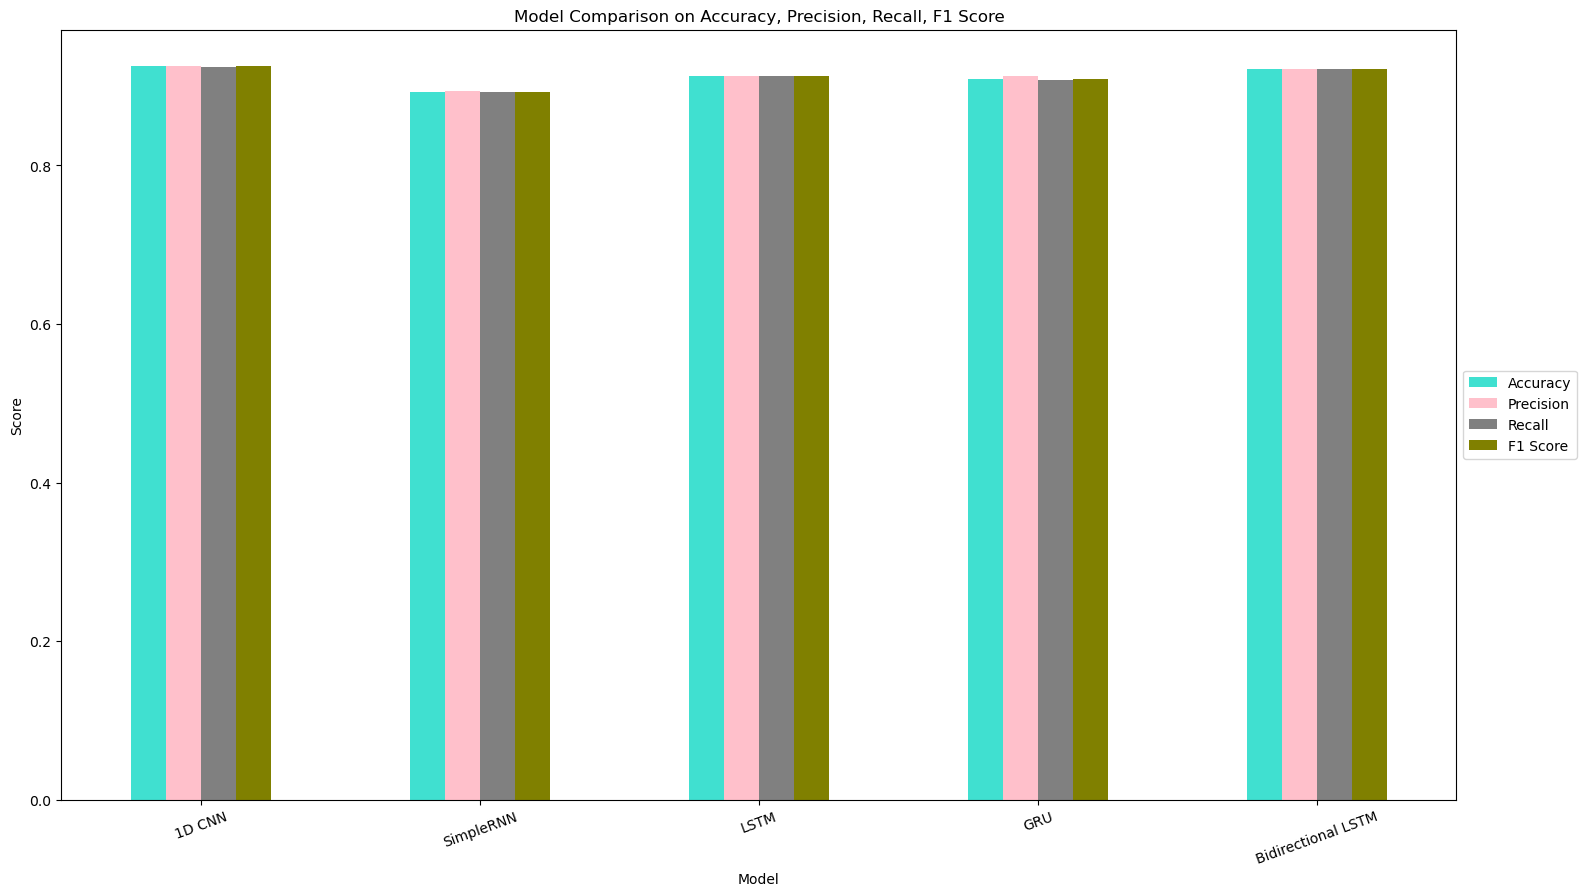

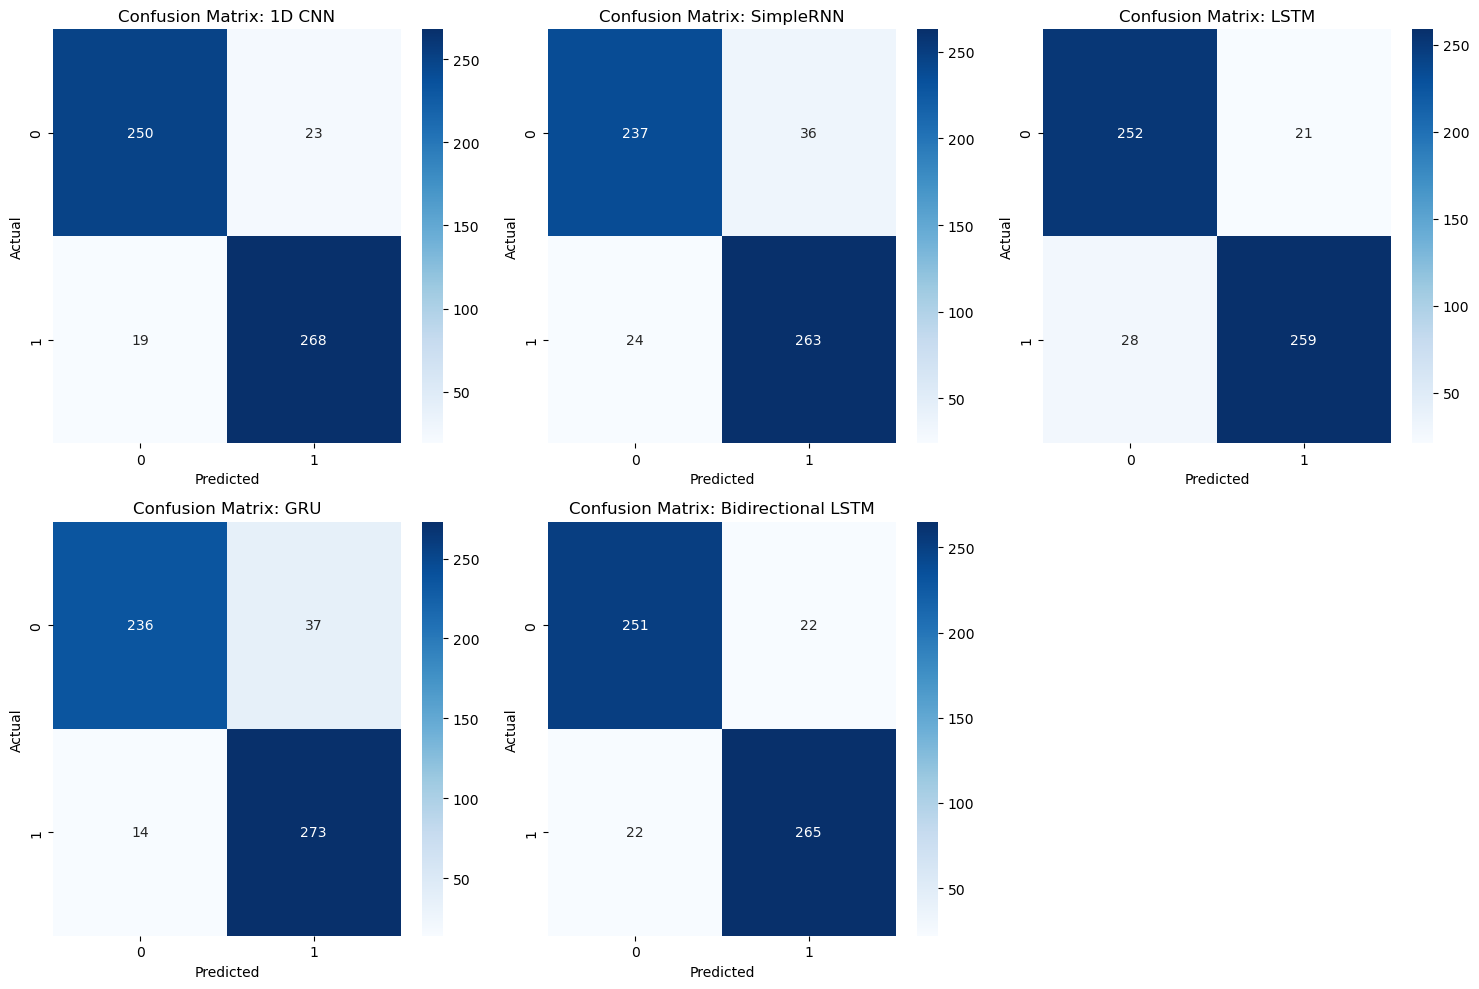

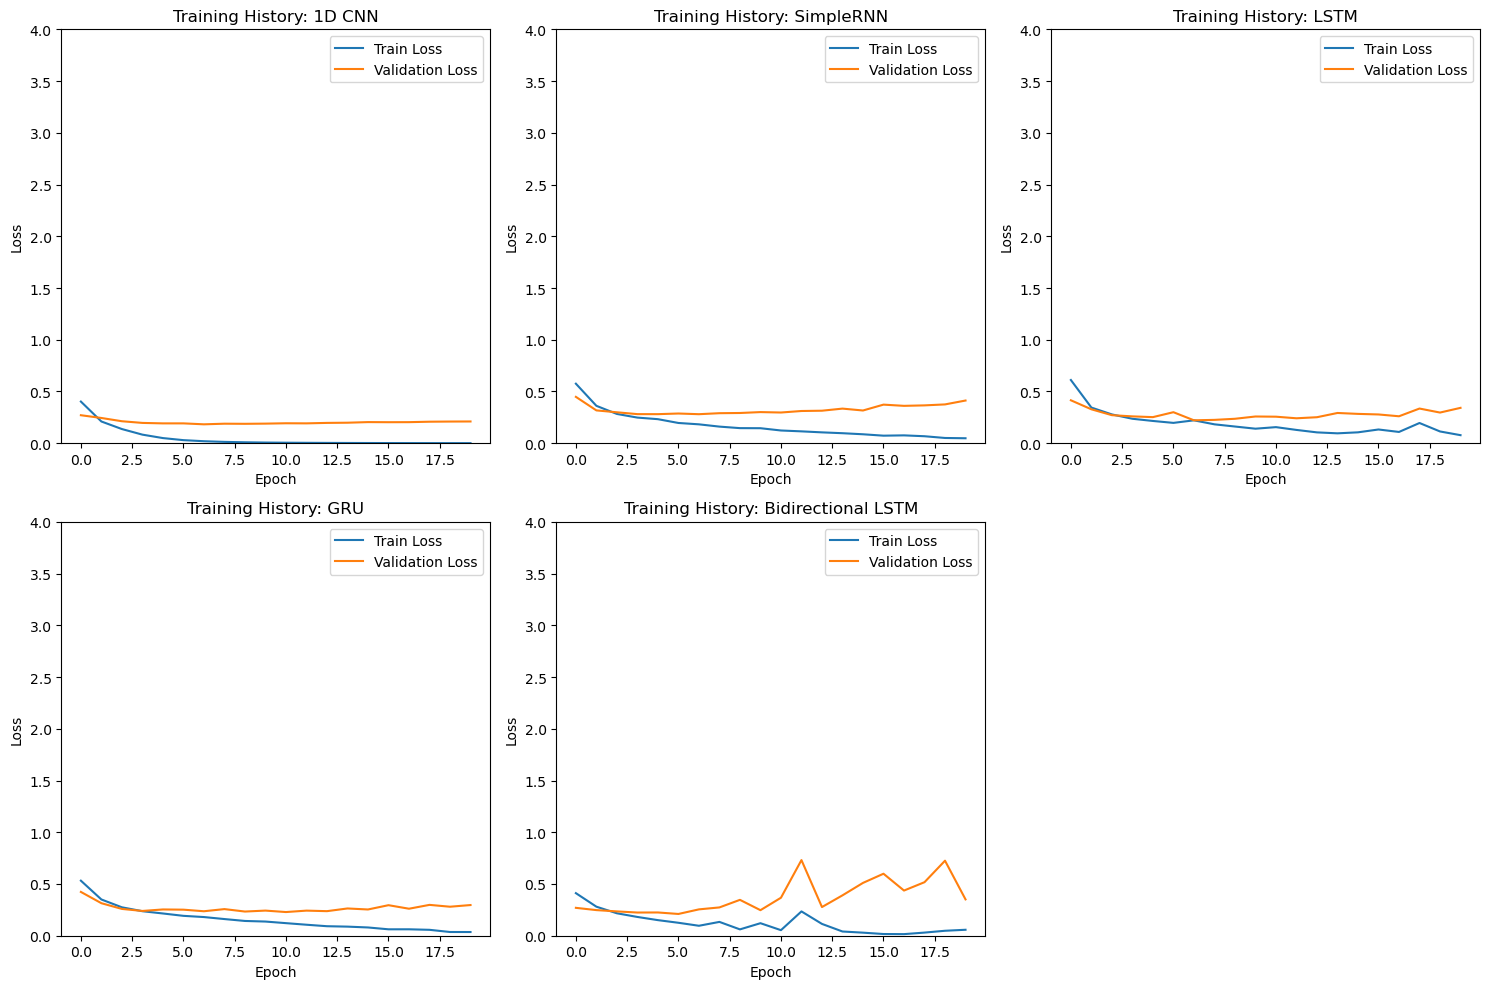

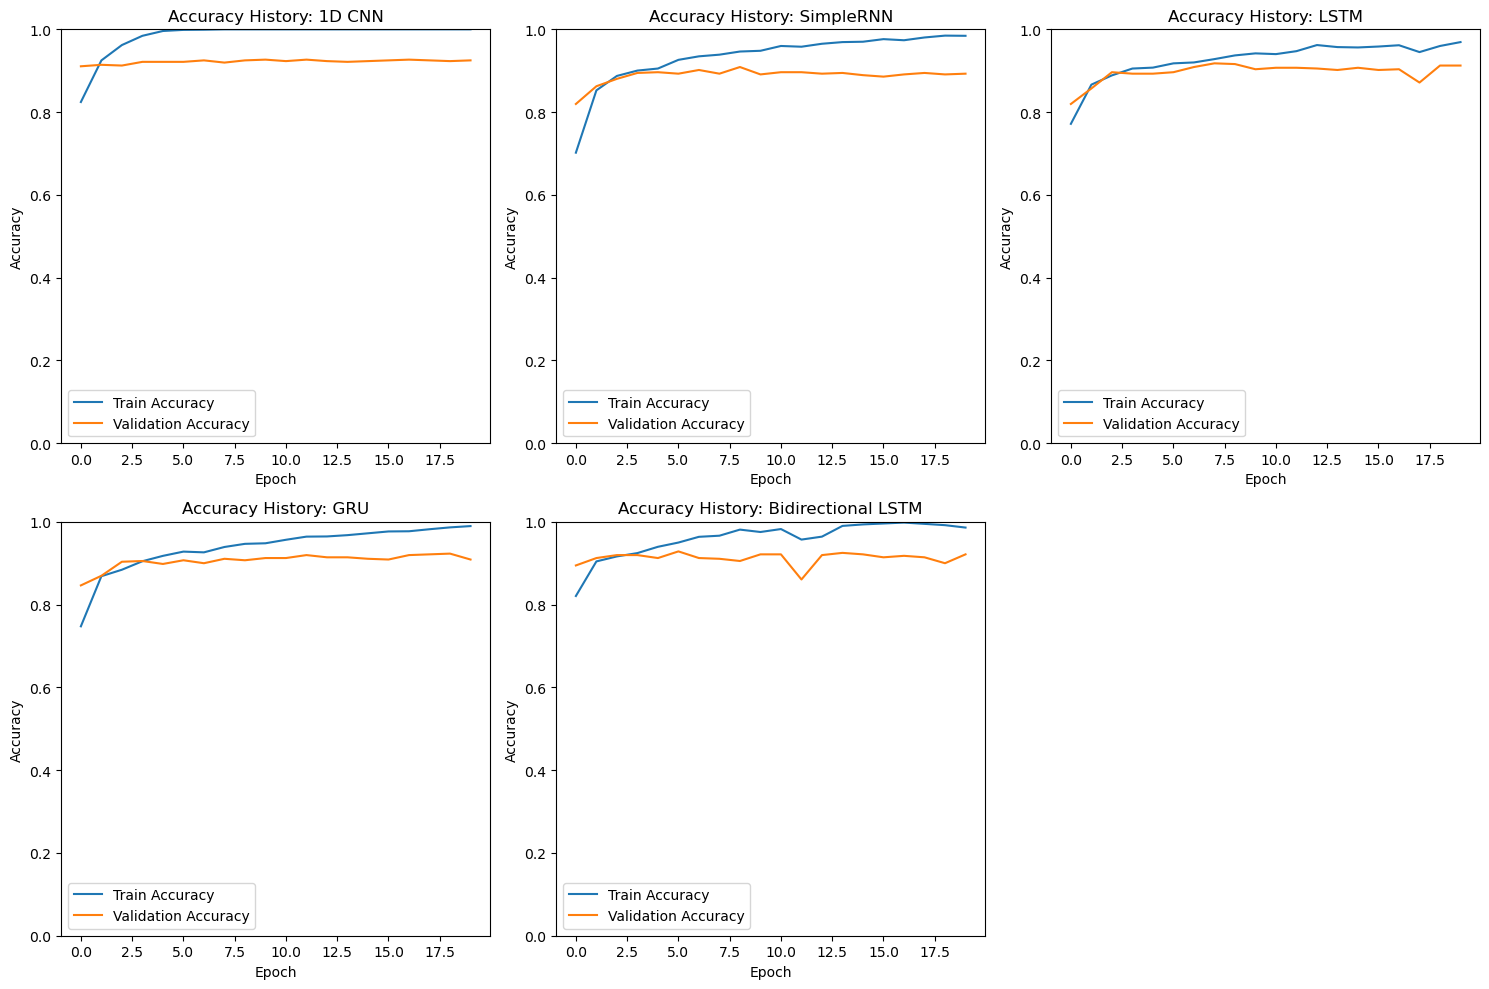

In [2]:
###006 BERT embeddings_NN
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, SimpleRNN
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from transformers import BertTokenizer, TFBertModel
import time

# Enable mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Create output directory for plots
output_dir = 'BERT_NN2_compare'
os.makedirs(output_dir, exist_ok=True)

# Load dataset
data = pd.read_csv('Tweeter_depression_dataset_sampled.csv')

# Data preprocessing
X = data['text']
y = data['label']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Tokenize and encode sequences using BERT tokenizer with adjusted max_length
def tokenize_and_encode(texts, max_len=64):  # Set max_length to 64
    inputs = tokenizer(
        texts.tolist(),
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    return inputs

# Re-encode with the new max_length
X_train_encoded = tokenize_and_encode(X_train, max_len=64)
X_test_encoded = tokenize_and_encode(X_test, max_len=64)

# Generate embeddings using BERT
def generate_embeddings(bert_model, encoded_inputs):
    outputs = bert_model(encoded_inputs['input_ids'], attention_mask=encoded_inputs['attention_mask'])
    return outputs.last_hidden_state

X_train_emb = generate_embeddings(bert_model, X_train_encoded)
X_test_emb = generate_embeddings(bert_model, X_test_encoded)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Define the neural networks with adjusted input shape
def create_simplernn_model(input_shape):
    model = Sequential([
        SimpleRNN(128, activation='relu', input_shape=input_shape),
        Dense(1, activation='sigmoid', dtype='float32')  # Ensure output is float32
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_cnn_model(input_shape):
    model = Sequential([
        Conv1D(128, 5, activation='relu', input_shape=input_shape),
        GlobalMaxPooling1D(),  # Apply global max pooling after Conv1D layers
        Dense(128, activation='relu'),  # Additional dense layer with 128 neurons
        Dense(1, activation='sigmoid', dtype='float32')  # Ensure output is float32
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, activation='relu', input_shape=input_shape),
        Dense(1, activation='sigmoid', dtype='float32')  # Ensure output is float32
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_gru_model(input_shape):
    model = Sequential([
        GRU(128, activation='relu', input_shape=input_shape),
        Dense(1, activation='sigmoid', dtype='float32')  # Ensure output is float32
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_bilstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(128, activation='relu', input_shape=input_shape)),
        Dense(1, activation='sigmoid', dtype='float32')  # Ensure output is float32
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Dictionary of neural network models
nn_models = {
    '1D CNN': create_cnn_model(X_train_emb.shape[1:]),
    'SimpleRNN': create_simplernn_model(X_train_emb.shape[1:]),
    'LSTM': create_lstm_model(X_train_emb.shape[1:]),
    'GRU': create_gru_model(X_train_emb.shape[1:]),
    'Bidirectional LSTM': create_bilstm_model(X_train_emb.shape[1:])
}

# Train and evaluate the neural networks
nn_results = {}
plt.figure(figsize=(10, 8))  # For ROC curve plotting

for name, model in nn_models.items():
    print(f"Training {name}...")
    start_time = time.time()
    history = model.fit(X_train_emb, y_train, batch_size=16, epochs=20, validation_data=(X_test_emb, y_test), verbose=2)
    training_time = time.time() - start_time
    
    y_pred_proba = model.predict(X_test_emb).ravel()
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    nn_results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average=None),  # Per-class precision
        'recall': recall_score(y_test, y_pred, average=None),  # Per-class recall
        'f1': f1_score(y_test, y_pred, average=None),  # Per-class F1 score
        'auc': roc_auc_score(y_test, y_pred_proba),
        'training_time': training_time,
        'model_size': model.count_params(),
        'classification_report': classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], digits=3),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'roc_curve': (fpr, tpr),
        'history': history.history
    }
    
    # Plot ROC curve for each model
    plt.plot(fpr, tpr, label=f'{name} (AUC = {nn_results[name]["auc"]:.3f})')

# Finalize and save the combined ROC plot
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='best')
plt.savefig(os.path.join(output_dir, 'Combined_ROC_Curve.png'))
plt.show()

# Print report for each model
for name, result in nn_results.items():
    print(f"\n{name} Report:")
    print(f"Accuracy: {result['accuracy']:.3f}")
    print(f"Training Time: {result['training_time']:.3f} seconds")
    print(f"Model Size: {result['model_size']} parameters")
    print(f"Classification Report:\n{result['classification_report']}")
    print(f"AUC: {result['auc']:.3f}")
    print("\n" + "="*60 + "\n")

# Plot Accuracy, Precision, Recall, F1 scores and save the plot
metrics_df = pd.DataFrame({
    'Model': list(nn_results.keys()),
    'Accuracy': [nn_results[name]['accuracy'] for name in nn_results],
    'Precision': [nn_results[name]['precision'].mean() for name in nn_results],
    'Recall': [nn_results[name]['recall'].mean() for name in nn_results],
    'F1 Score': [nn_results[name]['f1'].mean() for name in nn_results]
})

metrics_df.set_index('Model').plot(kind='bar', figsize=(18, 10), color= ['turquoise', 'pink', 'gray', 'olive'])
plt.title('Model Comparison on Accuracy, Precision, Recall, F1 Score')
plt.ylabel('Score')
plt.xticks(rotation=20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(os.path.join(output_dir, 'Model_Comparison.png'))
plt.show()

# Plot confusion matrices and save the plot
plt.figure(figsize=(15, 10))
for i, (name, result) in enumerate(nn_results.items()):
    plt.subplot(2, 3, i + 1)
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'Confusion_Matrices.png'))
plt.show()

# Plot training history for each model and save the plot
plt.figure(figsize=(15, 10))
for i, (name, result) in enumerate(nn_results.items()):
    plt.subplot(2, 3, i + 1)
    plt.plot(result['history']['loss'], label='Train Loss')
    plt.plot(result['history']['val_loss'], label='Validation Loss')
    plt.title(f'Training History: {name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim(0, 4)     
    plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'Training_History.png'))
plt.show()


# Plot accuracy history (training and validation) for each model and save the plot
plt.figure(figsize=(15, 10))
for i, (name, result) in enumerate(nn_results.items()):
    plt.subplot(2, 3, i + 1)
    plt.plot(result['history']['accuracy'], label='Train Accuracy')
    plt.plot(result['history']['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy History: {name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.ylim(0, 1)  # Accuracy ranges between 0 and 1
    plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'Accuracy_History_acc.png'))
plt.show()

C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w


Starting training and evaluation for BERT + 1DCNN
Training BERT + 1DCNN...
Epoch 1/30


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


401/401 - 2s - 6ms/step - accuracy: 0.6681 - loss: 0.6068 - val_accuracy: 0.6642 - val_loss: 0.6380
Epoch 2/30
401/401 - 2s - 4ms/step - accuracy: 0.7747 - loss: 0.4704 - val_accuracy: 0.7409 - val_loss: 0.5189
Epoch 3/30
401/401 - 2s - 4ms/step - accuracy: 0.8788 - loss: 0.3009 - val_accuracy: 0.8021 - val_loss: 0.4680
Epoch 4/30
401/401 - 2s - 4ms/step - accuracy: 0.9344 - loss: 0.1756 - val_accuracy: 0.8608 - val_loss: 0.4351
Epoch 5/30
401/401 - 2s - 4ms/step - accuracy: 0.9661 - loss: 0.0976 - val_accuracy: 0.8533 - val_loss: 0.4707
Epoch 6/30
401/401 - 2s - 4ms/step - accuracy: 0.9803 - loss: 0.0714 - val_accuracy: 0.8851 - val_loss: 0.4094
Epoch 7/30
401/401 - 2s - 4ms/step - accuracy: 0.9713 - loss: 0.0785 - val_accuracy: 0.8034 - val_loss: 0.7296
Epoch 8/30
401/401 - 2s - 5ms/step - accuracy: 0.9781 - loss: 0.0705 - val_accuracy: 0.8733 - val_loss: 0.4491
Epoch 9/30
401/401 - 2s - 4ms/step - accuracy: 0.9803 - loss: 0.0572 - val_accuracy: 0.8521 - val_loss: 0.5675
Epoch 10/30


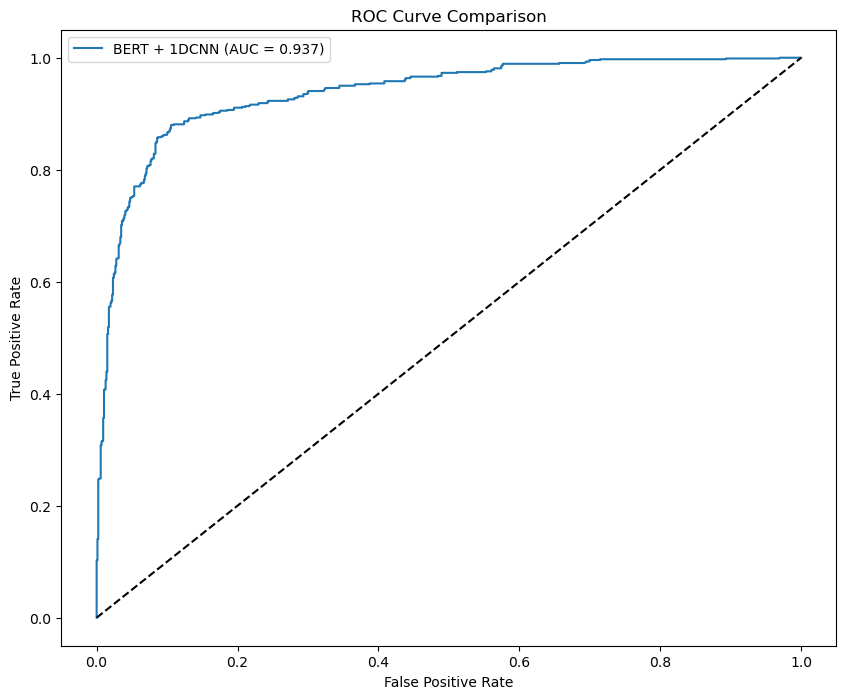


BERT + 1DCNN Report:
Accuracy: 0.885
Training Time: 23.776 seconds
Model Size: 311681 parameters
Classification Report:
              precision    recall  f1-score   support

     Class 0      0.892     0.894     0.893       862
     Class 1      0.877     0.874     0.876       740

    accuracy                          0.885      1602
   macro avg      0.885     0.884     0.884      1602
weighted avg      0.885     0.885     0.885      1602

AUC: 0.937




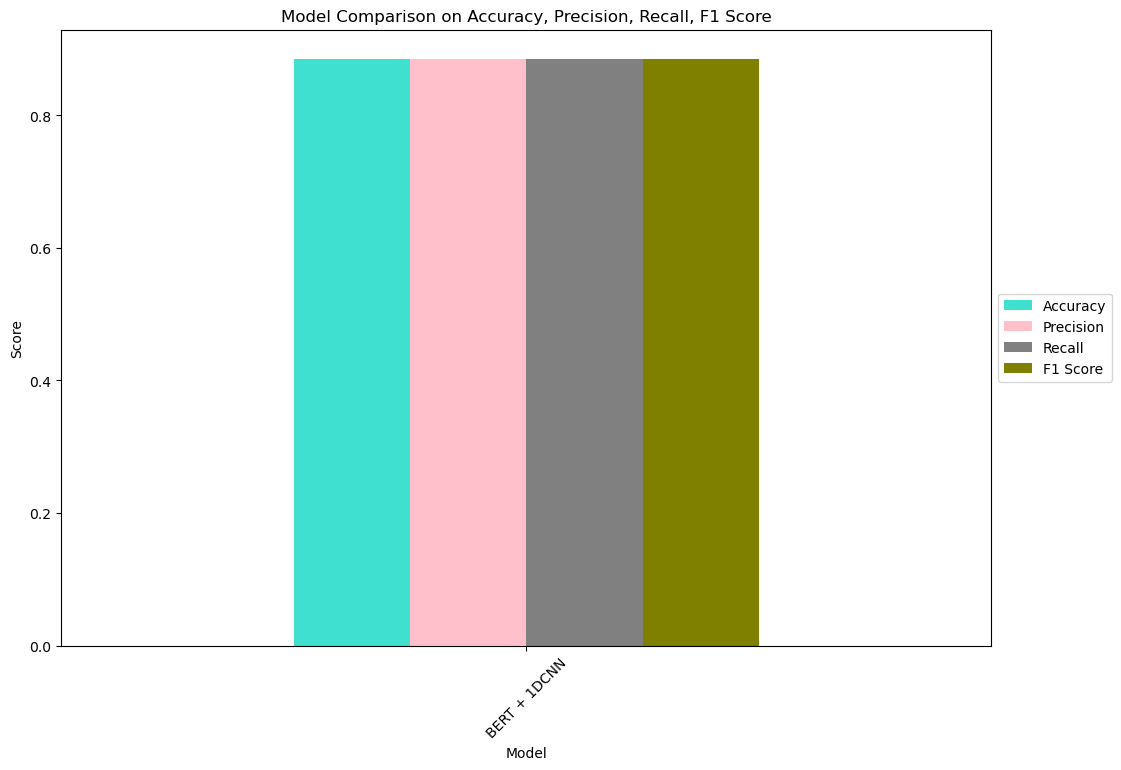

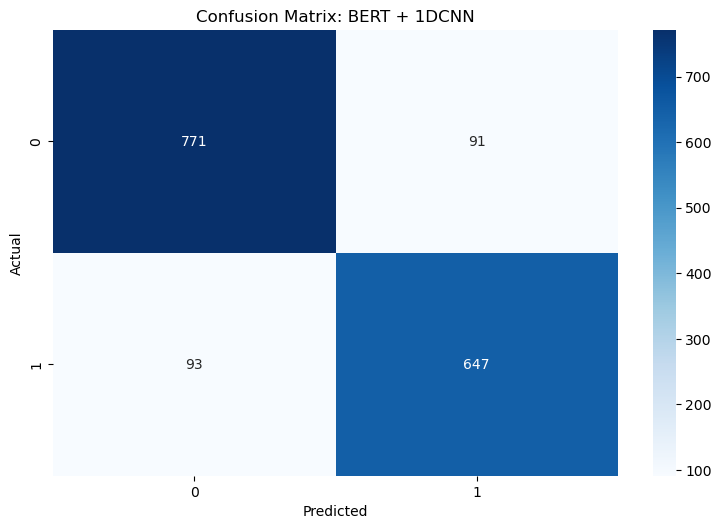

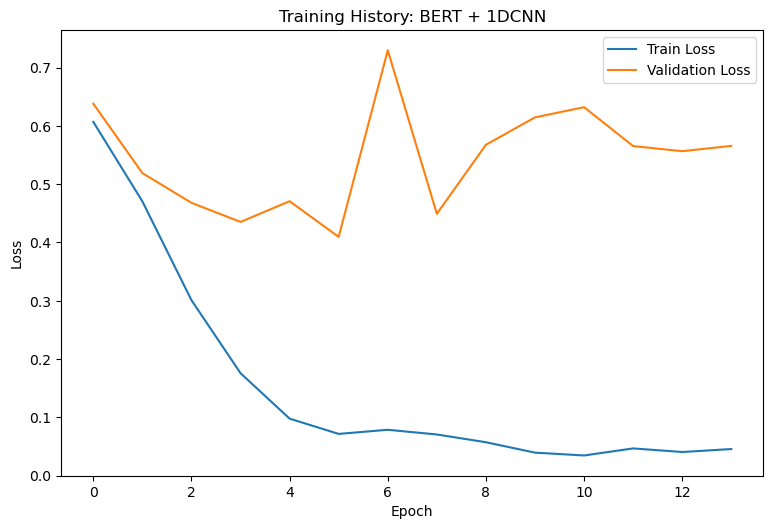


Starting training and evaluation for TF-IDF + 1DCNN
Training TF-IDF + 1DCNN...
Epoch 1/30
401/401 - 7s - 18ms/step - accuracy: 0.5688 - loss: 0.6725 - val_accuracy: 0.5749 - val_loss: 0.6635
Epoch 2/30
401/401 - 6s - 16ms/step - accuracy: 0.5917 - loss: 0.6617 - val_accuracy: 0.5787 - val_loss: 0.6612
Epoch 3/30
401/401 - 6s - 16ms/step - accuracy: 0.5922 - loss: 0.6621 - val_accuracy: 0.5861 - val_loss: 0.6612
Epoch 4/30
401/401 - 6s - 15ms/step - accuracy: 0.5927 - loss: 0.6616 - val_accuracy: 0.5824 - val_loss: 0.6606
Epoch 5/30
401/401 - 7s - 16ms/step - accuracy: 0.5936 - loss: 0.6613 - val_accuracy: 0.5787 - val_loss: 0.6649
Epoch 6/30
401/401 - 6s - 15ms/step - accuracy: 0.5986 - loss: 0.6608 - val_accuracy: 0.5780 - val_loss: 0.6624
Epoch 7/30
401/401 - 6s - 15ms/step - accuracy: 0.5978 - loss: 0.6617 - val_accuracy: 0.5849 - val_loss: 0.6610
Epoch 8/30
401/401 - 6s - 15ms/step - accuracy: 0.5969 - loss: 0.6608 - val_accuracy: 0.5737 - val_loss: 0.6615
51/51 ━━━━━━━━━━━━━━━━━━

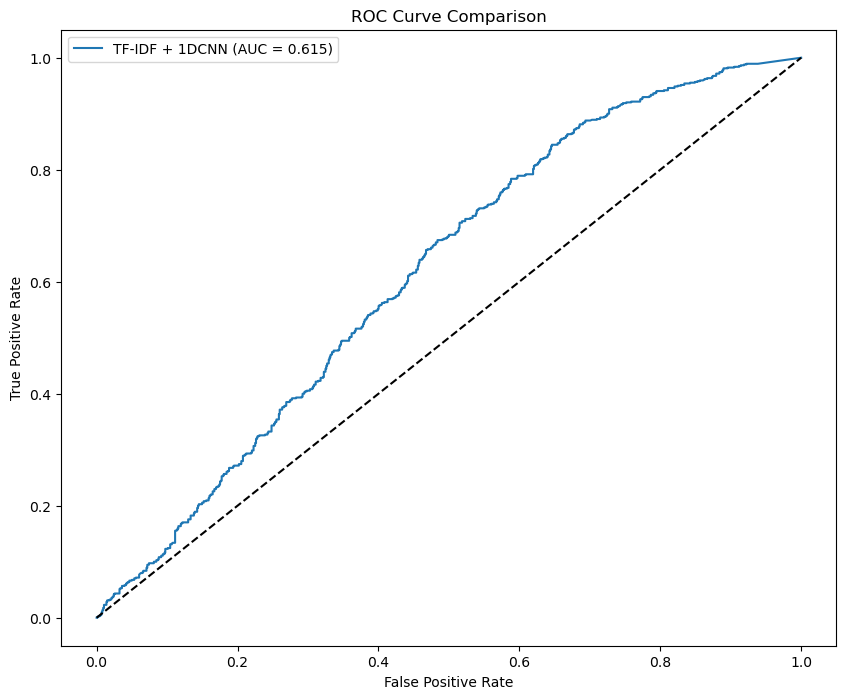


TF-IDF + 1DCNN Report:
Accuracy: 0.575
Training Time: 50.542 seconds
Model Size: 17153 parameters
Classification Report:
              precision    recall  f1-score   support

     Class 0      0.597     0.644     0.620       862
     Class 1      0.544     0.495     0.518       740

    accuracy                          0.575      1602
   macro avg      0.571     0.569     0.569      1602
weighted avg      0.573     0.575     0.573      1602

AUC: 0.615




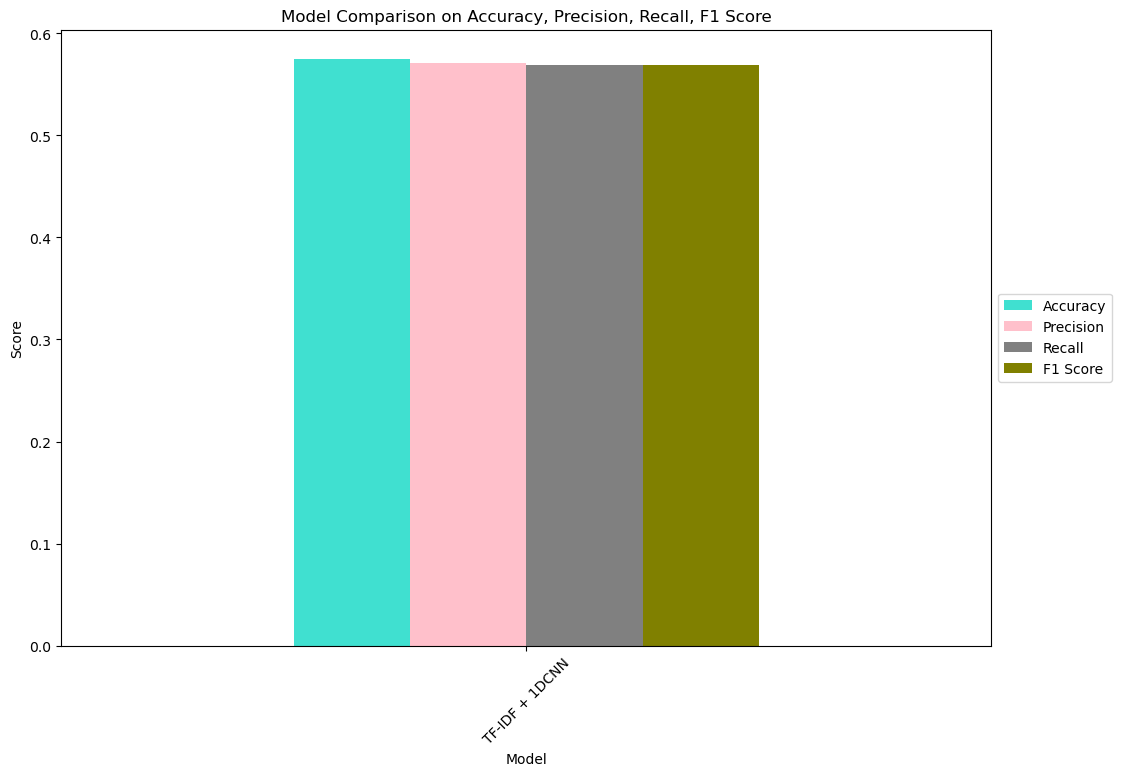

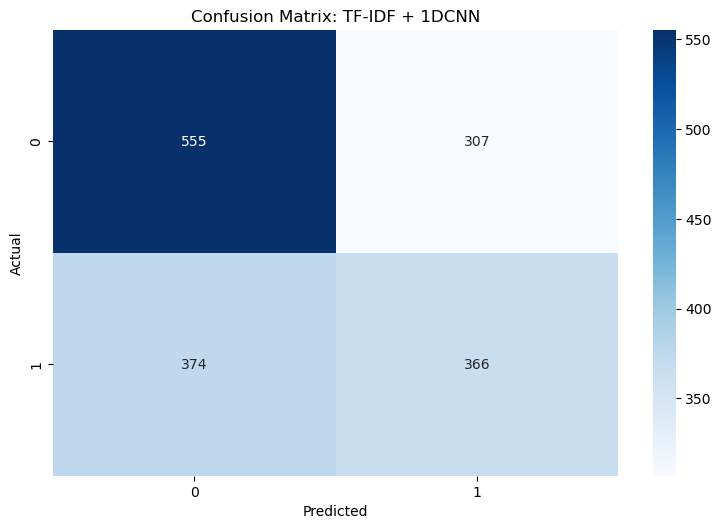

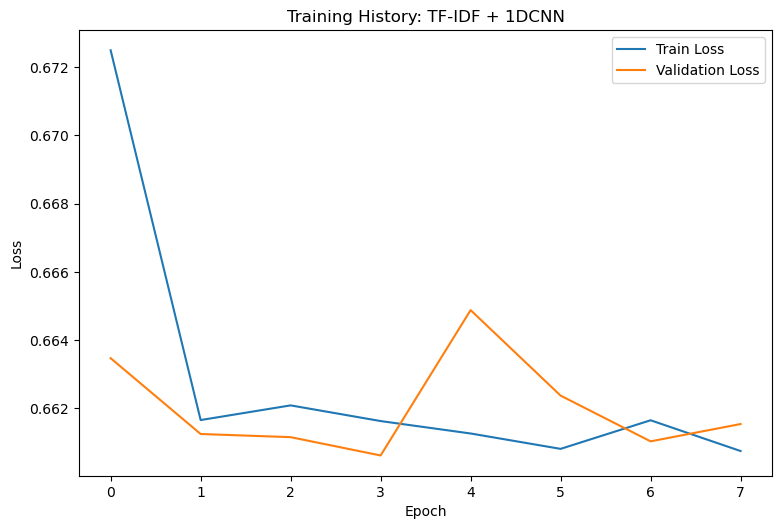


Starting training and evaluation for BoW + 1DCNN
Training BoW + 1DCNN...
Epoch 1/30
401/401 - 7s - 17ms/step - accuracy: 0.5536 - loss: 0.6895 - val_accuracy: 0.5730 - val_loss: 0.6978
Epoch 2/30
401/401 - 6s - 15ms/step - accuracy: 0.5639 - loss: 0.6840 - val_accuracy: 0.5549 - val_loss: 0.6819
Epoch 3/30
401/401 - 6s - 15ms/step - accuracy: 0.5816 - loss: 0.6778 - val_accuracy: 0.5543 - val_loss: 0.6805
Epoch 4/30
401/401 - 6s - 15ms/step - accuracy: 0.5883 - loss: 0.6757 - val_accuracy: 0.5774 - val_loss: 0.6787
Epoch 5/30
401/401 - 6s - 15ms/step - accuracy: 0.5908 - loss: 0.6745 - val_accuracy: 0.5730 - val_loss: 0.6785
Epoch 6/30
401/401 - 6s - 15ms/step - accuracy: 0.5922 - loss: 0.6741 - val_accuracy: 0.5849 - val_loss: 0.6777
Epoch 7/30
401/401 - 6s - 15ms/step - accuracy: 0.5944 - loss: 0.6736 - val_accuracy: 0.5830 - val_loss: 0.6771
Epoch 8/30
401/401 - 6s - 15ms/step - accuracy: 0.5920 - loss: 0.6735 - val_accuracy: 0.5749 - val_loss: 0.6828
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 

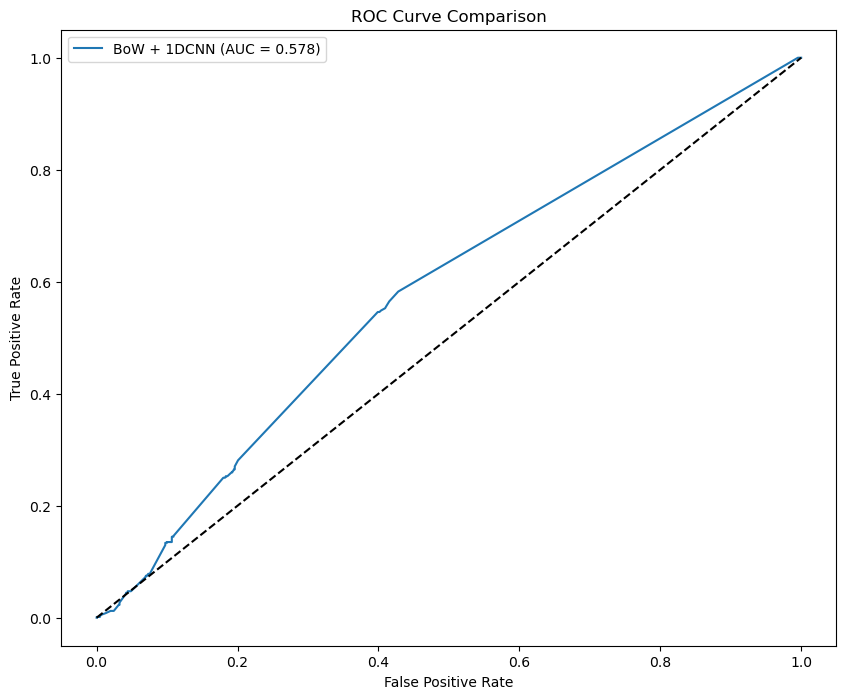


BoW + 1DCNN Report:
Accuracy: 0.573
Training Time: 49.159 seconds
Model Size: 17153 parameters
Classification Report:
              precision    recall  f1-score   support

     Class 0      0.606     0.590     0.598       862
     Class 1      0.537     0.553     0.545       740

    accuracy                          0.573      1602
   macro avg      0.571     0.572     0.571      1602
weighted avg      0.574     0.573     0.573      1602

AUC: 0.578




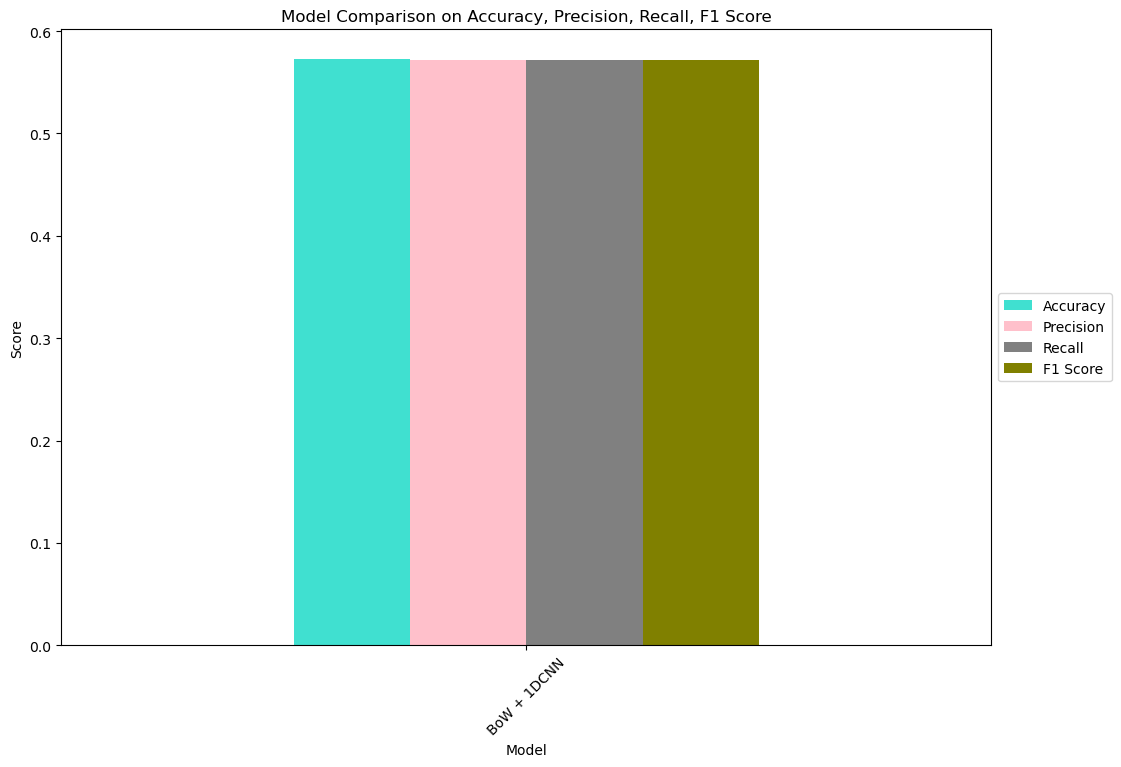

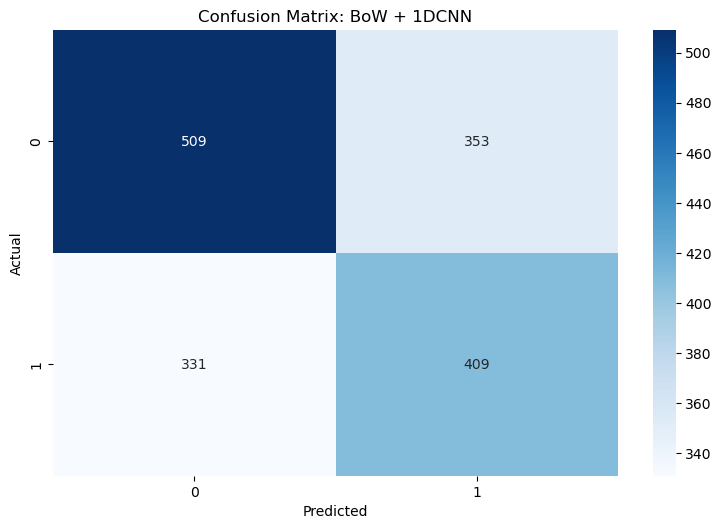

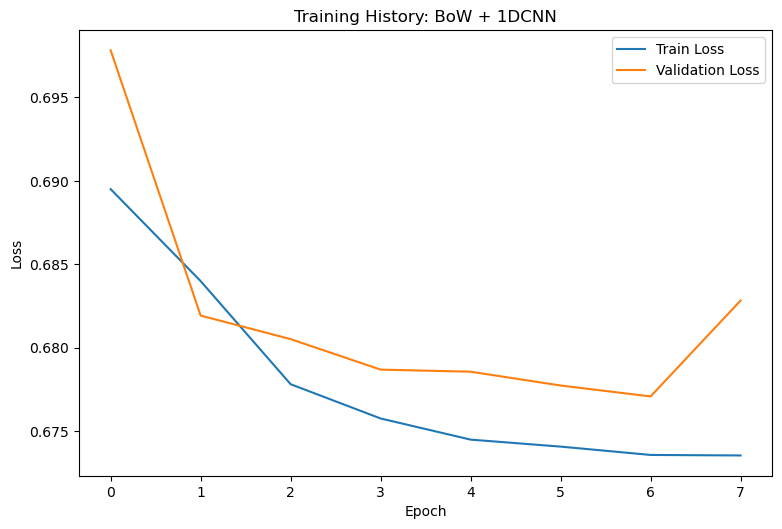


Starting training and evaluation for N-gram + 1DCNN
Training N-gram + 1DCNN...
Epoch 1/30
401/401 - 15s - 37ms/step - accuracy: 0.5532 - loss: 0.6852 - val_accuracy: 0.5574 - val_loss: 0.6837
Epoch 2/30
401/401 - 15s - 37ms/step - accuracy: 0.5833 - loss: 0.6698 - val_accuracy: 0.5449 - val_loss: 0.6765
Epoch 3/30
401/401 - 15s - 38ms/step - accuracy: 0.5897 - loss: 0.6667 - val_accuracy: 0.5624 - val_loss: 0.6746
Epoch 4/30
401/401 - 15s - 38ms/step - accuracy: 0.5931 - loss: 0.6658 - val_accuracy: 0.5699 - val_loss: 0.6748
Epoch 5/30
401/401 - 15s - 38ms/step - accuracy: 0.5916 - loss: 0.6646 - val_accuracy: 0.5718 - val_loss: 0.6763
Epoch 6/30
401/401 - 15s - 39ms/step - accuracy: 0.5894 - loss: 0.6648 - val_accuracy: 0.5605 - val_loss: 0.6772
Epoch 7/30
401/401 - 15s - 37ms/step - accuracy: 0.5939 - loss: 0.6649 - val_accuracy: 0.5655 - val_loss: 0.6780
Epoch 8/30
401/401 - 15s - 37ms/step - accuracy: 0.5938 - loss: 0.6643 - val_accuracy: 0.5699 - val_loss: 0.6748
51/51 ━━━━━━━━━━

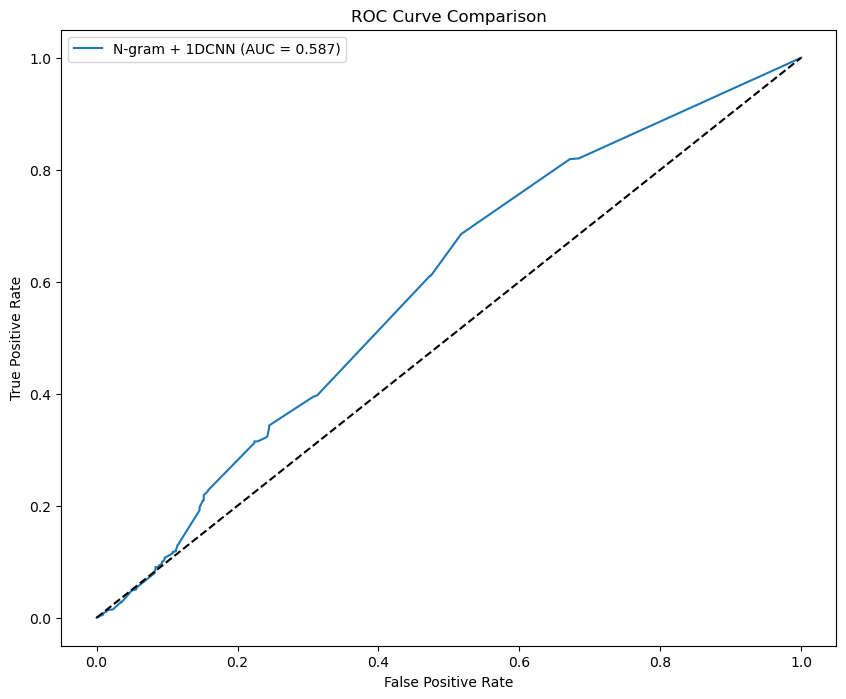


N-gram + 1DCNN Report:
Accuracy: 0.557
Training Time: 120.856 seconds
Model Size: 17153 parameters
Classification Report:
              precision    recall  f1-score   support

     Class 0      0.566     0.759     0.648       862
     Class 1      0.535     0.323     0.403       740

    accuracy                          0.557      1602
   macro avg      0.550     0.541     0.526      1602
weighted avg      0.552     0.557     0.535      1602

AUC: 0.587




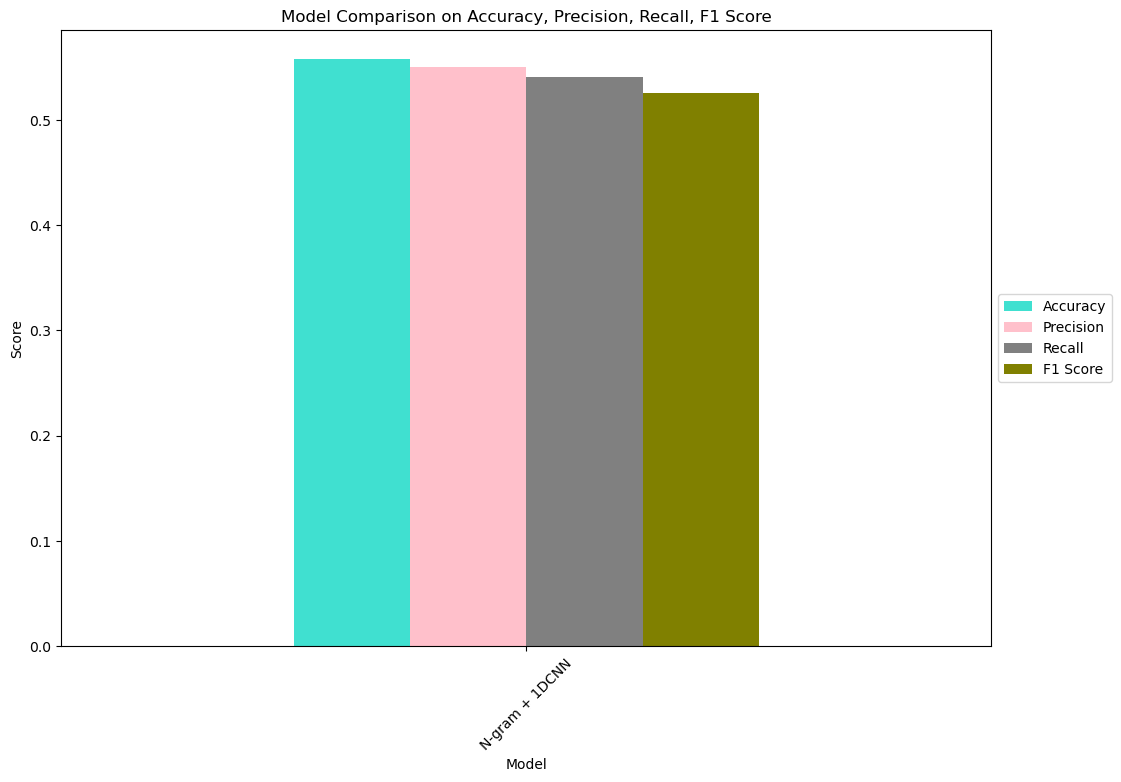

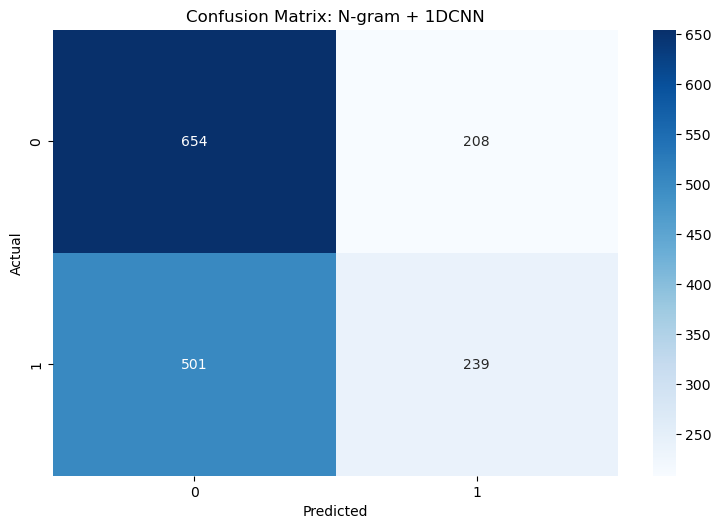

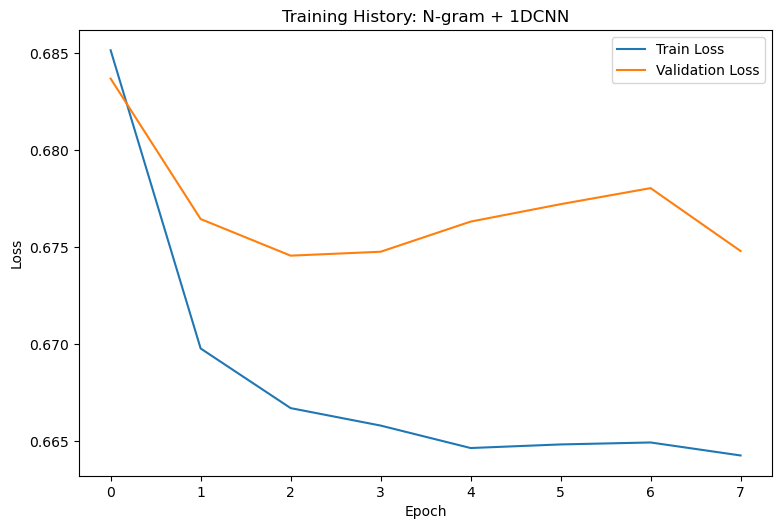

In [2]:

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from transformers import BertTokenizer, TFBertModel
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Create output directory for plots
output_dir = 'Token_Comparison_1D_CNN'
os.makedirs(output_dir, exist_ok=True)

# Load dataset
data = pd.read_csv('001_2802_merged_12000.csv')

# Data preprocessing
X = data['text']
y = data['label']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# 1. BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

def tokenize_and_encode(texts, max_len=64):
    inputs = tokenizer(
        texts.tolist(),
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    return inputs

X_train_bert_encoded = tokenize_and_encode(X_train, max_len=64)
X_test_bert_encoded = tokenize_and_encode(X_test, max_len=64)

def generate_embeddings(bert_model, encoded_inputs):
    outputs = bert_model(encoded_inputs['input_ids'], attention_mask=encoded_inputs['attention_mask'])
    return outputs.last_hidden_state

X_train_bert = generate_embeddings(bert_model, X_train_bert_encoded)
X_test_bert = generate_embeddings(bert_model, X_test_bert_encoded)

# 2. TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

# 3. Bag of Words (BoW)
bow_vectorizer = CountVectorizer(max_features=10000)
X_train_bow = bow_vectorizer.fit_transform(X_train).toarray()
X_test_bow = bow_vectorizer.transform(X_test).toarray()

# 4. N-gram Tokenization
def ngram_tokenize(texts, ngram_range=(1, 2)):
    vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=10000)
    return vectorizer.fit_transform(texts).toarray()

X_train_ngram = ngram_tokenize(X_train)
X_test_ngram = ngram_tokenize(X_test)

# Reshape input for models that require an additional dimension
def reshape_input_for_cnn(X):
    return np.expand_dims(X, axis=-1)

# Reshaping the input
X_train_tfidf_reshaped = reshape_input_for_cnn(X_train_tfidf)
X_test_tfidf_reshaped = reshape_input_for_cnn(X_test_tfidf)

X_train_bow_reshaped = reshape_input_for_cnn(X_train_bow)
X_test_bow_reshaped = reshape_input_for_cnn(X_test_bow)

X_train_ngram_reshaped = reshape_input_for_cnn(X_train_ngram)
X_test_ngram_reshaped = reshape_input_for_cnn(X_test_ngram)

# Define a common CNN architecture with adjusted kernel size
def create_cnn_model(input_shape):
    model = Sequential([
        Conv1D(128, 3, activation='relu', input_shape=input_shape),
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid', dtype='float32')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Models dictionary with reshaped inputs
nn_models = {
    'BERT + 1DCNN': create_cnn_model(X_train_bert.shape[1:]),
    'TF-IDF + 1DCNN': create_cnn_model(X_train_tfidf_reshaped.shape[1:]),
    'BoW + 1DCNN': create_cnn_model(X_train_bow_reshaped.shape[1:]),
    'N-gram + 1DCNN': create_cnn_model(X_train_ngram_reshaped.shape[1:])
}

def train_and_evaluate_models(models, X_train, y_train, X_test, y_test):
    results = {}
    plt.figure(figsize=(10, 8))  # For ROC curve plotting

    for name, model in models.items():
        print(f"Training {name}...")
        start_time = time.time()
        history = model.fit(X_train, y_train, batch_size=16, epochs=30, validation_data=(X_test, y_test), verbose=2, callbacks=[early_stopping])
        training_time = time.time() - start_time
        
        y_pred_proba = model.predict(X_test).ravel()
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, average=None),  # Per-class precision
            'recall': recall_score(y_test, y_pred, average=None),  # Per-class recall
            'f1': f1_score(y_test, y_pred, average=None),  # Per-class F1 score
            'auc': roc_auc_score(y_test, y_pred_proba),
            'training_time': training_time,
            'model_size': model.count_params(),
            'classification_report': classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], digits=3),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'roc_curve': (fpr, tpr),
            'history': history.history
        }
        
        # Plot ROC curve for each model
        plt.plot(fpr, tpr, label=f'{name} (AUC = {results[name]["auc"]:.3f})')

    # Finalize and save the combined ROC plot
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc='best')
    plt.savefig(os.path.join(output_dir, 'Combined_ROC_Curve.png'))
    plt.show()

    # Print report for each model
    for name, result in results.items():
        print(f"\n{name} Report:")
        print(f"Accuracy: {result['accuracy']:.3f}")
        print(f"Training Time: {result['training_time']:.3f} seconds")
        print(f"Model Size: {result['model_size']} parameters")
        print(f"Classification Report:\n{result['classification_report']}")
        print(f"AUC: {result['auc']:.3f}")
        print("\n" + "="*60 + "\n")

    # Plot Accuracy, Precision, Recall, F1 scores and save the plot
    metrics_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Accuracy': [results[name]['accuracy'] for name in results],
        'Precision': [results[name]['precision'].mean() for name in results],
        'Recall': [results[name]['recall'].mean() for name in results],
        'F1 Score': [results[name]['f1'].mean() for name in results]
    })

    metrics_df.set_index('Model').plot(kind='bar', figsize=(12, 8), color= ['turquoise', 'pink', 'gray', 'olive'])
    plt.title('Model Comparison on Accuracy, Precision, Recall, F1 Score')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig(os.path.join(output_dir, 'Model_Comparison.png'))
    plt.show()

    # Plot confusion matrices and save the plot
    plt.figure(figsize=(15, 10))
    for i, (name, result) in enumerate(results.items()):
        plt.subplot(2, 2, i + 1)
        sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix: {name}')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'Confusion_Matrices.png'))
    plt.show()


    # Plot training history for each model and save the plot
    plt.figure(figsize=(15, 10))
    for i, (name, result) in enumerate(results.items()):
        plt.subplot(2, 2, i + 1)
        plt.plot(result['history']['loss'], label='Train Loss')
        plt.plot(result['history']['val_loss'], label='Validation Loss')
        plt.title(f'Training History: {name}')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'Training_History.png'))
    plt.show()

# Train and evaluate all models
for name, (X_train, X_test) in {
    'BERT + 1DCNN': (X_train_bert, X_test_bert),
    'TF-IDF + 1DCNN': (X_train_tfidf_reshaped, X_test_tfidf_reshaped),
    'BoW + 1DCNN': (X_train_bow_reshaped, X_test_bow_reshaped),
    'N-gram + 1DCNN': (X_train_ngram_reshaped, X_test_ngram_reshaped)
}.items():
    print(f"\nStarting training and evaluation for {name}")
    train_and_evaluate_models({name: nn_models[name]}, X_train, y_train, X_test, y_test)


C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



BERT Model Prediction Report:
Accuracy: 0.551
Classification Report:
              precision    recall  f1-score   support

     Class 0      0.494     0.707     0.582      1237
     Class 1      0.649     0.427     0.515      1565

    accuracy                          0.551      2802
   macro avg      0.571     0.567     0.548      2802
weighted avg      0.580     0.551     0.544      2802

AUC: 0.585




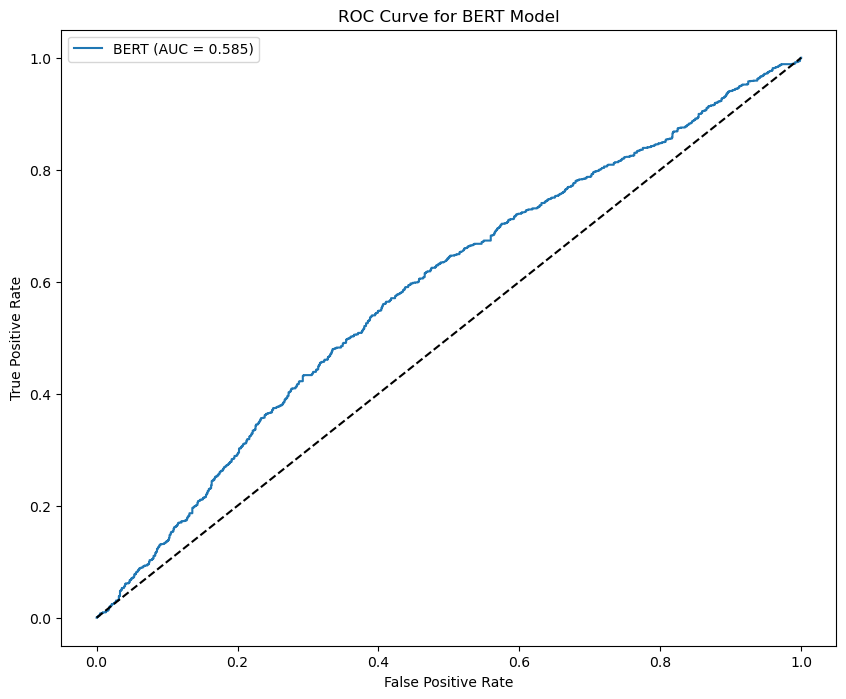

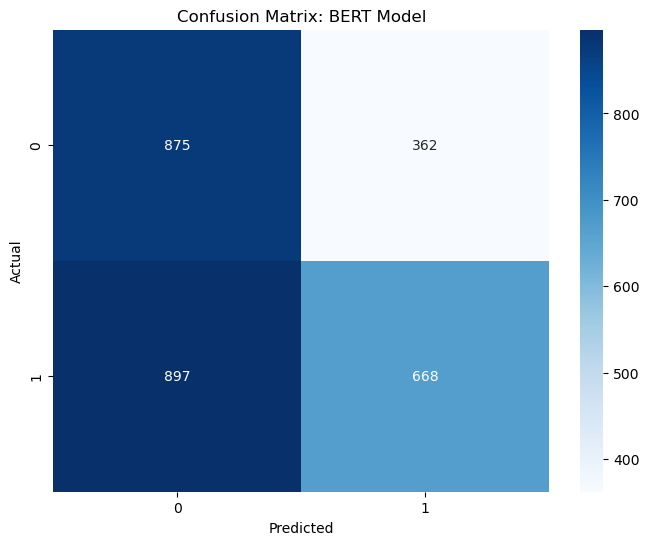

In [28]:
##007 use BERT to directly predict
import os
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

# Create directory for saving plots
output_dir = 'BERT_directly_prediction'
os.makedirs(output_dir, exist_ok=True)

# Load dataset
data = pd.read_csv('001_2802_merged_12000.csv')

# Data preprocessing
X = data['text']
y = data['label']

# Load pre-trained BERT tokenizer and model for sequence classification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenize and encode sequences using BERT tokenizer
def tokenize_and_encode(texts, max_len=64):
    inputs = tokenizer(
        texts.tolist(),
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    return inputs

X_encoded = tokenize_and_encode(X)

# Use the BERT model to predict directly
predictions = bert_model(X_encoded['input_ids'], attention_mask=X_encoded['attention_mask'])

# Convert logits to probabilities
y_pred_proba = tf.nn.softmax(predictions.logits, axis=1)[:, 1].numpy()  # Probability of the positive class
y_pred = tf.argmax(predictions.logits, axis=1).numpy()  # Predicted class labels

# Calculate metrics
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
auc = roc_auc_score(y, y_pred_proba)
classification_rep = classification_report(y, y_pred, target_names=['Class 0', 'Class 1'], digits=3)
conf_matrix = confusion_matrix(y, y_pred)
fpr, tpr, _ = roc_curve(y, y_pred_proba)

# Print report
print("\nBERT Model Prediction Report:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Classification Report:\n{classification_rep}")
print(f"AUC: {auc:.3f}")
print("\n" + "="*60 + "\n")

# Plot ROC curve and save it
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'BERT (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for BERT Model')
plt.legend(loc='best')
plt.savefig(os.path.join(output_dir, 'ROC_Curve_BERT.png'))
plt.show()

# Plot confusion matrix and save it
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: BERT Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig(os.path.join(output_dir, 'Confusion_Matrix_BERT.png'))
plt.show()


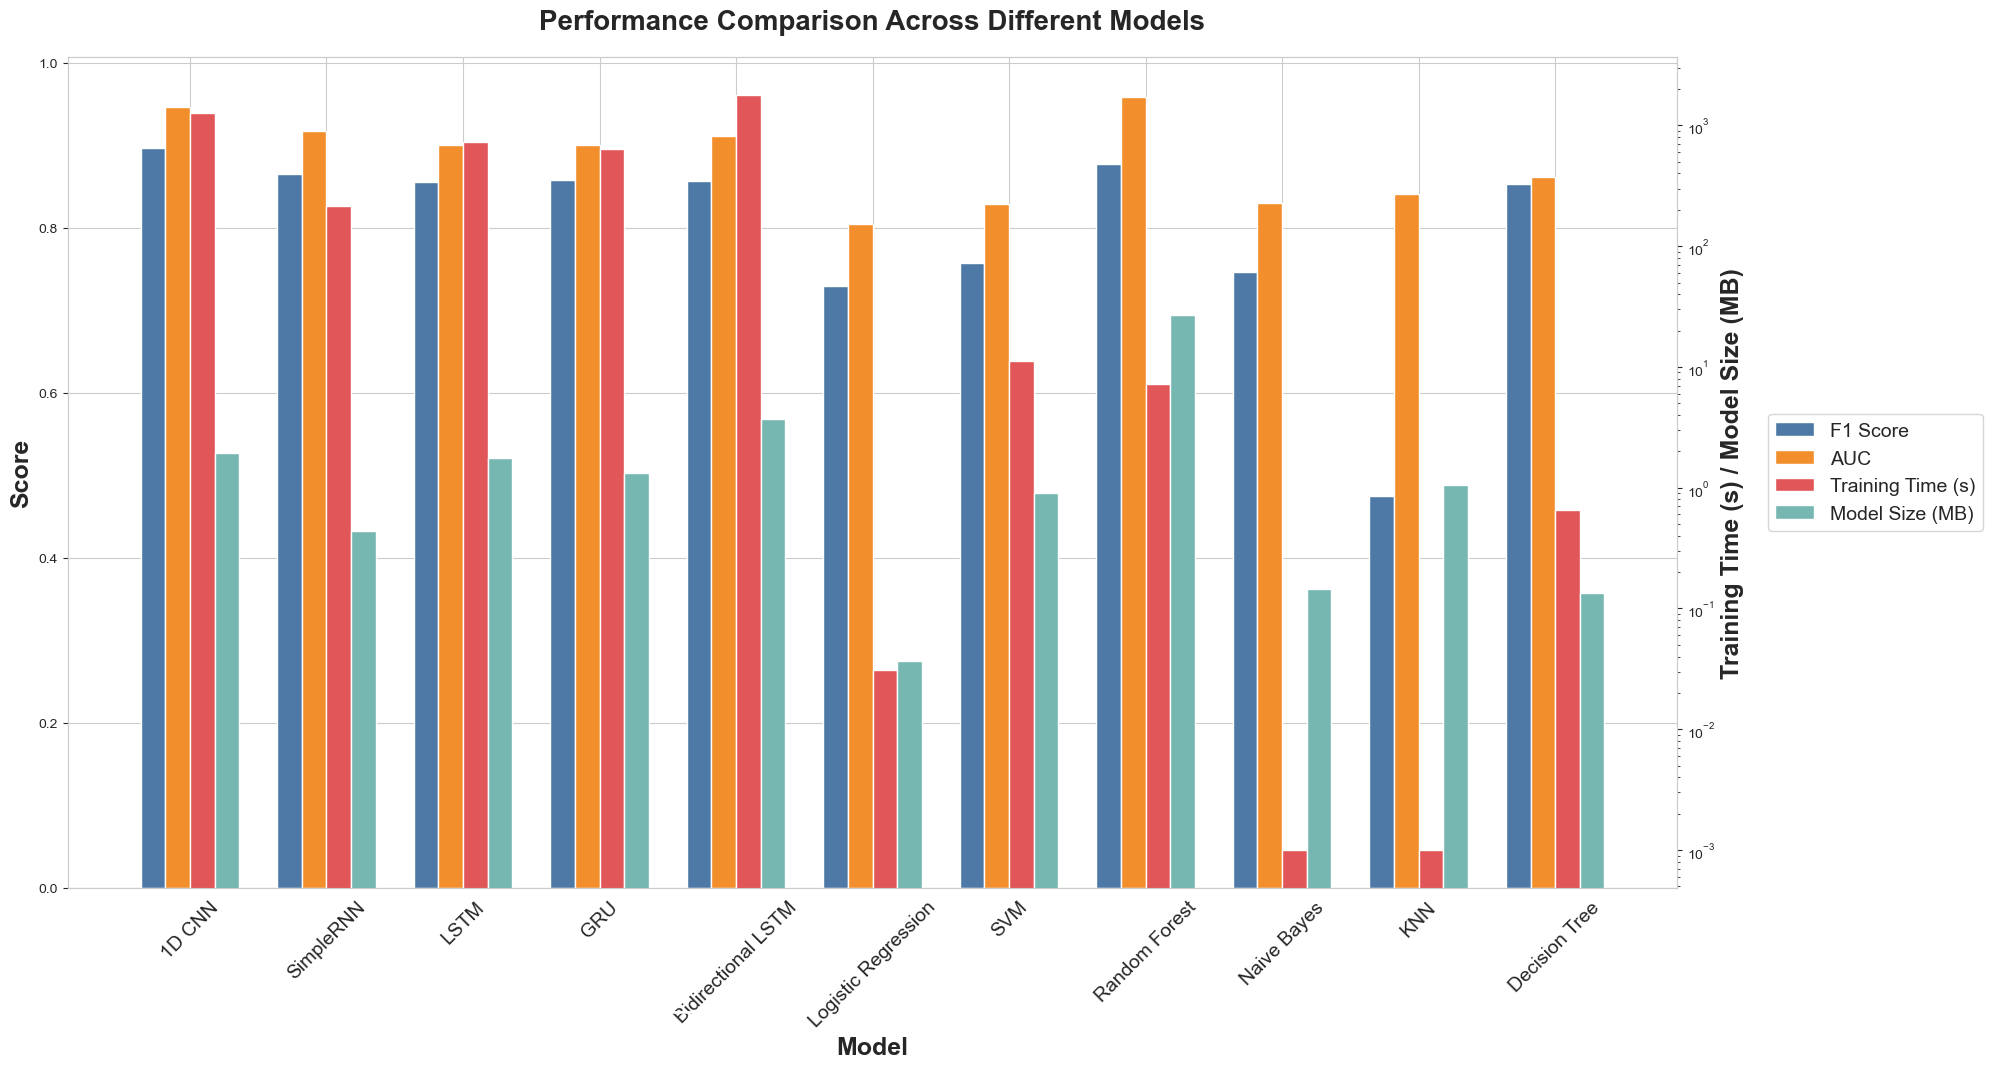

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import FancyBboxPatch

# Set Seaborn style for modern aesthetics
sns.set_style('whitegrid')

# Updated DataFrame with new model sizes
df_updated = pd.DataFrame({
    'Model': [
        '1D CNN', 'SimpleRNN', 'LSTM', 'GRU', 'Bidirectional LSTM',
        'Logistic Regression', 'SVM', 'Random Forest', 'Naive Bayes', 'KNN', 'Decision Tree'
    ],
    'Training Time (s)': [1274.329, 213.803, 730.680, 641.645, 1794.546, 0.031, 11.190, 7.165, 0.001, 0.001, 0.649],
    'F1 Score': [0.896, 0.865, 0.855, 0.858, 0.857, 0.729, 0.757, 0.877, 0.746, 0.475, 0.853],
    'AUC': [0.946, 0.917, 0.900, 0.900, 0.911, 0.805, 0.829, 0.959, 0.830, 0.841, 0.862],
    'Model Size (MB)': [1.94, 0.44, 1.75, 1.32, 3.673, 0.037, 0.902, 26.923, 0.146, 1.050, 0.134]
})

# Increase the figure size
fig, ax1 = plt.subplots(figsize=(20, 12))

# Define bar width and positions
bar_width = 0.18
index = np.arange(len(df_updated['Model']))

# Modern color palette
colors = {
    'F1 Score': '#4E79A7',       # muted blue
    'AUC': '#F28E2B',            # orange
    'Training Time (s)': '#E15759', # red
    'Model Size (MB)': '#76B7B2'    # teal
}

# Plot F1 Score
bar1 = ax1.bar(index, df_updated['F1 Score'], bar_width, label='F1 Score', color=colors['F1 Score'])

# Plot AUC
bar2 = ax1.bar(index + bar_width, df_updated['AUC'], bar_width, label='AUC', color=colors['AUC'])

# Create second y-axis for Training Time and Model Size
ax2 = ax1.twinx()

# Plot Training Time
bar3 = ax2.bar(index + 2*bar_width, df_updated['Training Time (s)'], bar_width, label='Training Time (s)', color=colors['Training Time (s)'])

# Plot Model Size
bar4 = ax2.bar(index + 3*bar_width, df_updated['Model Size (MB)'], bar_width, label='Model Size (MB)', color=colors['Model Size (MB)'])

# Set log scale for second y-axis
ax2.set_yscale('log')

# Set axis labels and title
ax1.set_xlabel('Model', fontsize=18, fontweight='bold')
ax1.set_ylabel('Score', fontsize=18, fontweight='bold')
ax2.set_ylabel('Training Time (s) / Model Size (MB)', fontsize=18, fontweight='bold')
ax1.set_title('Performance Comparison Across Different Models', fontsize=20, fontweight='bold', pad=20)

# Set x-axis tick labels
ax1.set_xticks(index + 1.5*bar_width)
ax1.set_xticklabels(df_updated['Model'], rotation=45, fontsize=14)

# Combine legends from both axes and position them on the right
bars = [bar1, bar2, bar3, bar4]
labels = [bar.get_label() for bar in bars]
ax1.legend(bars, labels, fontsize=14, loc='center left', bbox_to_anchor=(1.05, 0.5))

# Adding brackets and labels
text_props = dict(ha='center', va='center', fontsize=14, fontweight='bold')

# First bracket for Neural Networks
ax1.annotate('',
             xy=(0.03, -0.15), xycoords='axes fraction',
             xytext=(0.42, -0.15), textcoords='axes fraction',
             arrowprops=dict(arrowstyle='-[', lw=2.0))



# Second bracket for Machine Learning Models
ax1.annotate('',
             xy=(0.55, -0.15), xycoords='axes fraction',
             xytext=(0.97, -0.15), textcoords='axes fraction',
             arrowprops=dict(arrowstyle='-[', lw=2.0))



# Only show gridlines on the left y-axis
ax1.grid(True)
ax2.grid(False)

# Adjust layout and add padding
fig.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust bottom margin to fit the labels

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Data for Conventional ML Models
data_conventional = {
    'Model': ['LR', 'SVM', 'RF', 'NB', 'KNN', 'DT'],
    'TF-IDF Accuracy': [73.0, 75.7, 87.6, 74.6, 57.1, 85.3],
    'Transfer Learning Accuracy': [69.8, 72.8, 87.1, 60.3, 69.5, 85.1],
    'TF-IDF AUC': [80.5, 82.9, 95.9, 83.0, 84.1, 86.2],
    'Transfer Learning AUC': [76.8, 77.3, 94.0, 65.3, 75.8, 85.6]
}

df_conventional = pd.DataFrame(data_conventional)

# Data for Neural Networks
data_neural = {
    'Model': ['RNN', 'IDCNN', 'LSTM', 'GRU', 'BiLSTM'],
    'KFT Accuracy': [54.2, 78.8, 53.8, 53.8, 56.7],
    'Transfer Learning Accuracy': [86.5, 89.3, 85.5, 85.8, 85.7],
    'KFT AUC': [47.9, 86.3, 49.0, 49.8, 69.2],
    'Transfer Learning AUC': [90.4, 94.8, 89.5, 89.7, 91.4]
}

df_neural = pd.DataFrame(data_neural)

# Plot for Conventional ML Models - Accuracy
df_conventional.set_index('Model')[['TF-IDF Accuracy', 'Transfer Learning Accuracy']].plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'])
plt.title('Accuracy Comparison - Conventional ML Models')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45)
plt.savefig('/mnt/data/Conventional_ML_Accuracy_Comparison.png')
plt.show()

# Plot for Conventional ML Models - AUC
df_conventional.set_index('Model')[['TF-IDF AUC', 'Transfer Learning AUC']].plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'])
plt.title('AUC Comparison - Conventional ML Models')
plt.ylabel('AUC (%)')
plt.xticks(rotation=45)
plt.savefig('/mnt/data/Conventional_ML_AUC_Comparison.png')
plt.show()

# Plot for Neural Networks - Accuracy
df_neural.set_index('Model')[['KFT Accuracy', 'Transfer Learning Accuracy']].plot(kind='bar', figsize=(10, 6), color=['green', 'red'])
plt.title('Accuracy Comparison - Neural Networks')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45)
plt.savefig('/mnt/data/Neural_Networks_Accuracy_Comparison.png')
plt.show()

# Plot for Neural Networks - AUC
df_neural.set_index('Model')[['KFT AUC', 'Transfer Learning AUC']].plot(kind='bar', figsize=(10, 6), color=['green', 'red'])
plt.title('AUC Comparison - Neural Networks')
plt.ylabel('AUC (%)')
plt.xticks(rotation=45)
plt.savefig('/mnt/data/Neural_Networks_AUC_Comparison.png')
plt.show()
